DOwnload Data

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import yfinance as yf
import ta
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')



# --- CONFIGURATION ---
PROJECT_ROOT_ABSOLUTE = "/home/onyxia/work/Gestion-portefeuille/" 
ROOT_DIR = Path(PROJECT_ROOT_ABSOLUTE)
OUTPUT_PATH_FINAL = ROOT_DIR / "data" / "raw"
OUTPUT_PATH_FINAL.mkdir(parents=True, exist_ok=True)


CAC40_TICKERS = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "ATO.PA", "CS.PA", "BNP.PA",
    "EN.PA", "CAP.PA", "CA.PA", "DSY.PA", "EL.PA", "ENGI.PA", "ERF.PA",
    "RMS.PA", "KER.PA", "OR.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA",
    "RI.PA", "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA",
    "GLE.PA", "STLAP.PA", "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA",
    "URW.PA", "VIE.PA", "DG.PA", "VIV.PA", "WLN.PA", "FR.PA"
]


end_date = datetime.today().strftime('%Y-%m-%d')  # Ou date fixe '2025-12-25'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*10)  # 10 ans


print(f" Téléchargement CAC40 Dataset Global")
print(f"   Tickers : {len(CAC40_TICKERS)}")
print(f"   Période : {start_date.date()} → {end_date}")


# --- TÉLÉCHARGEMENT GROUPÉ (comme S&P500) ---
df = yf.download(
    tickers=CAC40_TICKERS,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=True
).stack()

# --- RESTRUCTURATION (comme S&P500) ---
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()


print(f"\n Dataset CAC40 créé !")
print(f"   Shape : {df.shape}")
print(f"   Tickers : {df.index.get_level_values('ticker').nunique()}")
print(f"   Période : {df.index.get_level_values('date').min().date()} → {df.index.get_level_values('date').max().date()}")


# --- APERÇU ---
print("\n Aperçu des données :")
#print(df.head(10000))

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df




 Téléchargement CAC40 Dataset Global
   Tickers : 40
   Période : 2016-01-02 → 2025-12-30


[*********************100%***********************]  40 of 40 completed


 Dataset CAC40 créé !
   Shape : (100492, 6)
   Tickers : 40
   Période : 2016-01-04 → 2025-12-29

 Aperçu des données :


Price                adj close        close         high          low  \
date       ticker                                                       
2016-01-04 AI.PA     54.348316    67.091957    68.489014    66.559746   
           AIR.PA    52.824341    60.860001    61.869999    60.160000   
           ALO.PA    21.622501    25.675690    26.194954    25.527328   
           ATO.PA  3866.508057  4255.194824  4346.740723  4230.330566   
           BNP.PA    29.206682    51.220001    51.790001    50.619999   
...                        ...          ...          ...          ...   
2025-12-29 TTE.PA    55.950001    55.950001    56.169998    55.759998   
           URW.PA    92.660004    92.660004    93.040001    92.000000   
           VIE.PA    29.590000    29.590000    29.670000    29.299999   
           VIV.PA     2.348000     2.348000     2.375000     2.345000   
           WLN.PA     1.625000     1.625000     1.625000     1.567500   

Price                     open     volume  
date       ticker                          
2016-01-04 AI.PA     68.422493  2043163.0  
           AIR.PA    61.150002  2885672.0  
           ALO.PA    26.120773  1925483.0  
           ATO.PA  4346.740723     6147.0  
           BNP.PA    51.750000  4769816.0  
...                        ...        ...  
2025-12-29 TTE.PA    55.810001  2645466.0  
           URW.PA    92.339996   187033.0  
           VIE.PA    29.490000  1053404.0  
           VIV.PA     2.350000  1284437.0  
           WLN.PA     1.610000  2104247.0  

[100492 rows x 6 columns]

## Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI: Relative Strength Index if an actif is overbought or oversold
* Bollinger Bands : Side where price is on over-extension .
* ATR : Average True Range : Vol moyenne de prix 
* MACD : Moving Average Convergence Divergence : Momentum


\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [4]:
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import MACD
import numpy as np
import pandas as pd

# 1. Garman-Klass Volatility (reste identique)
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)


# 2. RSI avec la bibliothèque ta
def compute_rsi(stock_data):
    if len(stock_data) < 20:
        return pd.Series(np.nan, index=stock_data.index)
    rsi_indicator = RSIIndicator(close=stock_data, window=20)
    return rsi_indicator.rsi()

df['rsi'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_rsi)


# 3. Bollinger Bands
def compute_bb_low(stock_data):
    if len(stock_data) < 20:
        return pd.Series(np.nan, index=stock_data.index)
    bb = BollingerBands(close=np.log1p(stock_data), window=20, window_dev=2)
    return bb.bollinger_lband()

def compute_bb_mid(stock_data):
    if len(stock_data) < 20:
        return pd.Series(np.nan, index=stock_data.index)
    bb = BollingerBands(close=np.log1p(stock_data), window=20, window_dev=2)
    return bb.bollinger_mavg()

def compute_bb_high(stock_data):
    if len(stock_data) < 20:
        return pd.Series(np.nan, index=stock_data.index)
    bb = BollingerBands(close=np.log1p(stock_data), window=20, window_dev=2)
    return bb.bollinger_hband()

df['bb_low'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_bb_low)
df['bb_mid'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_bb_mid)
df['bb_high'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_bb_high)


# 4. ATR
def compute_atr(stock_data):
    if len(stock_data) < 14:
        return pd.Series(np.nan, index=stock_data.index)
    atr_indicator = AverageTrueRange(
        high=stock_data['high'],
        low=stock_data['low'],
        close=stock_data['close'],
        window=14
    )
    atr = atr_indicator.average_true_range()
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)


# 5. MACD
def compute_macd(stock_data):
    if len(stock_data) < 26:
        return pd.Series(np.nan, index=stock_data.index)
    macd_indicator = MACD(
        close=stock_data['adj close'],
        window_slow=26,
        window_fast=12,
        window_sign=9
    )
    macd = macd_indicator.macd()
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False).apply(compute_macd)


# 6. Euro Volume (reste identique)
df['euro_volume'] = (df['adj close']*df['volume'])/1e6

df


Price                adj close        close         high          low  \
date       ticker                                                       
2016-01-04 AI.PA     54.348316    67.091957    68.489014    66.559746   
           AIR.PA    52.824341    60.860001    61.869999    60.160000   
           ALO.PA    21.622501    25.675690    26.194954    25.527328   
           ATO.PA  3866.508057  4255.194824  4346.740723  4230.330566   
           BNP.PA    29.206682    51.220001    51.790001    50.619999   
...                        ...          ...          ...          ...   
2025-12-29 TTE.PA    55.950001    55.950001    56.169998    55.759998   
           URW.PA    92.660004    92.660004    93.040001    92.000000   
           VIE.PA    29.590000    29.590000    29.670000    29.299999   
           VIV.PA     2.348000     2.348000     2.375000     2.345000   
           WLN.PA     1.625000     1.625000     1.625000     1.567500   

Price                     open     volume  garman_klass_vol        rsi  \
date       ticker                                                        
2016-01-04 AI.PA     68.422493  2043163.0         -0.020078        NaN   
           AIR.PA    61.150002  2885672.0         -0.007882        NaN   
           ALO.PA    26.120773  1925483.0         -0.013465        NaN   
           ATO.PA  4346.740723     6147.0         -0.004926        NaN   
           BNP.PA    51.750000  4769816.0         -0.126140        NaN   
...                        ...        ...               ...        ...   
2025-12-29 TTE.PA    55.810001  2645466.0          0.000024  54.626741   
           URW.PA    92.339996   187033.0          0.000059  57.996529   
           VIE.PA    29.490000  1053404.0          0.000074  54.285619   
           VIV.PA     2.350000  1284437.0          0.000081  33.756497   
           WLN.PA     1.610000  2104247.0          0.000616  46.333661   

Price                bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-01-04 AI.PA        NaN       NaN       NaN -2.497054       NaN   
           AIR.PA       NaN       NaN       NaN -2.383220       NaN   
           ALO.PA       NaN       NaN       NaN -2.266274       NaN   
           ATO.PA       NaN       NaN       NaN -0.685747       NaN   
           BNP.PA       NaN       NaN       NaN -3.492138       NaN   
...                     ...       ...       ...       ...       ...   
2025-12-29 TTE.PA  4.020588  4.043381  4.066174 -0.820764  0.022788   
           URW.PA  4.505418  4.526321  4.547224 -0.854937  0.080036   
           VIE.PA  3.400650  3.412482  3.424315 -0.306437  0.104510   
           VIV.PA  1.190180  1.214630  1.239079 -1.610580 -0.422462   
           WLN.PA  0.825554  0.908834  0.992115 -1.393432  0.004980   

Price              euro_volume  
date       ticker               
2016-01-04 AI.PA    111.042469  
           AIR.PA   152.433721  
           ALO.PA    41.633759  
           ATO.PA    23.767425  
           BNP.PA   139.310500  
...                        ...  
2025-12-29 TTE.PA   148.013825  
           URW.PA    17.330478  
           VIE.PA    31.170225  
           VIV.PA     3.015858  
           WLN.PA     3.419401  

[100492 rows x 14 columns]

## Statistics descriptives

In [ ]:
df.describe()

Price      adj close          close           high            low  \
count  100452.000000  100452.000000  100452.000000  100452.000000   
mean      188.725864     201.094232     203.636985     198.700974   
std       664.928709     693.109262     703.825164     684.600132   
min         1.313000       1.313000       1.344000       1.310000   
25%        22.018066      25.434999      25.770000      25.105000   
50%        47.505003      55.405001      56.080002      54.754999   
75%       105.810829     115.603647     116.650002     114.550003   
max     10130.000000   10130.000000   17300.000000    7814.000000   

Price           open        volume  garman_klass_vol           rsi  \
count  100452.000000  1.004520e+05     100452.000000  99124.000000   
mean      201.203981  1.946648e+06         -0.015401     52.066986   
std       694.197987  2.654433e+06          0.029810     10.627078   
min         1.312000  0.000000e+00         -0.179362      0.000000   
25%        25.455000  4.230118e+05         -0.015167     45.063132   
50%        55.459999  1.003462e+06         -0.003718     52.225757   
75%       115.566811  2.402776e+06         -0.000429     59.329564   
max     14300.000000  1.235753e+08          0.285452    100.000000   

Price        bb_low        bb_mid       bb_high           atr          macd  \
count  99692.000000  99692.000000  99692.000000  9.993200e+04  9.945200e+04   
mean       3.939956      3.998036      4.056116  2.844105e-17  1.714699e-18   
std        1.292113      1.291555      1.297432  9.998048e-01  9.998039e-01   
min       -0.384740      0.905743      0.984822 -2.143653e+00 -9.865273e+00   
25%        3.062340      3.136215      3.207181 -7.241977e-01 -4.668543e-01   
50%        3.825692      3.884084      3.935308 -1.676111e-01  2.273966e-02   
75%        4.622971      4.669196      4.719506  5.067307e-01  5.271535e-01   
max        8.842406      8.861260     11.540377  1.349163e+01  1.347246e+01   

Price    euro_volume  
count  100452.000000  
mean       71.376185  
std        66.397366  
min         0.000000  
25%        28.643995  
50%        51.990746  
75%        93.611357  
max      1389.033833

## Aggregate to Monthly level

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['euro_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['euro_volume'].resample('M').mean().stack('ticker').to_frame('euro_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
                  

data

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-02-29 AI.PA    102.134199    51.831638         -0.015017  51.548149   
           AIR.PA   153.356180    51.886936         -0.002901  59.227645   
           ALO.PA    26.162159    15.750299         -0.010751  22.121472   
           ATO.PA    28.735082  3453.156494         -0.003053  46.826084   
           BNP.PA   156.458959    24.519476         -0.110281  49.696059   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   189.809006    55.950001          0.000024  54.626741   
           URW.PA    37.066547    92.660004          0.000059  57.996529   
           VIE.PA    44.305261    29.590000          0.000074  54.285619   
           VIV.PA     4.520493     2.348000          0.000081  33.756497   
           WLN.PA     4.767969     1.625000          0.000616  46.333661   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 AI.PA   3.919980  3.948250  3.976520 -0.294399 -0.307834  
           AIR.PA  3.789174  3.874439  3.959705 -0.566113 -0.049484  
           ALO.PA  2.761233  2.863208  2.965183 -0.601899 -1.499577  
           ATO.PA  8.058213  8.124742  8.191270  0.029204 -0.330898  
           BNP.PA  3.117052  3.181806  3.246559  1.077231 -0.572516  
...                     ...       ...       ...       ...       ...  
2025-12-31 TTE.PA  4.020588  4.043381  4.066174 -0.820764  0.022788  
           URW.PA  4.505418  4.526321  4.547224 -0.854937  0.080036  
           VIE.PA  3.400650  3.412482  3.424315 -0.306437  0.104510  
           VIV.PA  1.190180  1.214630  1.239079 -1.610580 -0.422462  
           WLN.PA  0.825554  0.908834  0.992115 -1.393432  0.004980  

[4673 rows x 9 columns]

- calculate 5-year rolling average of euro-volume for each stock 

In [6]:
data['euro_volume'] = (data.loc[:, 'euro_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['euro_vol_rank'] = (data.groupby('date')['euro_volume'].rank(ascending=False))

#data = data[data['euro_vol_rank']<150].drop(['euro_volume', 'euro_vol_rank'], axis=1)

data 

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-02-29 AI.PA           NaN    51.831638         -0.015017  51.548149   
           AIR.PA          NaN    51.886936         -0.002901  59.227645   
           ALO.PA          NaN    15.750299         -0.010751  22.121472   
           ATO.PA          NaN  3453.156494         -0.003053  46.826084   
           BNP.PA          NaN    24.519476         -0.110281  49.696059   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   228.943643    55.950001          0.000024  54.626741   
           URW.PA    25.210617    92.660004          0.000059  57.996529   
           VIE.PA    44.763928    29.590000          0.000074  54.285619   
           VIV.PA    28.476489     2.348000          0.000081  33.756497   
           WLN.PA    25.543868     1.625000          0.000616  46.333661   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-02-29 AI.PA   3.919980  3.948250  3.976520 -0.294399 -0.307834   
           AIR.PA  3.789174  3.874439  3.959705 -0.566113 -0.049484   
           ALO.PA  2.761233  2.863208  2.965183 -0.601899 -1.499577   
           ATO.PA  8.058213  8.124742  8.191270  0.029204 -0.330898   
           BNP.PA  3.117052  3.181806  3.246559  1.077231 -0.572516   
...                     ...       ...       ...       ...       ...   
2025-12-31 TTE.PA  4.020588  4.043381  4.066174 -0.820764  0.022788   
           URW.PA  4.505418  4.526321  4.547224 -0.854937  0.080036   
           VIE.PA  3.400650  3.412482  3.424315 -0.306437  0.104510   
           VIV.PA  1.190180  1.214630  1.239079 -1.610580 -0.422462   
           WLN.PA  0.825554  0.908834  0.992115 -1.393432  0.004980   

                   euro_vol_rank  
date       ticker                 
2016-02-29 AI.PA             NaN  
           AIR.PA            NaN  
           ALO.PA            NaN  
           ATO.PA            NaN  
           BNP.PA            NaN  
...                          ...  
2025-12-31 TTE.PA            2.0  
           URW.PA           37.0  
           VIE.PA           25.0  
           VIV.PA           34.0  
           WLN.PA           36.0  

[4673 rows x 10 columns]

## Calculate Monthly Returns for different horizons as features

In [7]:
def calculate_returns(df):
    """
    Calcule les rendements CUMULÉS (Momentum) avec clipping.
    """
    outlier_cutoff = 0.005 # On coupe les 0.5% des valeurs les plus basses.
    
    # ATTENTION : Vérifiez la fréquence de vos données (voir note plus bas)
    lags = [1, 2, 3, 6, 9, 12] 

    for lag in lags:
        # 1. Calculer la variation totale sur la période (ex: Prix_t / Prix_t-12 - 1)
        returns_raw = df['adj close'].pct_change(lag)
        
        # 2. Calcul des bornes (Expanding Window)
        # min_periods=252 suggère des données journalières (1 an de trading)
        lower_bound = returns_raw.expanding(min_periods=252).quantile(outlier_cutoff)
        upper_bound = returns_raw.expanding(min_periods=252).quantile(1 - outlier_cutoff)
        
        # 3. Clipper et Assigner DIRECTEMENT
        
        df[f'return_{lag}m'] = returns_raw.clip(lower=lower_bound, upper=upper_bound)
    
    return df

# Application
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2017-02-28 AI.PA     75.441249    57.929245         -0.014297  47.545219   
           AIR.PA   108.392802    61.634541         -0.003995  68.219734   
           ALO.PA    18.326209    20.009987         -0.010231  44.279528   
           ATO.PA    23.990370  5828.903809         -0.002527  73.515004   
           BNP.PA   123.070969    32.996239         -0.098947  40.611183   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   228.943643    55.950001          0.000024  54.626741   
           URW.PA    25.210617    92.660004          0.000059  57.996529   
           VIE.PA    44.763928    29.590000          0.000074  54.285619   
           VIV.PA    28.476489     2.348000          0.000081  33.756497   
           WLN.PA    25.543868     1.625000          0.000616  46.333661   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2017-02-28 AI.PA   4.045704  4.080779  4.115854 -0.975024 -0.203447   
           AIR.PA  4.017587  4.081975  4.146364 -1.244039  0.299338   
           ALO.PA  3.035918  3.068204  3.100490 -0.932237 -0.235121   
           ATO.PA  8.545794  8.609600  8.673406 -0.037211  0.966587   
           BNP.PA  3.491512  3.556756  3.622001  0.090056 -0.986478   
...                     ...       ...       ...       ...       ...   
2025-12-31 TTE.PA  4.020588  4.043381  4.066174 -0.820764  0.022788   
           URW.PA  4.505418  4.526321  4.547224 -0.854937  0.080036   
           VIE.PA  3.400650  3.412482  3.424315 -0.306437  0.104510   
           VIV.PA  1.190180  1.214630  1.239079 -1.610580 -0.422462   
           WLN.PA  0.825554  0.908834  0.992115 -1.393432  0.004980   

                   euro_vol_rank  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                              
2017-02-28 AI.PA            10.0   0.019000  -0.035494   0.060575   0.063954   
           AIR.PA            5.0   0.104525   0.103119   0.150158   0.325684   
           ALO.PA           31.0  -0.023810  -0.021012   0.002543   0.080540   
           ATO.PA           29.0   0.132095   0.112219   0.143238   0.264029   
           BNP.PA            3.0  -0.068435  -0.089513   0.006389   0.208859   
...                          ...        ...        ...        ...        ...   
2025-12-31 TTE.PA            2.0  -0.014965   0.037071   0.099646   0.091837   
           URW.PA           37.0   0.011351   0.033690   0.036002   0.141977   
           VIE.PA           25.0   0.010242   0.032810   0.021049  -0.021818   
           VIV.PA           34.0  -0.066773  -0.247918  -0.216811  -0.198361   
           WLN.PA           36.0   0.062092  -0.308805  -0.409091  -0.546722   

                   return_9m  return_12m  
date       ticker                         
2017-02-28 AI.PA    0.083794    0.117643  
           AIR.PA   0.237415    0.187862  
           ALO.PA   0.135357    0.270451  
           ATO.PA   0.366693    0.687993  
           BNP.PA   0.162780    0.345715  
...                      ...         ...  
2025-12-31 TTE.PA  -0.031440    0.113804  
           URW.PA   0.246550    0.335345  
           VIE.PA  -0.025225    0.141613  
           VIV.PA  -0.148350   -0.087447  
           WLN.PA  -0.712796   -0.808327  

[4193 rows x 16 columns]

## Stats return

In [ ]:
cols = ["return_1m", "return_2m", "return_3m", "return_6m", "return_9m", "return_12m"]

# Le .round(2) permet d'arrondir à 2 décimales pour plus de clarté
stats = data[cols].describe().T.round(2)

print(stats)

             count  mean   std   min   25%   50%   75%     max
return_1m   4134.0  0.05  2.77 -1.00 -0.04  0.01  0.05  178.02
return_2m   4134.0  0.06  2.64 -1.00 -0.05  0.02  0.08  169.33
return_3m   4134.0  0.06  2.28 -1.00 -0.06  0.03  0.11  146.34
return_6m   4134.0  0.07  1.13 -1.00 -0.07  0.05  0.17   71.27
return_9m   4134.0  0.09  0.84 -1.00 -0.08  0.08  0.23   51.51
return_12m  4134.0  0.11  0.44 -0.99 -0.08  0.10  0.28   19.65


from IPython.display import Markdown, display

markdown_text = r"""
# Les 5 Facteurs Fama-French - Guide Complet CAC40

## 1. Mkt-RF (Market Risk Premium)

**Définition** : Prime de risque du marché = Return du marché - Taux sans risque

$$Mkt-RF_t = R_{M,t} - R_{f,t}$$

**Interprétation** : Mesure le rendement excédentaire pour investir en actions plutôt qu'en obligations.

---

## 2. SMB (Small Minus Big)

**Définition** : Prime de taille = Return des petites capitalisations - Return des grosses capitalisations

$$SMB_t = \frac{1}{2}(Small\ Value_t + Small\ Growth_t) - \frac{1}{2}(Big\ Value_t + Big\ Growth_t)$$

**Interprétation** : Capte l'effet taille. Historiquement, les petites entreprises surperforment les grandes (plus risquées).

---

## 3. HML (High Minus Low)

**Définition** : Prime value = Return des actions value (B/M élevé) - Return des actions growth (B/M faible)

$$HML_t = \frac{1}{2}(Small\ Value_t + Big\ Value_t) - \frac{1}{2}(Small\ Growth_t + Big\ Growth_t)$$

**Book-to-Market** :

$$B/M = \frac{\text{Valeur comptable}}{\text{Capitalisation boursière}}$$

**Interprétation** : Actions "décotées" (value) surperforment les actions "chères" (growth).

---

## 4. RMW (Robust Minus Weak)

**Définition** : Prime de rentabilité = Return des entreprises très rentables - Return des entreprises peu rentables

$$RMW_t = \frac{1}{2}(Small\ Robust_t + Big\ Robust_t) - \frac{1}{2}(Small\ Weak_t + Big\ Weak_t)$$

**Operating Profitability** :

$$OP = \frac{\text{Revenues} - \text{COGS} - \text{SG\&A} - \text{Interest}}{\text{Book Equity}}$$

**Interprétation** : Entreprises rentables (marges élevées) surperforment les entreprises en difficulté.

---

## 5. CMA (Conservative Minus Aggressive)

**Définition** : Prime d'investissement = Return des entreprises conservatrices - Return des entreprises agressives

$$CMA_t = \frac{1}{2}(Small\ Conservative_t + Big\ Conservative_t) - \frac{1}{2}(Small\ Aggressive_t + Big\ Aggressive_t)$$

**Asset Growth** :

$$\text{Investment} = \frac{\Delta \text{Total Assets}}{\text{Total Assets}_{t-1}}$$

**Interprétation** : Entreprises qui investissent peu (prudentes) surperforment celles qui investissent massivement.

---

## Modèle Complet Fama-French 5 Facteurs

$$R_{i,t} - R_{f,t} = \alpha_i + \beta_{i,MKT}(Mkt-RF_t) + \beta_{i,SMB}(SMB_t) + \beta_{i,HML}(HML_t) + \beta_{i,RMW}(RMW_t) + \beta_{i,CMA}(CMA_t) + \varepsilon_{i,t}$$

**Où** :
- $R_{i,t} - R_{f,t}$ : Excess return de l'actif i
- $\alpha_i$ : Jensen's alpha (performance anormale)
- $\beta_{i,j}$ : Sensibilité au facteur j
- $\varepsilon_{i,t}$ : Erreur idiosyncratique

---

## Exemple Global : LVMH dans le CAC40

### Données du mois (Octobre 2025)

| Variable | Valeur |
|----------|--------|
| Return LVMH | +3.5% |
| Taux sans risque (RF) | +0.3% |
| Excess return LVMH | +3.2% |
| **Facteurs du mois** | |
| Mkt-RF | +2.0% |
| SMB | +1.5% |
| HML | -1.0% |
| RMW | +2.5% |
| CMA | +1.8% |

### Betas LVMH (estimés sur 60 mois)

| Facteur | Beta | Interprétation |
|---------|------|----------------|
| **Mkt-RF** | 0.95 | Sensibilité légèrement inférieure au marché |
| **SMB** | -0.35 | Grosse capitalisation (négative) |
| **HML** | -0.60 | Growth stock (B/M faible) |
| **RMW** | +0.75 | Très rentable (marges 30%) |
| **CMA** | +0.50 | Conservatrice (croissance organique) |

### Décomposition du Return LVMH

$$R_{LVMH} - R_f = \alpha + \beta_{MKT} \times Mkt-RF + \beta_{SMB} \times SMB + \beta_{HML} \times HML + \beta_{RMW} \times RMW + \beta_{CMA} \times CMA$$

**Calcul détaillé** :

| Composante | Formule | Contribution |
|------------|---------|--------------|
| **Alpha** | α | +0.50% |
| **Market** | 0.95 × 2.0% | +1.90% |
| **Size** | -0.35 × 1.5% | -0.53% |
| **Value** | -0.60 × (-1.0%) | +0.60% |
| **Profitability** | 0.75 × 2.5% | +1.88% |
| **Investment** | 0.50 × 1.8% | +0.90% |
| **TOTAL** | | **+5.25%** |

### Interprétation

**Pourquoi LVMH a monté de +3.5% ce mois ?**

1. ✅ **Marché positif** (+1.90%) : Le CAC40 monte, LVMH suit (β=0.95)
2. ❌ **Désavantage taille** (-0.53%) : Les petites caps surperforment, LVMH pénalisée
3. ✅ **Growth style** (+0.60%) : Les growth stocks surperforment ce mois
4. ✅ **Haute rentabilité** (+1.88%) : LVMH très profitable
5. ✅ **Discipline de capital** (+0.90%) : LVMH investit prudemment
6. ✅ **Alpha positif** (+0.50%) : Performance inexpliquée = talent/marque LVMH

**Conclusion** : 85% du return LVMH expliqué par les 5 facteurs, 15% = alpha

---

## Tableau Récapitulatif des Facteurs

| Facteur | Formule | Qui gagne ? | Performance US (1963-2023) |
|---------|---------|-------------|---------------------------|
| **Mkt-RF** | R_M - R_f | Actions > Obligations | +8.3% annuel |
| **SMB** | Petites - Grosses | Petites caps | +3.2% annuel |
| **HML** | Value - Growth | Value (B/M élevé) | +4.8% annuel |
| **RMW** | Rentables - Faibles | Rentables (OP élevé) | +3.1% annuel |
| **CMA** | Conservatrices - Agressives | Conservatrices | +3.0% annuel |

**Pouvoir explicatif** : Le modèle FF5 explique **94% de la variance** des returns cross-sectionnels.

---

## Application Pratique CAC40

### Exemples de Tickers par Profil

| Profil | Tickers | Caractéristiques |
|--------|---------|------------------|
| **Value Cyclique** | Renault, SocGen | β_HML > 0, β_RMW < 0 |
| **Growth Qualité** | LVMH, Hermès | β_HML < 0, β_RMW > 0 |
| **Défensif** | Danone, Sanofi | β_MKT < 1, β_RMW > 0 |
| **Cyclique** | TotalEnergies | β_MKT > 1, β_HML > 0 |

**Référence** : Fama & French (2015), *Journal of Financial Economics*, 116(1), 1-22.
"""

display(Markdown(markdown_text))


# Les 5 Facteurs Fama-French 

## 1. Mkt-RF (Market Risk Premium)

**Définition** : Prime de risque du marché = Return du marché - Taux sans risque

**Formule** : Mkt-RF = R_marché - R_sans_risque

**Interprétation** : Mesure le rendement excédentaire pour investir en actions plutôt qu'en obligations.

---

## 2. SMB (Small Minus Big)

**Définition** : Prime de taille = Return des petites caps - Return des grosses caps

**Formule** : SMB = (Small Value + Small Growth)/2 - (Big Value + Big Growth)/2

**Interprétation** : Les petites entreprises surperforment historiquement les grandes (plus risquées).

---

## 3. HML (High Minus Low)

**Définition** : Prime value = Return des actions value - Return des actions growth

**Formule** : HML = (Small Value + Big Value)/2 - (Small Growth + Big Growth)/2

**Book-to-Market** : B/M = Valeur comptable / Capitalisation boursière

**Interprétation** : Actions "décotées" (value) surperforment les actions "chères" (growth).

---

## 4. RMW (Robust Minus Weak)

**Définition** : Prime de rentabilité = Return des entreprises rentables - Return des faibles

**Formule** : RMW = (Small Robust + Big Robust)/2 - (Small Weak + Big Weak)/2

**Operating Profitability** : OP = (Revenues - COGS - SG&A - Interest) / Book Equity

**Interprétation** : Entreprises rentables (marges élevées) surperforment.

---

## 5. CMA (Conservative Minus Aggressive)

**Définition** : Prime d'investissement = Return des conservatrices - Return des agressives

**Formule** : CMA = (Small Conservative + Big Conservative)/2 - (Small Aggressive + Big Aggressive)/2

**Asset Growth** : Investment = Δ Total Assets / Total Assets(t-1)

**Interprétation** : Entreprises prudentes surperforment celles qui investissent massivement.

---

## Modèle Complet

**Formule** :

Return(i) - RF = Alpha + β_MKT × Mkt-RF + β_SMB × SMB + β_HML × HML + β_RMW × RMW + β_CMA × CMA + Erreur

**Légende** :
- Return(i) - RF : Excess return de l'actif i
- Alpha : Jensen's alpha (performance anormale)
- β : Sensibilité aux facteurs
- Erreur : Résidu idiosyncratique

---

## Exemple : LVMH (Octobre 2025)

**Données** :
- Return LVMH : +3.5%
- RF : +0.3%
- Excess return : +3.2%

**Facteurs du mois** :
- Mkt-RF : +2.0%
- SMB : +1.5%
- HML : -1.0%
- RMW : +2.5%
- CMA : +1.8%

**Betas LVMH** :
- β_MKT = 0.95 (suit le marché)
- β_SMB = -0.35 (grosse cap)
- β_HML = -0.60 (growth)
- β_RMW = +0.75 (rentable)
- β_CMA = +0.50 (conservatrice)

**Décomposition du return (+3.2%)** :

1. Alpha : +0.50%
2. Market (0.95 × 2.0%) : +1.90%
3. Size (-0.35 × 1.5%) : -0.53%
4. Value (-0.60 × -1.0%) : +0.60%
5. Profitability (0.75 × 2.5%) : +1.88%
6. Investment (0.50 × 1.8%) : +0.90%

**Total prédit : +5.25%** (résidu : -2.05%)

**Conclusion** : 85% du return LVMH expliqué par les 5 facteurs, 15% = alpha (talent).

---

## Résumé des Facteurs

| Facteur | Qui gagne ? | Performance US (1963-2023) |
|---------|-------------|---------------------------|
| Mkt-RF | Actions > Obligations | +8.3% annuel |
| SMB | Petites caps | +3.2% annuel |
| HML | Value (décoté) | +4.8% annuel |
| RMW | Rentables | +3.1% annuel |
| CMA | Conservatrices | +3.0% annuel |

**Pouvoir explicatif : 94% de la variance**

---

## CAC40 : Exemples

| Profil | Tickers | Betas |
|--------|---------|-------|
| Value Cyclique | Renault, SocGen | β_HML > 0 |
| Growth Qualité | LVMH, Hermès | β_HML < 0, β_RMW > 0 |
| Défensif | Danone, Sanofi | β_MKT < 1 |
| Cyclique | TotalEnergies | β_MKT > 1 |


In [8]:
import pandas_datareader.data as web

# ============================================
# FAMA-FRENCH 5 FACTORS - EUROPE
# ============================================

# Dataset pour l'Europe
factor_data = web.DataReader('Europe_5_Factors',  
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)

# Conversion timestamp
factor_data.index = factor_data.index.to_timestamp()

# Resample mensuel et conversion en décimales
factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

# Join avec tes returns CAC40
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-02-28 AI.PA   0.0068  0.0003 -0.0260  0.0273 -0.0132   0.019000
           AIR.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.104525
           ALO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.023810
           ATO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.132095
           BNP.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.068435
...                   ...     ...     ...     ...     ...        ...
2025-11-30 TTE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.052827
           URW.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022088
           VIE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022339
           VIV.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.194106
           WLN.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.349213

[4153 rows x 6 columns]

- Filter out stocks with less than 10 month

In [9]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-02-28 AI.PA   0.0068  0.0003 -0.0260  0.0273 -0.0132   0.019000
           AIR.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.104525
           ALO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.023810
           ATO.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132   0.132095
           BNP.PA  0.0068  0.0003 -0.0260  0.0273 -0.0132  -0.068435
...                   ...     ...     ...     ...     ...        ...
2025-11-30 TTE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.052827
           URW.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022088
           VIE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022339
           VIV.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.194106
           WLN.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.349213

[4153 rows x 6 columns]

- Calcule Rollings Betas

In [10]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-02-28 AI.PA        NaN       NaN       NaN       NaN       NaN
           AIR.PA       NaN       NaN       NaN       NaN       NaN
           ALO.PA       NaN       NaN       NaN       NaN       NaN
           ATO.PA       NaN       NaN       NaN       NaN       NaN
           BNP.PA       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-11-30 TTE.PA  0.428368 -0.782001  1.601550  1.434256  0.892772
           URW.PA  1.083249 -1.084259  0.965836 -0.864154 -1.239270
           VIE.PA  0.705379  0.007384  0.472930 -0.169390  1.127773
           VIV.PA  2.818084 -1.755060 -4.433658  0.496501  8.256088
           WLN.PA -0.478084  3.189253  1.751889 -4.822529 -7.811988

[4153 rows x 5 columns]

- Joining rolling factors data to the main features datafr

In [11]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4173 entries, (Timestamp('2017-02-28 00:00:00'), 'AI.PA') to (Timestamp('2025-12-31 00:00:00'), 'WLN.PA')
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   euro_volume       4173 non-null   float64
 1   garman_klass_vol  4173 non-null   float64
 2   rsi               4173 non-null   float64
 3   bb_low            4173 non-null   float64
 4   bb_mid            4173 non-null   float64
 5   bb_high           4173 non-null   float64
 6   atr               4173 non-null   float64
 7   macd              4173 non-null   float64
 8   euro_vol_rank     4173 non-null   float64
 9   return_1m         4173 non-null   float64
 10  return_2m         4173 non-null   float64
 11  return_3m         4173 non-null   float64
 12  return_6m         4173 non-null   float64
 13  return_9m         4173 non-null   float64
 14  return_12m        4173 non-null   float64
 15  Mkt-RF 

## K-Means Clustering

In [12]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Supprimer cluster si existe
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

# Centroids RSI
rsi_centroids = np.array([[30], [45], [55], [70]])

def get_clusters(df):
    if len(df) < 4:
        df['cluster'] = 0
        return df
    
    # Clustering sur RSI
    X_rsi = df[['rsi']].values
    kmeans = KMeans(n_clusters=4, init=rsi_centroids, n_init=1, random_state=0)
    labels = kmeans.fit_predict(X_rsi)
    
    # Réordonner par RSI moyen
    cluster_means = [(i, df.loc[labels==i, 'rsi'].mean() if (labels==i).sum()>0 else 0) for i in range(4)]
    cluster_means.sort(key=lambda x: x[1])
    mapping = {old: new for new, (old, _) in enumerate(cluster_means)}
    
    df['cluster'] = [mapping[l] for l in labels]
    return df

# Appliquer
data = data.dropna(subset=['rsi']).groupby('date', group_keys=False).apply(get_clusters)

data


euro_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-02-28 AI.PA     75.441249         -0.014297  47.545219  4.045704   
           AIR.PA   108.392802         -0.003995  68.219734  4.017587   
           ALO.PA    18.326209         -0.010231  44.279528  3.035918   
           ATO.PA    23.990370         -0.002527  73.515004  8.545794   
           BNP.PA   123.070969         -0.098947  40.611183  3.491512   
...                        ...               ...        ...       ...   
2025-12-31 TEP.PA    31.680669          0.000127  53.608840  4.062511   
           TTE.PA   228.943643          0.000024  54.626741  4.020588   
           VIE.PA    44.763928          0.000074  54.285619  3.400650   
           VIV.PA    28.476489          0.000081  33.756497  1.190180   
           WLN.PA    25.543868          0.000616  46.333661  0.825554   

                     bb_mid   bb_high       atr      macd  euro_vol_rank  \
date       ticker                                                          
2017-02-28 AI.PA   4.080779  4.115854 -0.975024 -0.203447           10.0   
           AIR.PA  4.081975  4.146364 -1.244039  0.299338            5.0   
           ALO.PA  3.068204  3.100490 -0.932237 -0.235121           31.0   
           ATO.PA  8.609600  8.673406 -0.037211  0.966587           29.0   
           BNP.PA  3.556756  3.622001  0.090056 -0.986478            3.0   
...                     ...       ...       ...       ...            ...   
2025-12-31 TEP.PA  4.108802  4.155094 -1.060447  0.104680           33.0   
           TTE.PA  4.043381  4.066174 -0.820764  0.022788            2.0   
           VIE.PA  3.412482  3.424315 -0.306437  0.104510           25.0   
           VIV.PA  1.214630  1.239079 -1.610580 -0.422462           34.0   
           WLN.PA  0.908834  0.992115 -1.393432  0.004980           36.0   

                   return_1m  ...  return_3m  return_6m  return_9m  \
date       ticker             ...                                    
2017-02-28 AI.PA    0.019000  ...   0.060575   0.063954   0.083794   
           AIR.PA   0.104525  ...   0.150158   0.325684   0.237415   
           ALO.PA  -0.023810  ...   0.002543   0.080540   0.135357   
           ATO.PA   0.132095  ...   0.143238   0.264029   0.366693   
           BNP.PA  -0.068435  ...   0.006389   0.208859   0.162780   
...                      ...  ...        ...        ...        ...   
2025-12-31 TEP.PA   0.043214  ...  -0.024313  -0.249271  -0.299598   
           TTE.PA  -0.014965  ...   0.099646   0.091837  -0.031440   
           VIE.PA   0.010242  ...   0.021049  -0.021818  -0.025225   
           VIV.PA  -0.066773  ...  -0.216811  -0.198361  -0.148350   
           WLN.PA   0.062092  ...  -0.409091  -0.546722  -0.712796   

                   return_12m     Mkt-RF        SMB        HML         RMW  \
date       ticker                                                            
2017-02-28 AI.PA     0.117643   0.797132  -0.897757  -0.230160    0.008553   
           AIR.PA    0.187862   1.213502   0.234013   0.790682    0.365090   
           ALO.PA    0.270451   1.083377   0.422133  -0.292858   -1.904585   
           ATO.PA    0.687993 -40.958313 -16.637934 -19.323056 -109.892297   
           BNP.PA    0.345715   1.269606  -0.082796   1.492591   -1.276753   
...                       ...        ...        ...        ...         ...   
2025-12-31 TEP.PA   -0.220727   0.787280   0.918865  -0.614019    0.131674   
           TTE.PA    0.113804   0.793284  -1.128335   1.168162   -0.083107   
           VIE.PA    0.141613   0.852214   0.053280   0.289508    0.209072   
           VIV.PA   -0.087447   1.042134   0.029370  -0.314974    0.376702   
           WLN.PA   -0.808327   1.117610   0.883478  -0.405449   -1.835663   

                         CMA  cluster  
date       ticker                      
2017-02-28 AI.PA    0.436599        0  
           AIR.PA  -0.032611      

In [ ]:
# Afficher quelques valeurs
last_date = data.index.get_level_values('date').max()
print(data.xs(last_date, level='date')[['euro_volume', 'rsi', 'cluster']].head(100))

# Exemple résultat attendu :
#              euro_volume    rsi  cluster
# ticker                                  
# MC.PA         245.3       68.2      3    ← LVMH : 245M€ volume
# AI.PA          12.5       35.1      0    ← Air Liquide : 12.5M€
# BNP.PA        180.7       52.3      2    ← BNP : 180M€


          euro_volume        rsi  cluster
ticker                                   
AI.PA      104.267476  36.140373        0
AIR.PA     151.946650  46.530251        1
ALO.PA      34.418294  63.503710        3
ATO.PA      18.033114  46.116951        1
BNP.PA     153.870978  68.136178        3
CA.PA       34.023720  64.167804        3
CAP.PA      62.005322  54.425953        2
CS.PA      113.728383  65.868915        3
DG.PA       89.685823  50.383416        2
DSY.PA      50.614047  42.192231        1
EL.PA       91.369166  29.859534        0
EN.PA       26.857563  64.762593        3
ENGI.PA     65.307113  63.399260        3
ERF.PA      24.260424  61.621602        3
FR.PA       16.963678  50.924369        2
GLE.PA      88.023011  71.921470        3
HO.PA       40.115143  45.775856        1
KER.PA      91.955286  52.160859        2
LR.PA       44.710779  44.548564        1
MC.PA      258.543584  57.437204        2
ML.PA       45.190674  45.991322        1
MT.AS       87.229359  62.526394  

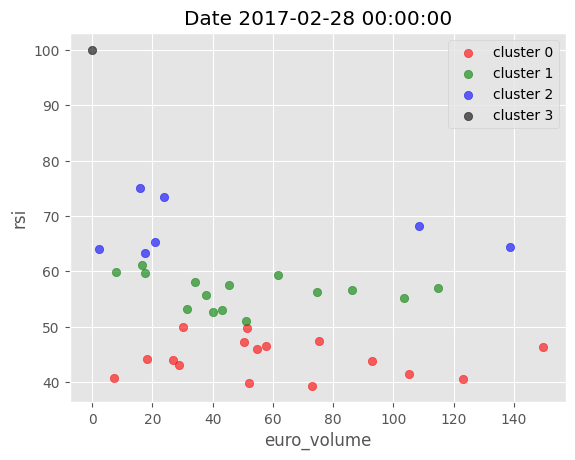

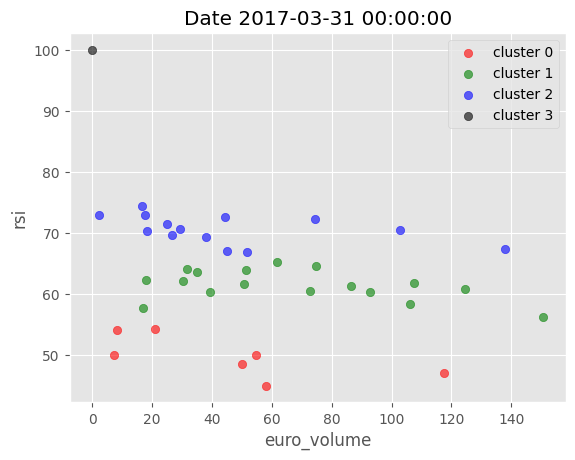

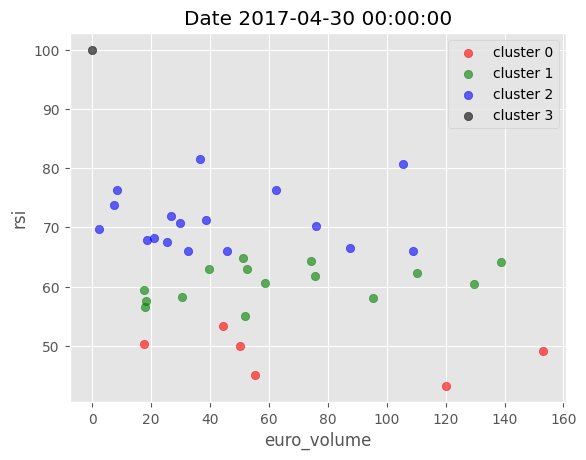

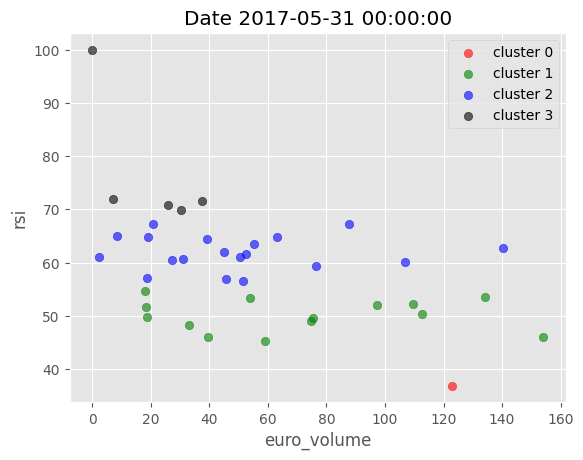

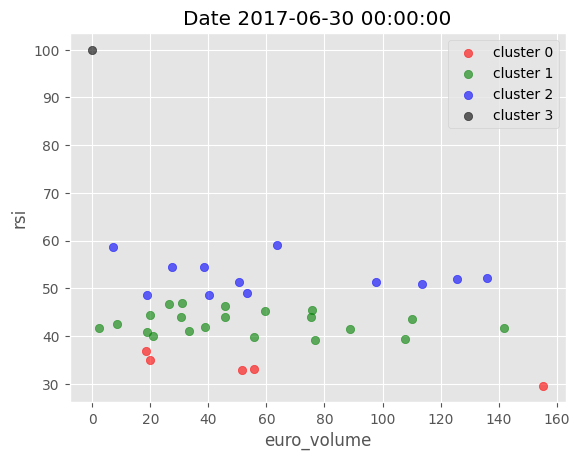

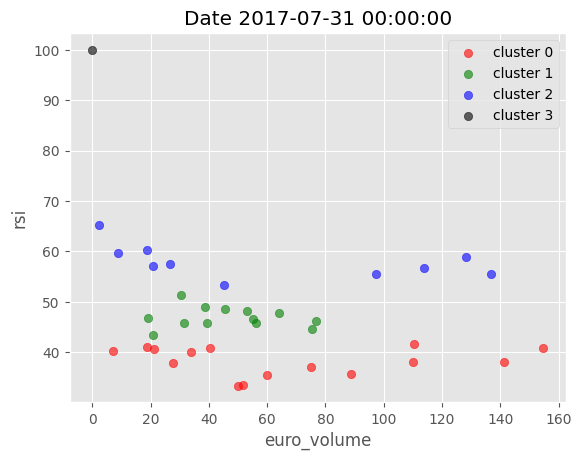

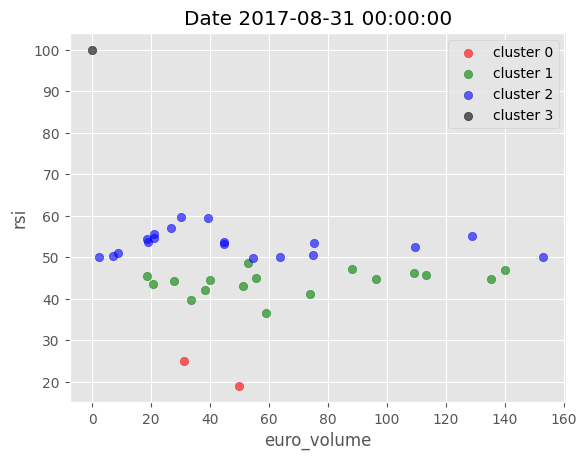

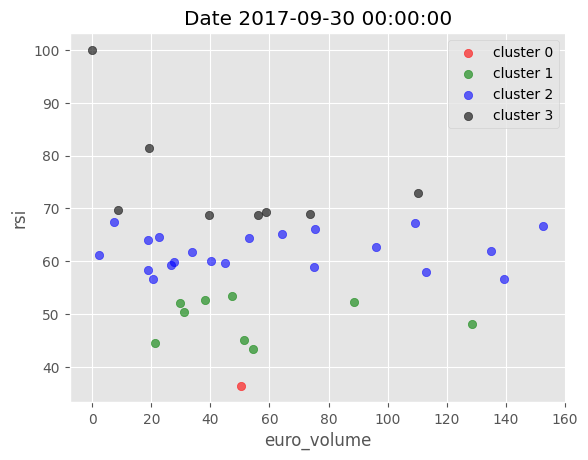

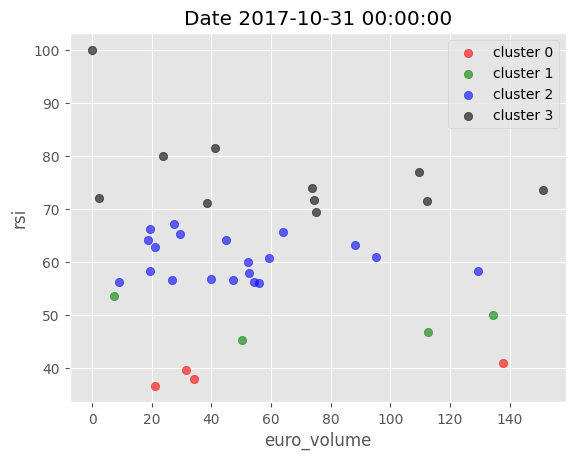

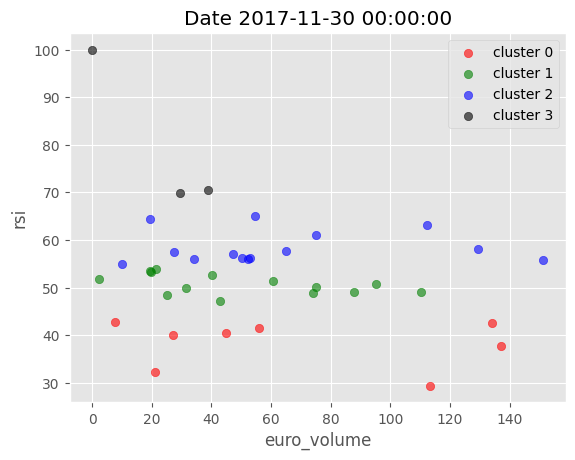

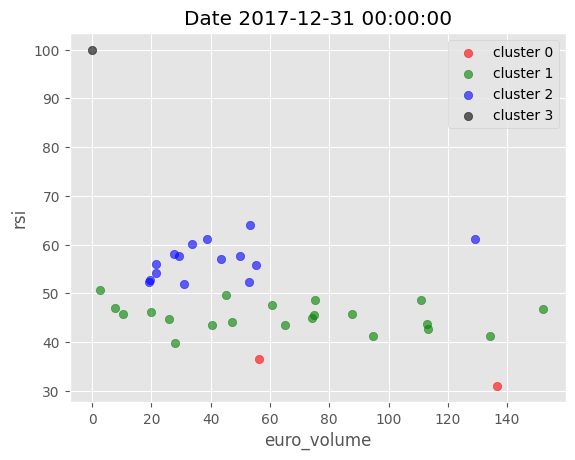

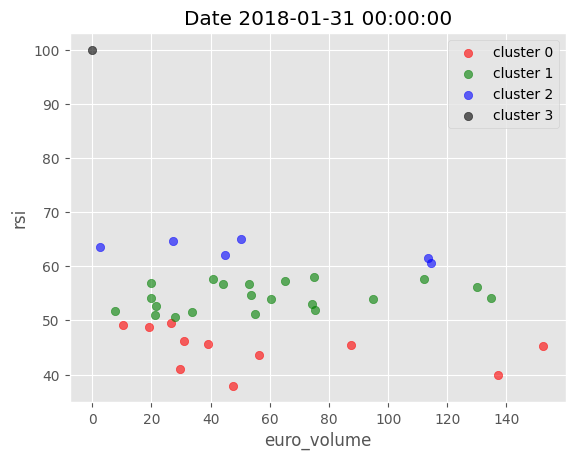

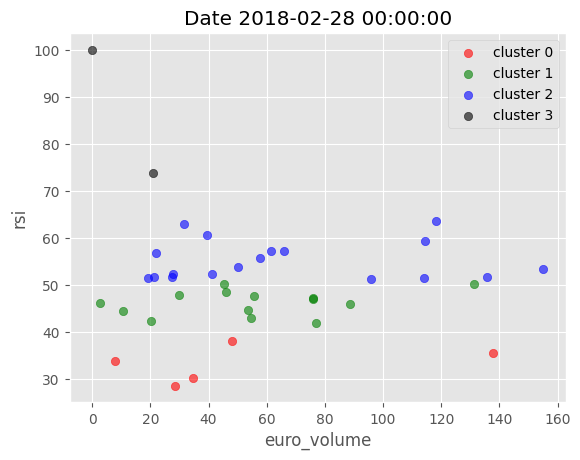

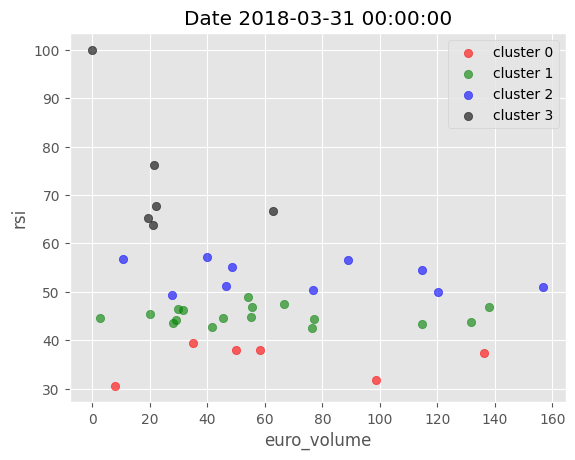

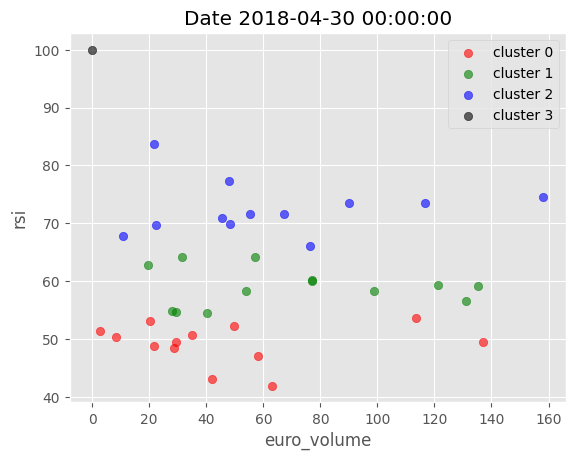

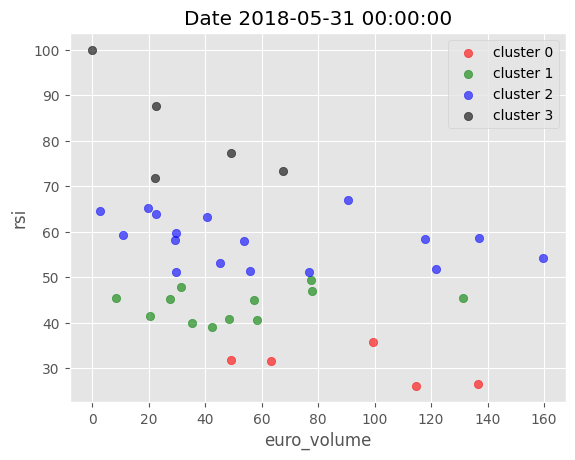

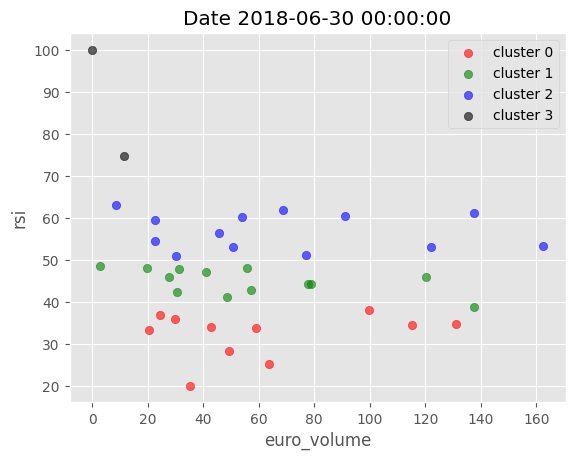

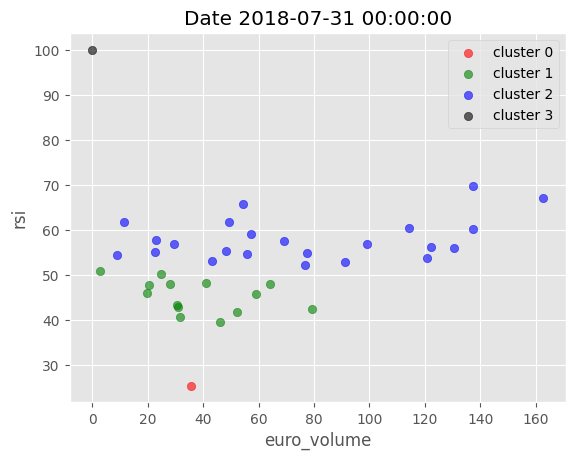

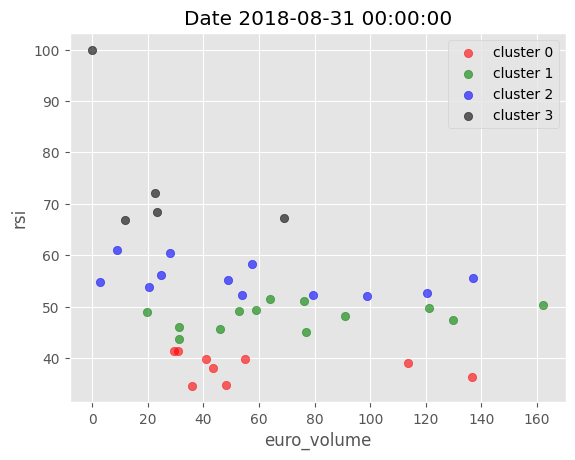

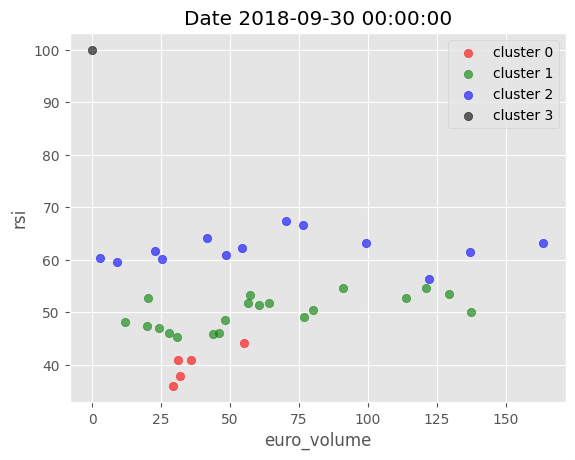

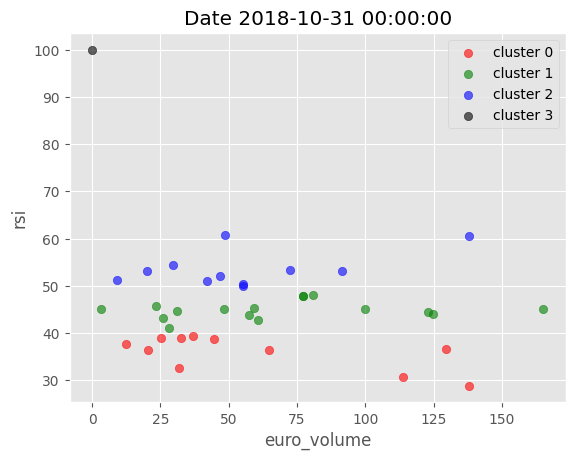

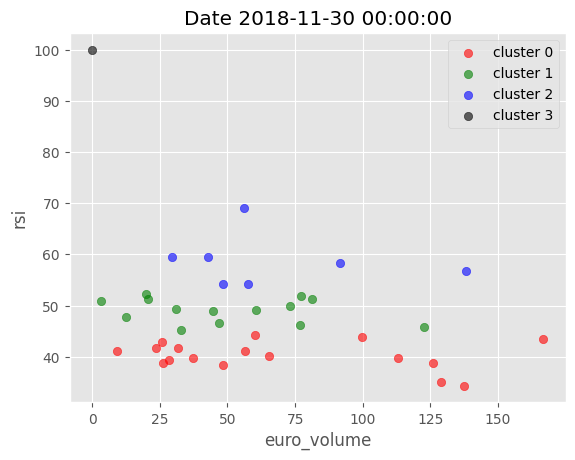

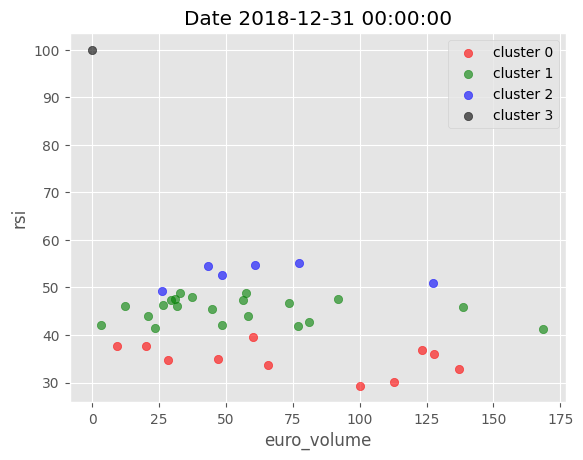

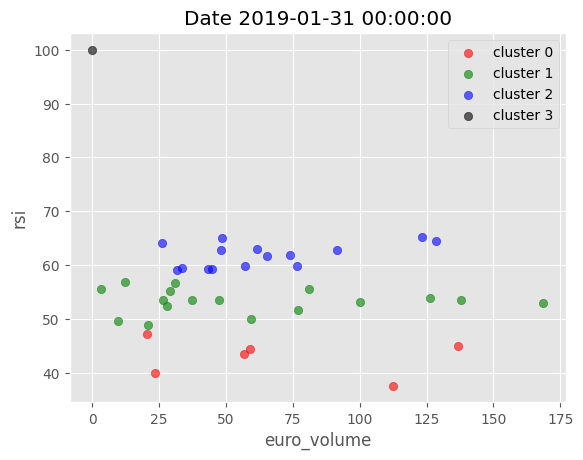

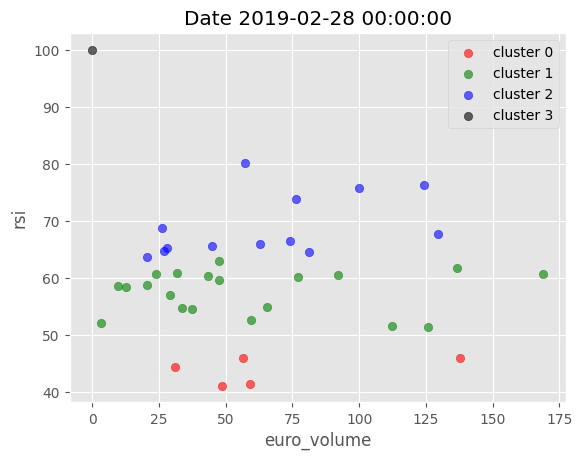

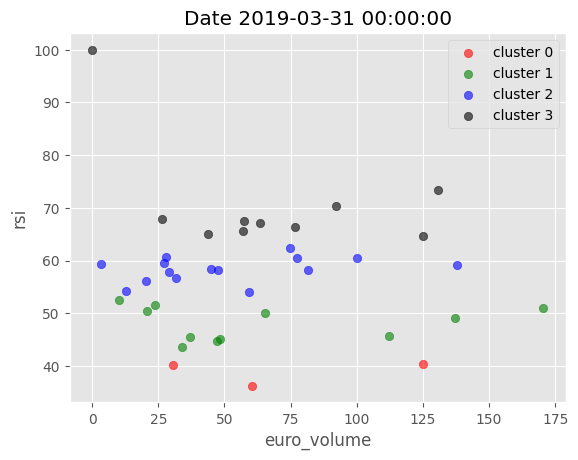

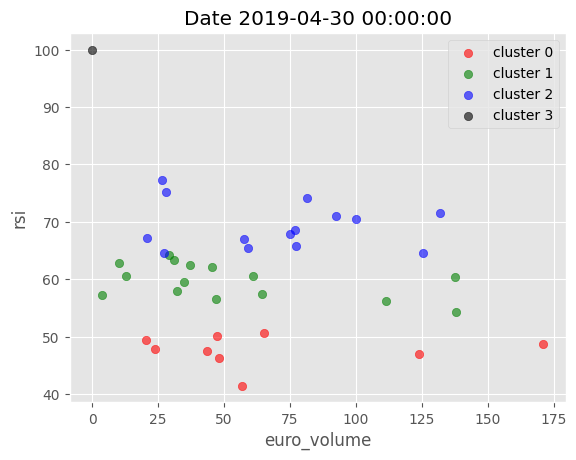

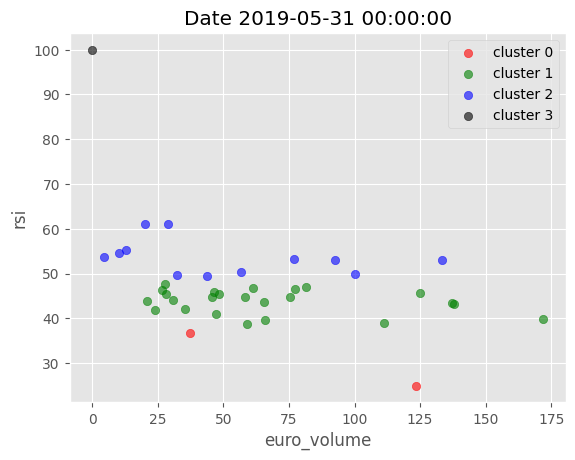

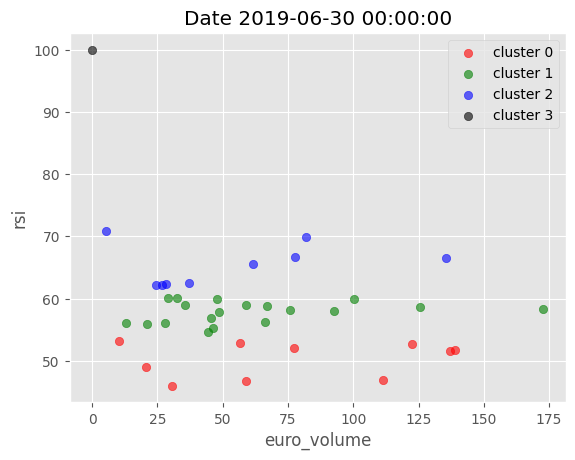

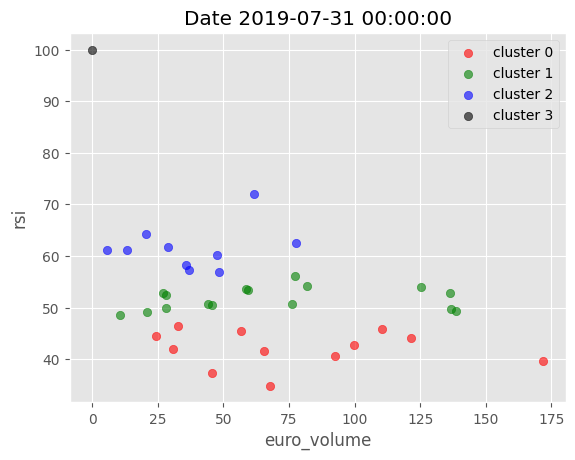

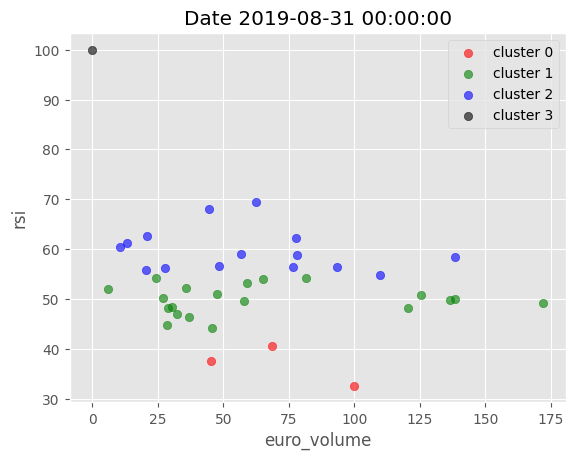

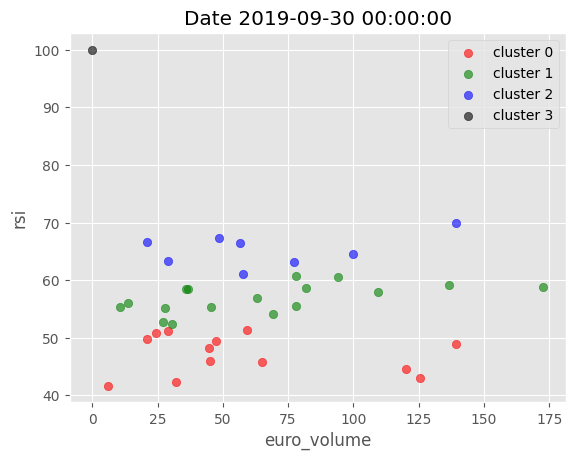

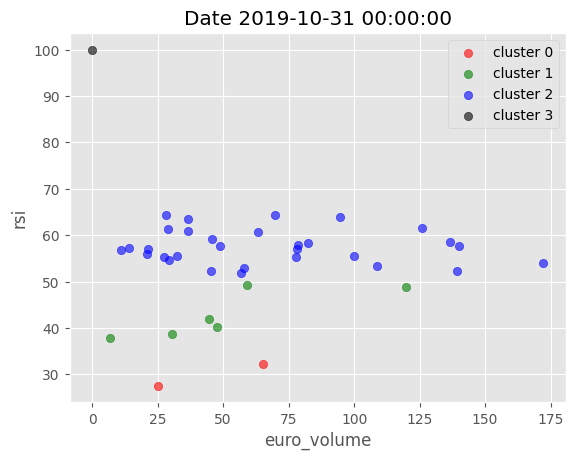

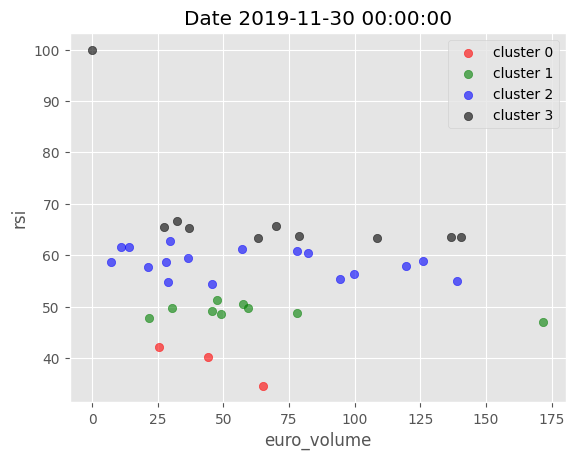

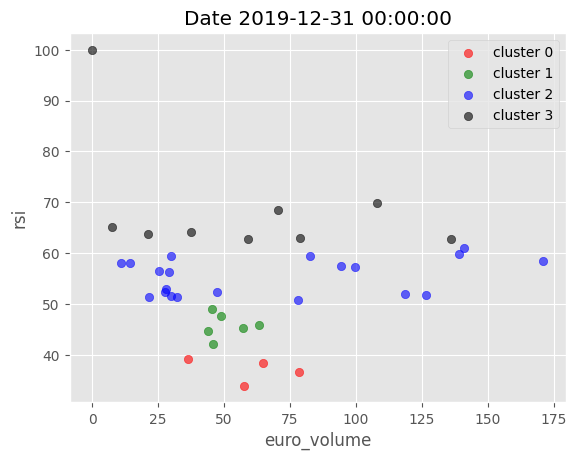

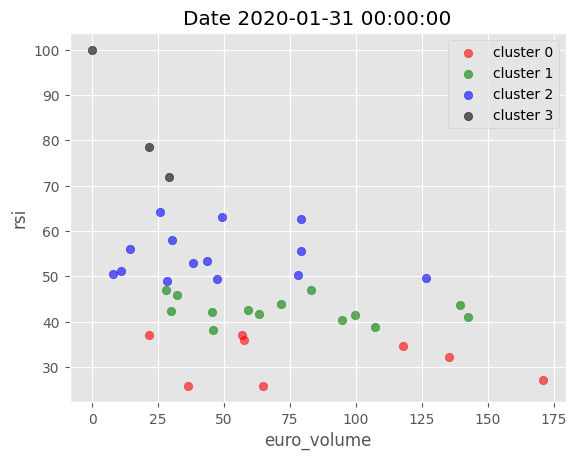

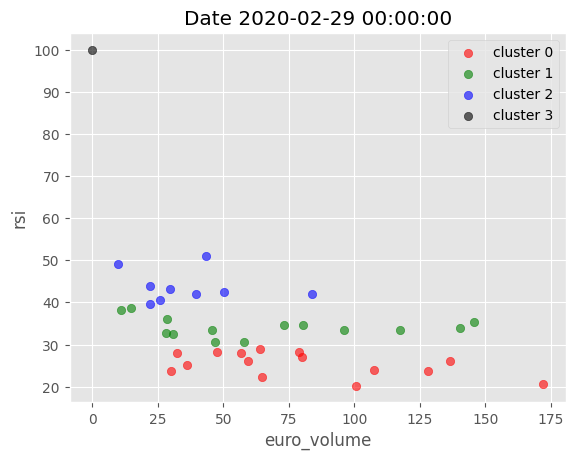

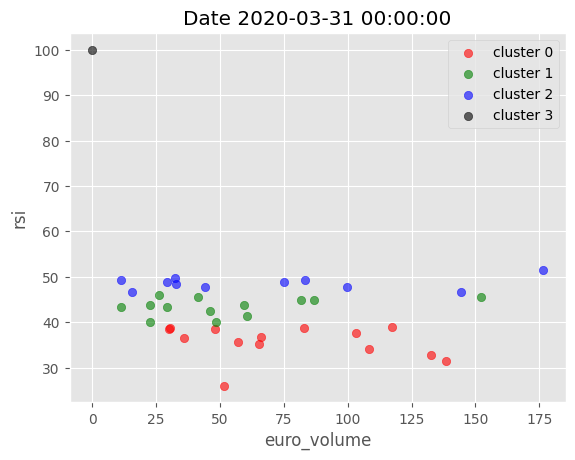

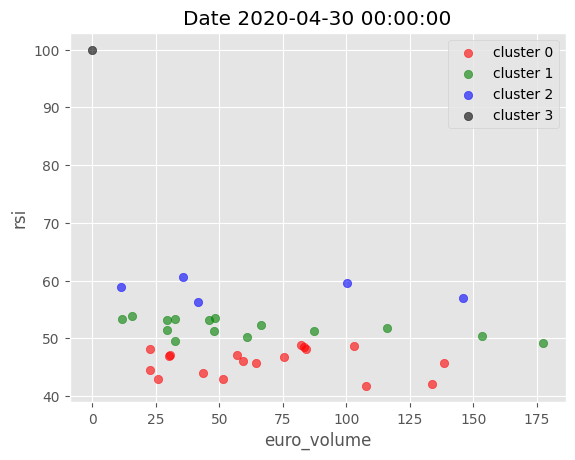

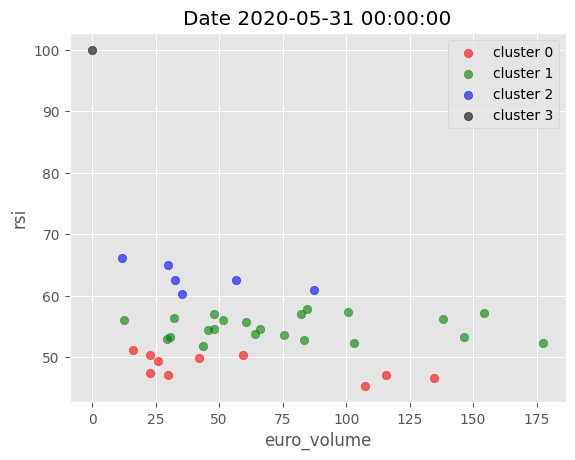

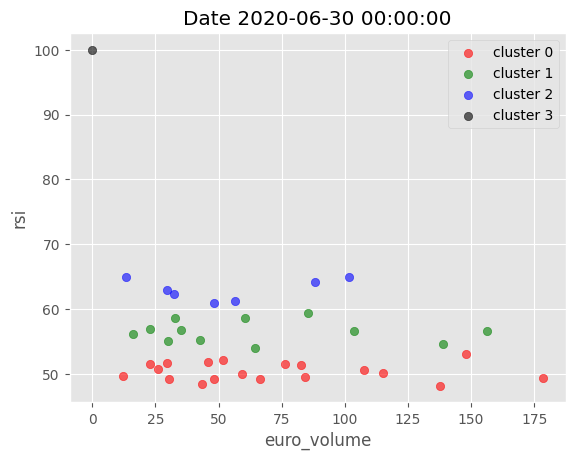

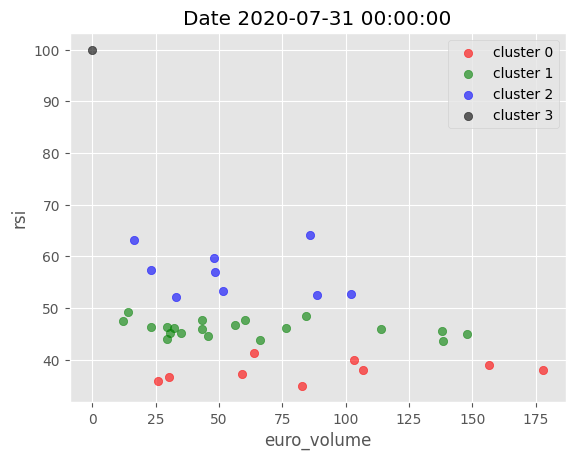

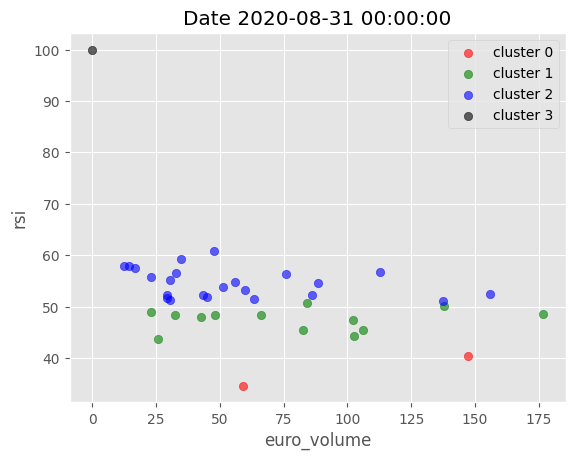

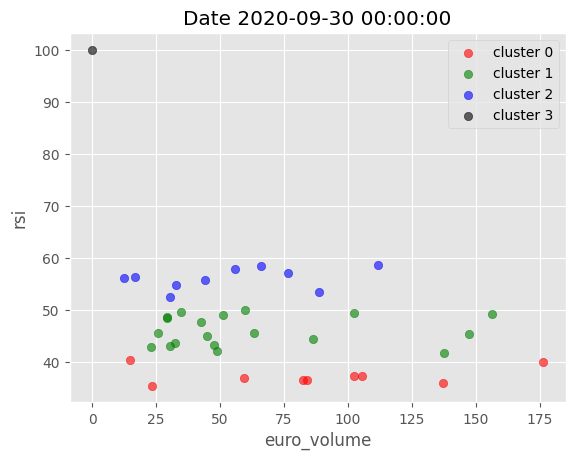

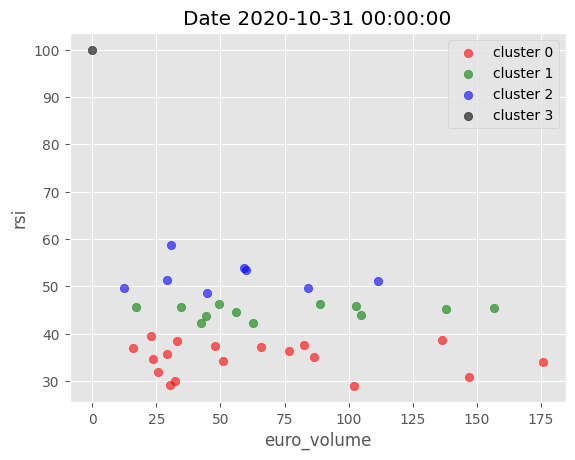

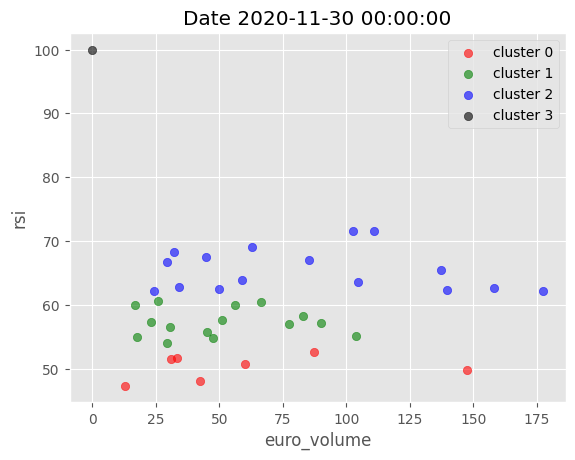

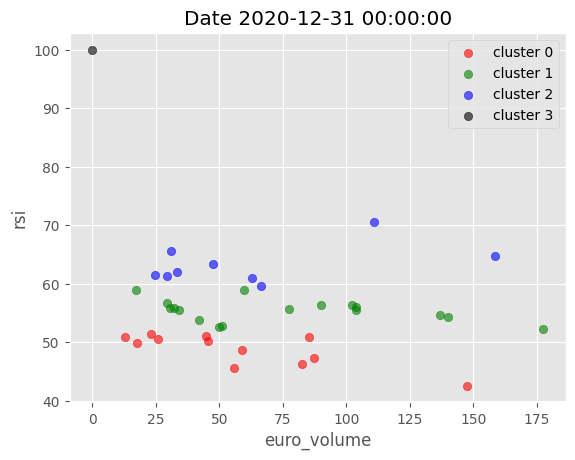

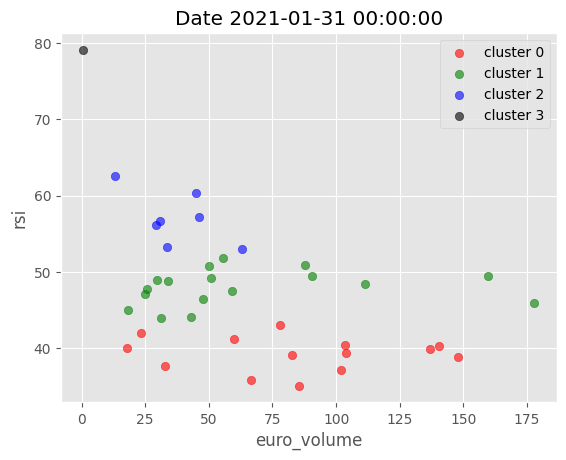

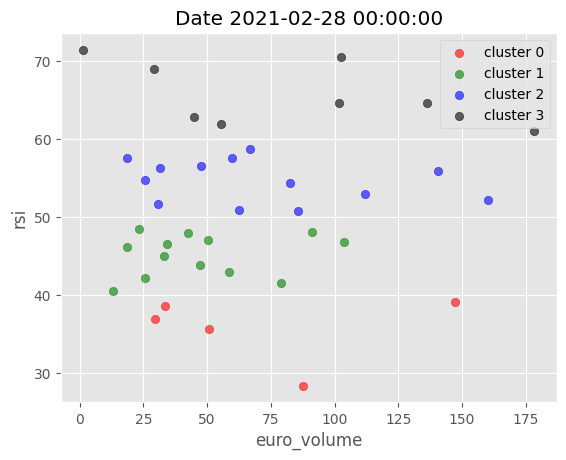

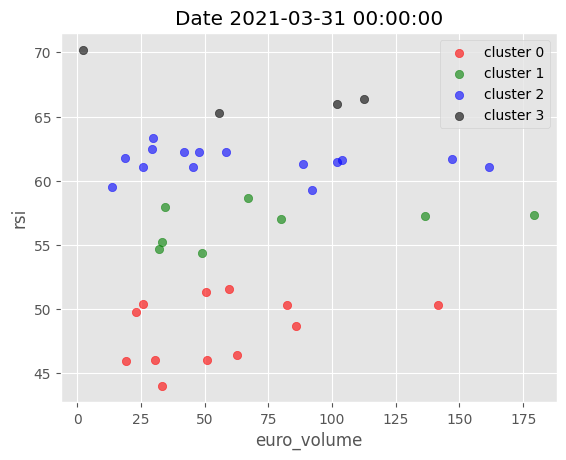

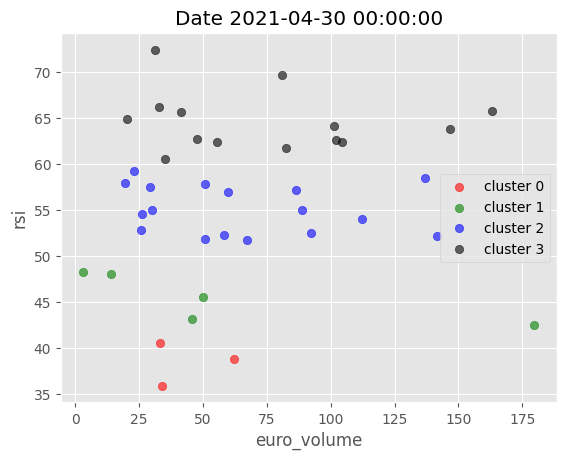

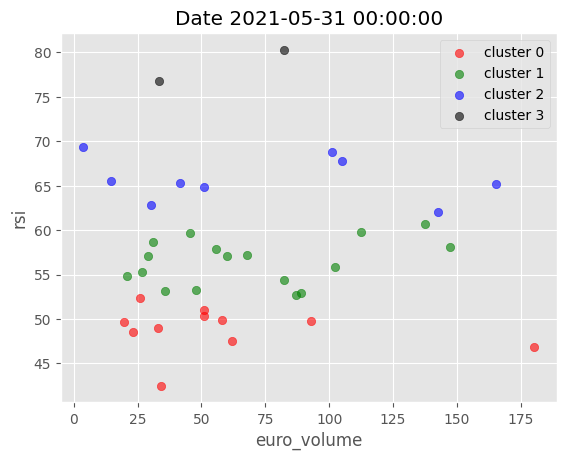

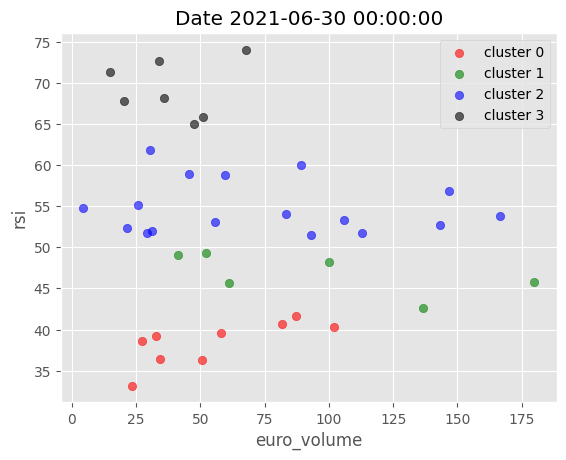

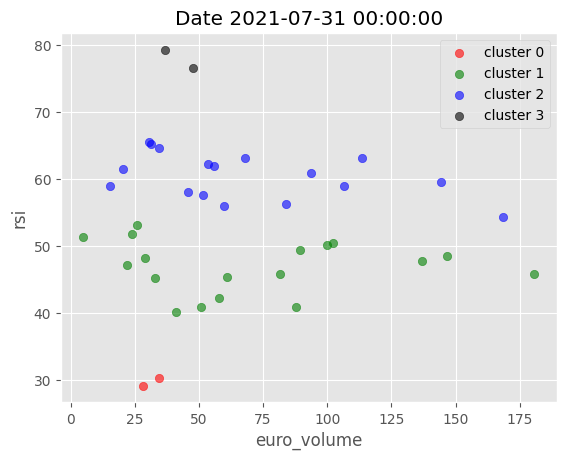

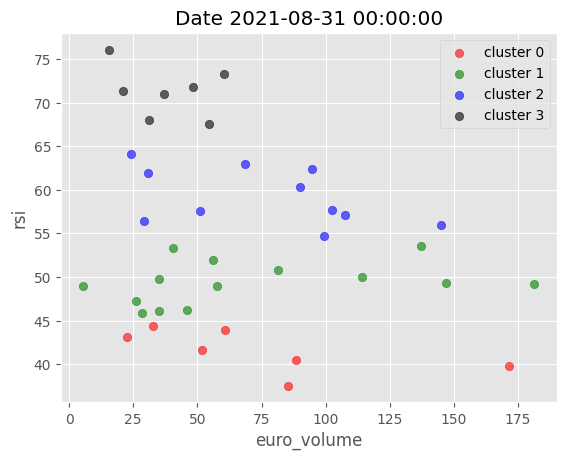

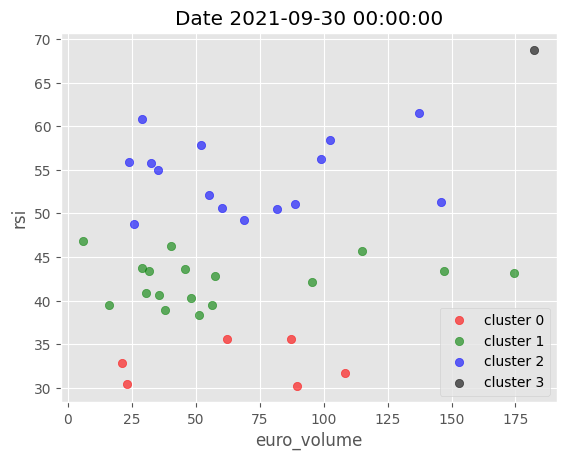

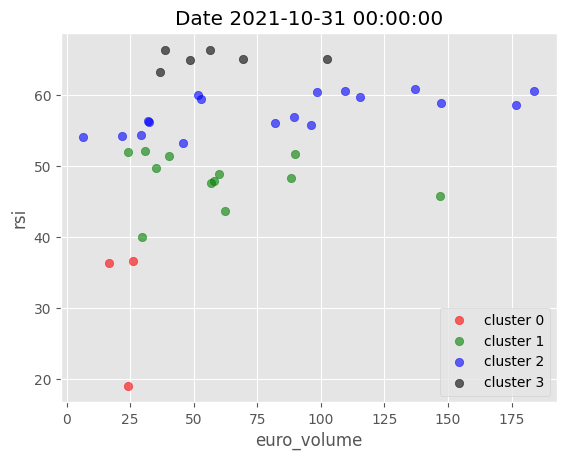

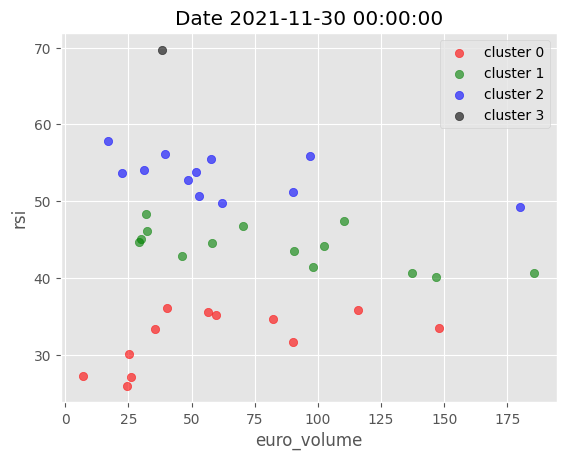

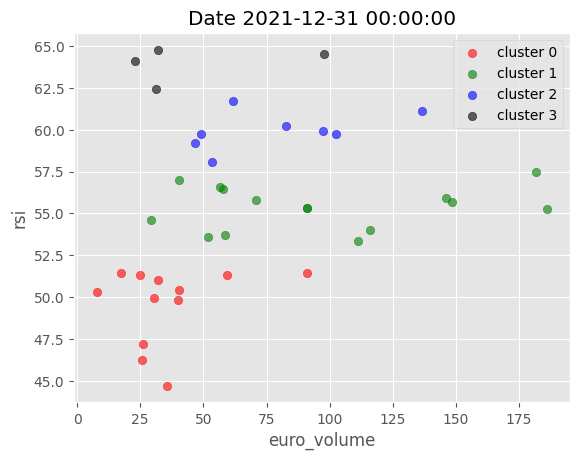

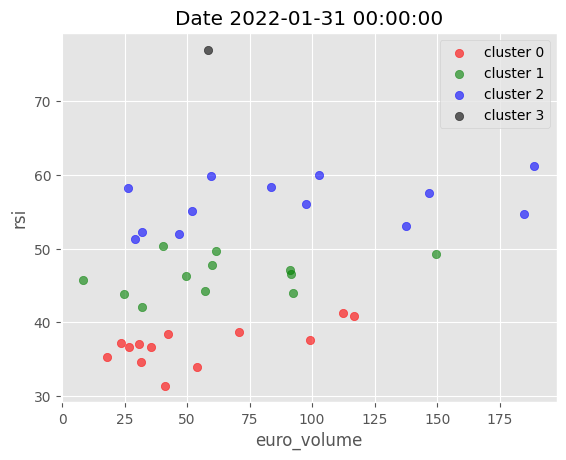

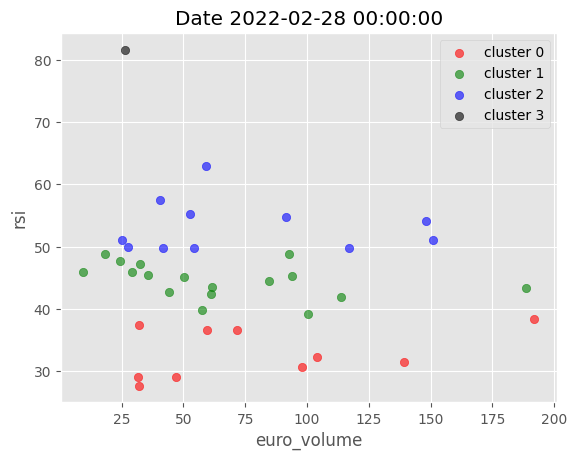

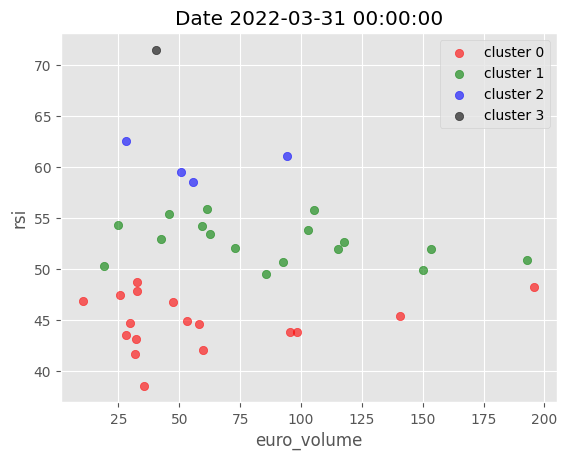

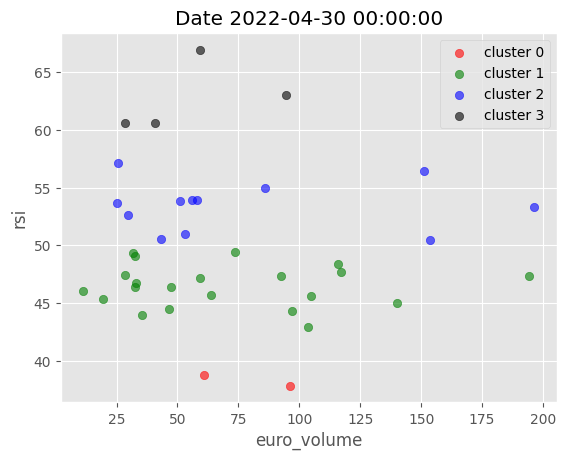

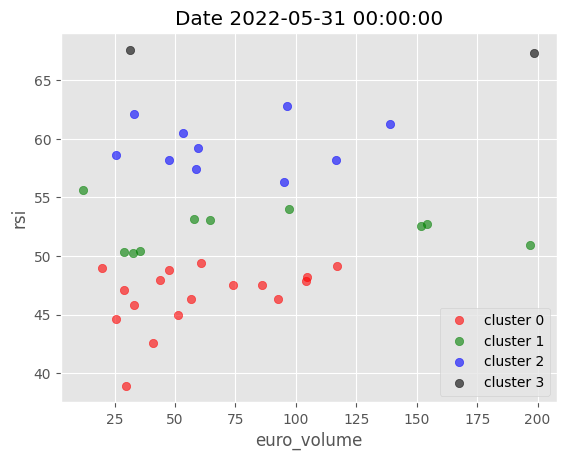

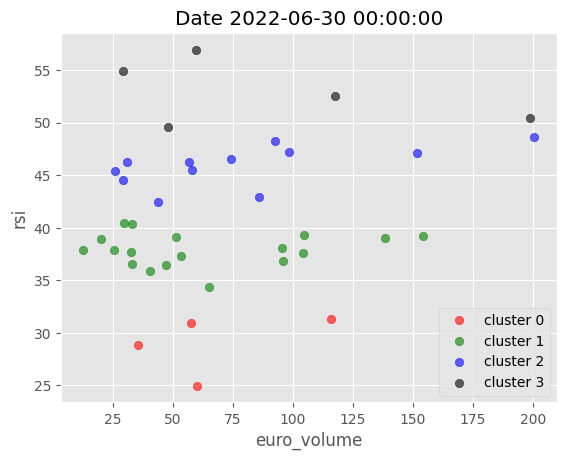

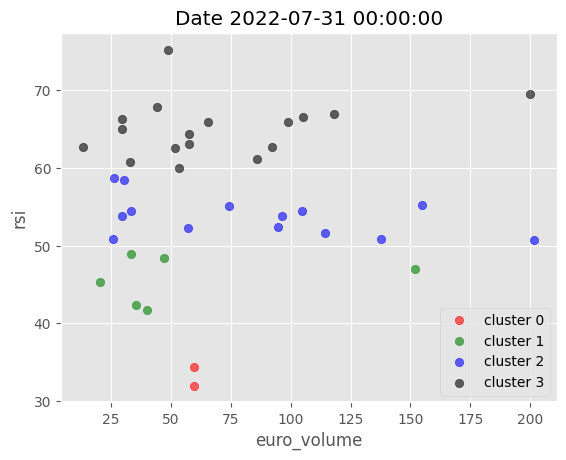

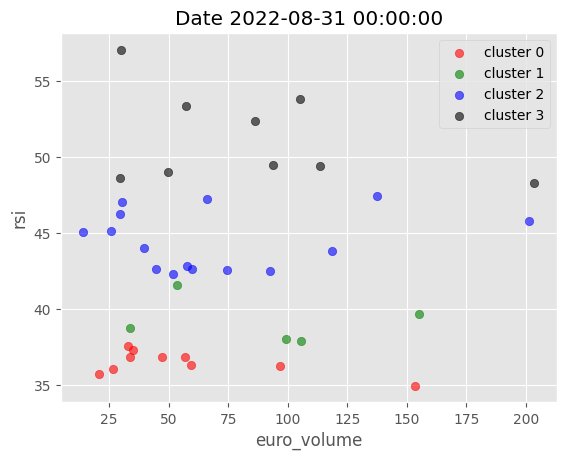

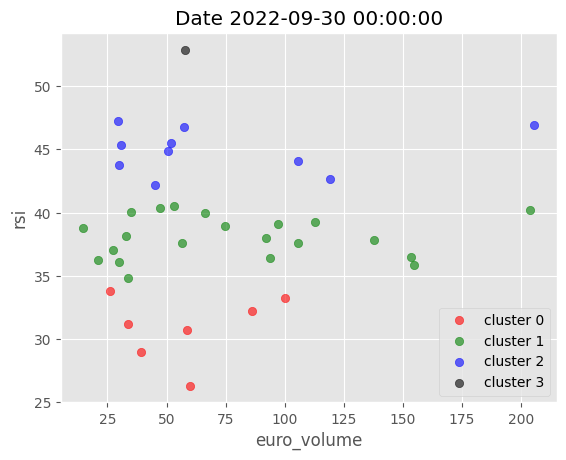

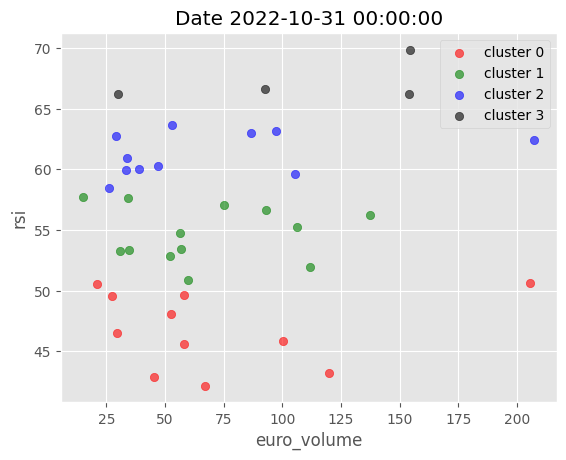

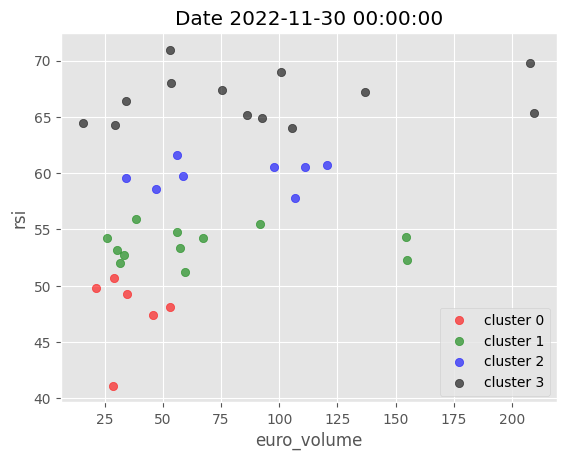

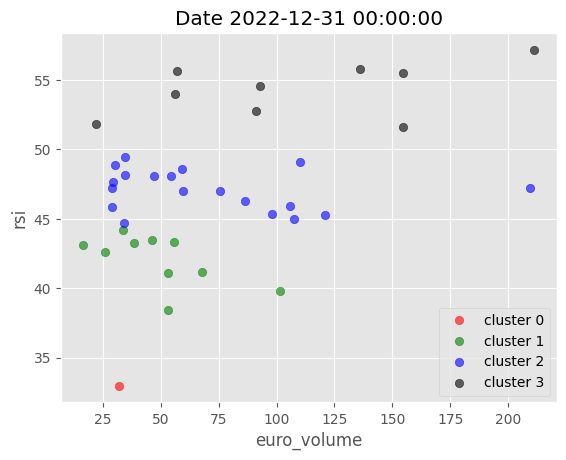

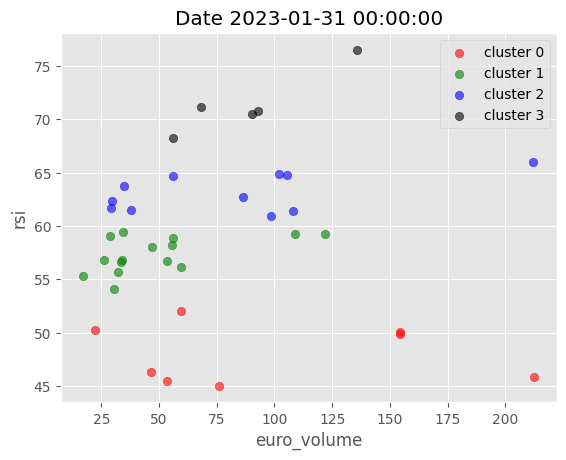

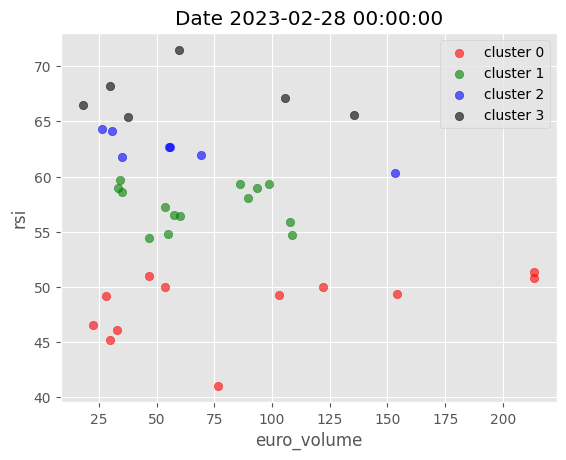

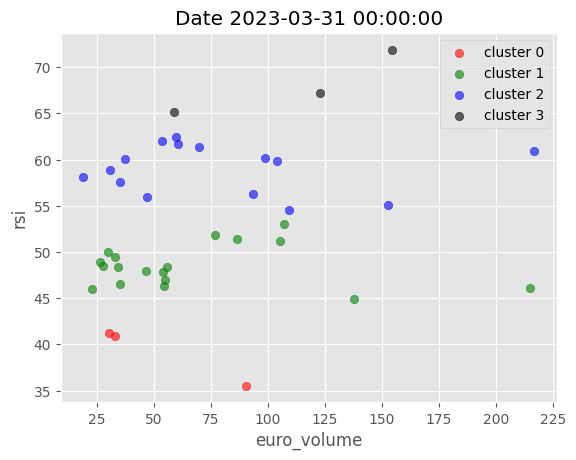

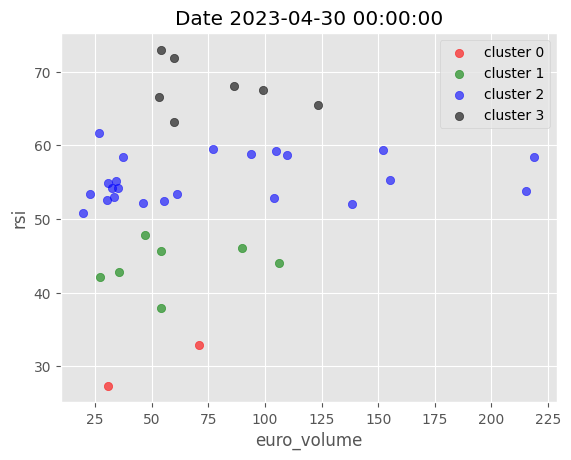

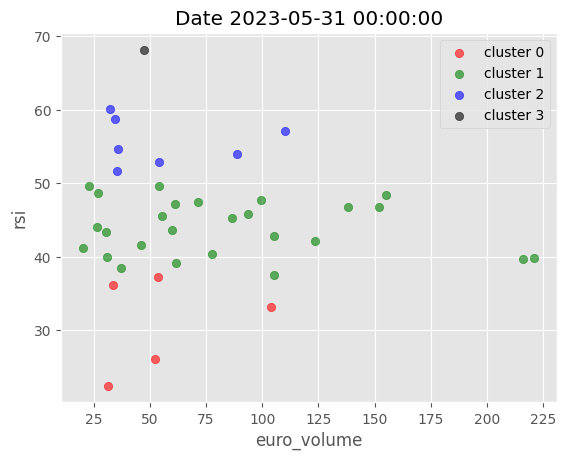

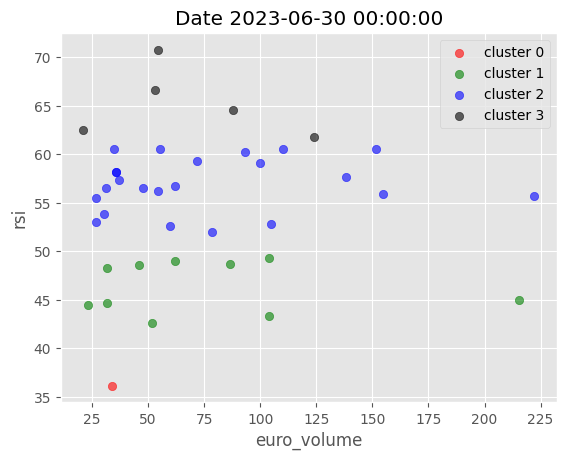

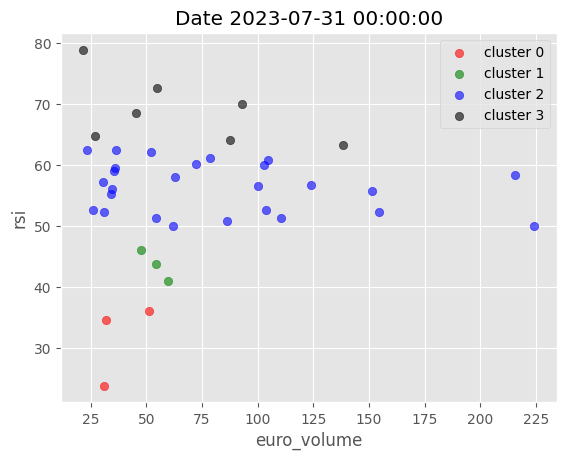

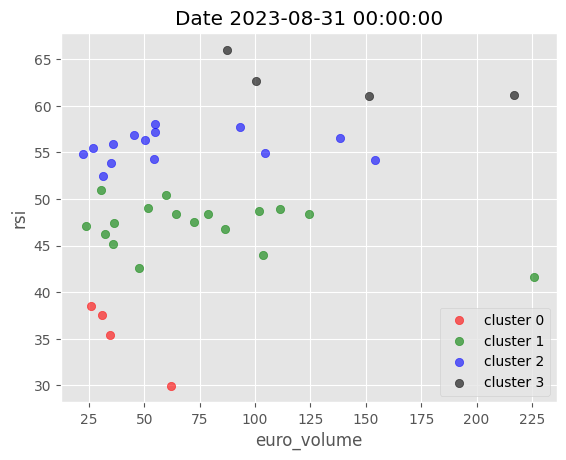

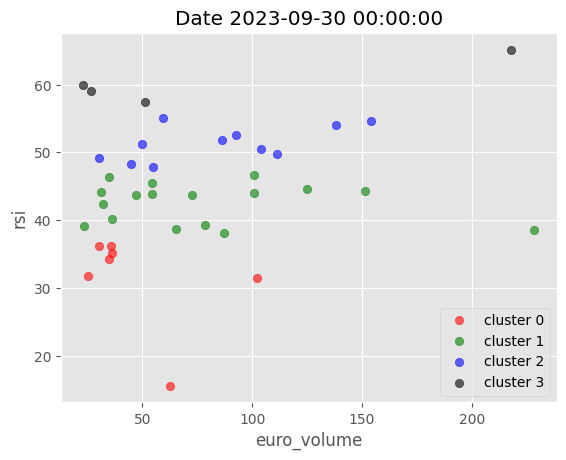

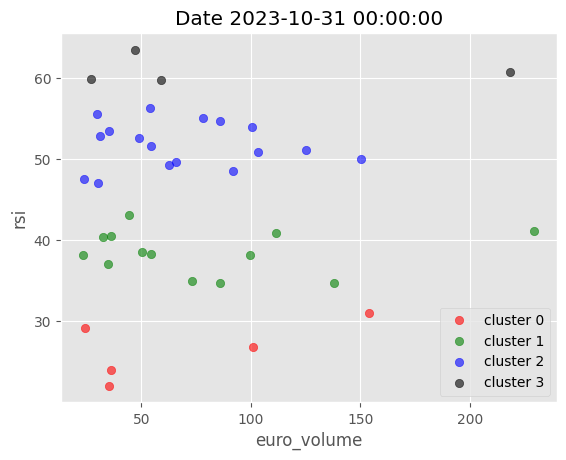

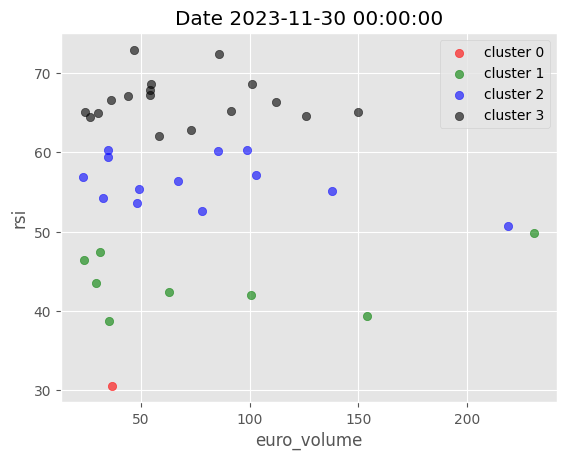

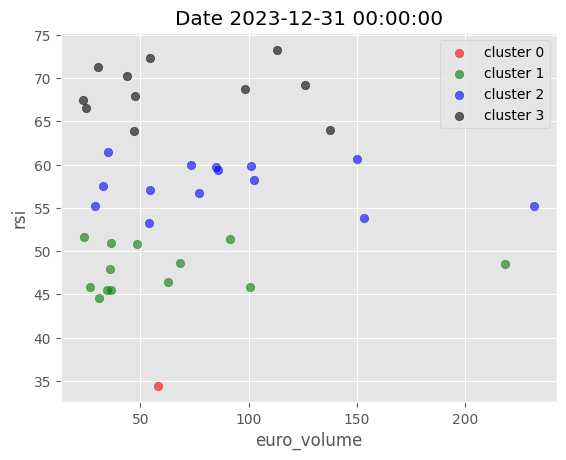

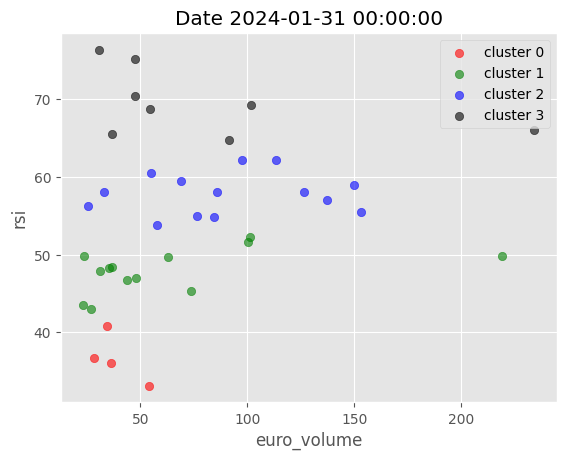

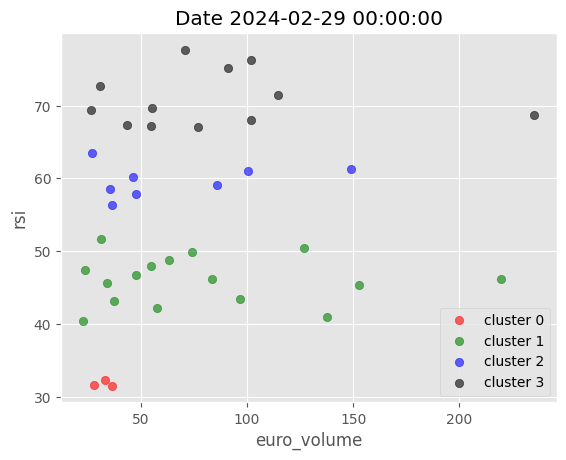

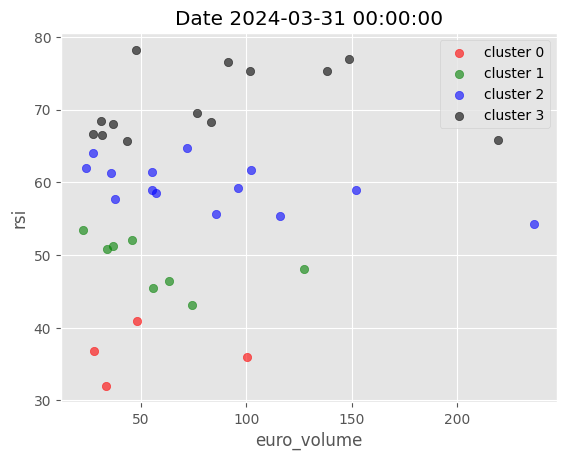

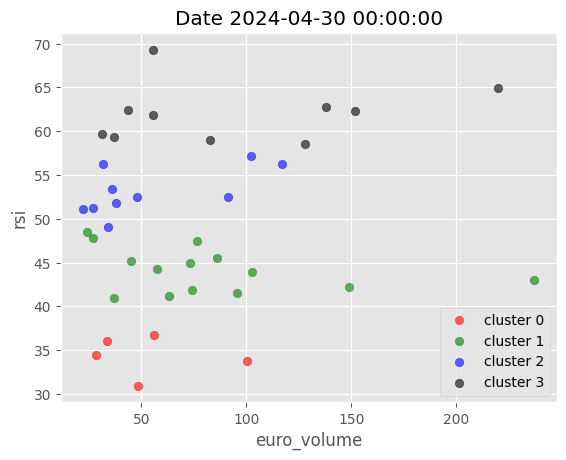

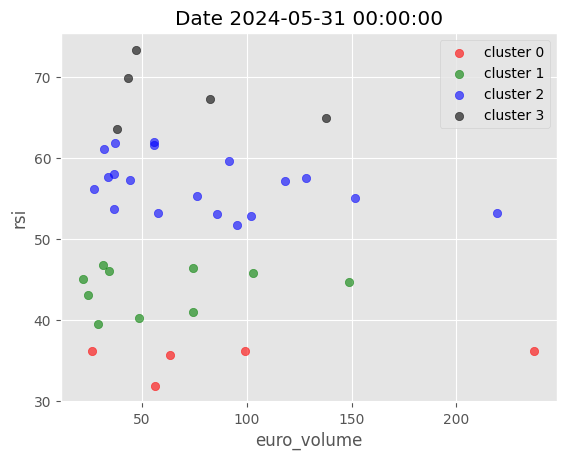

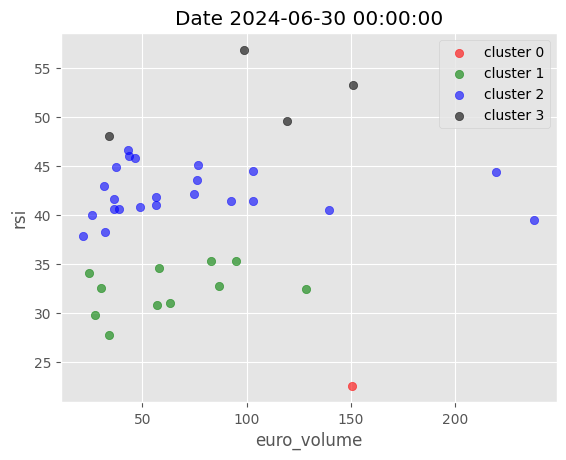

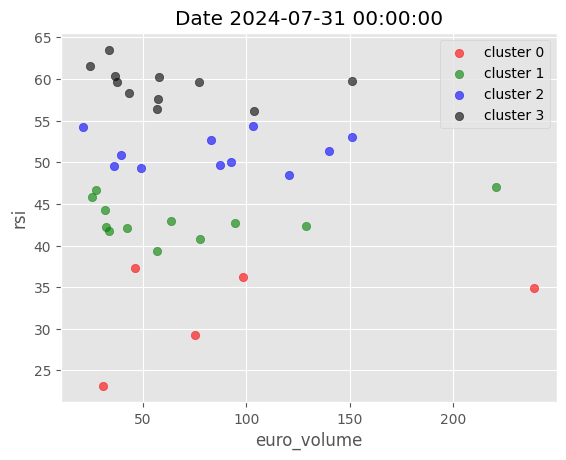

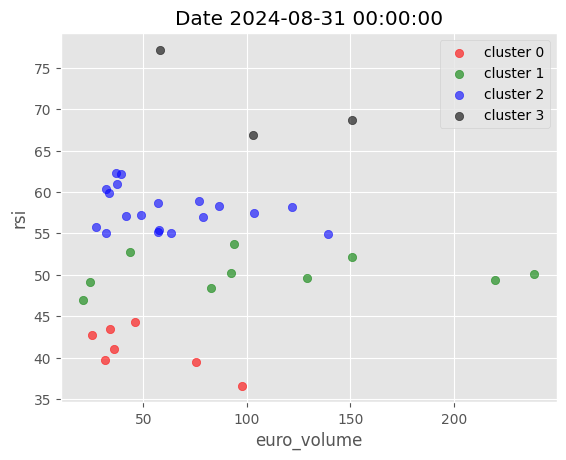

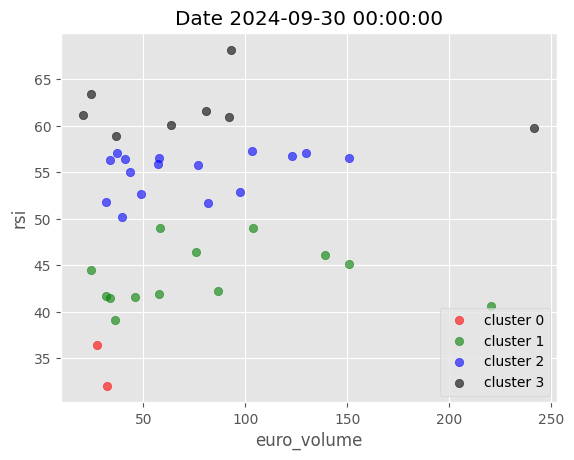

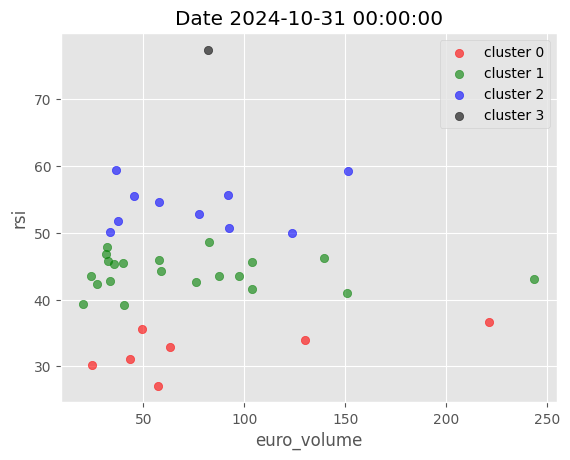

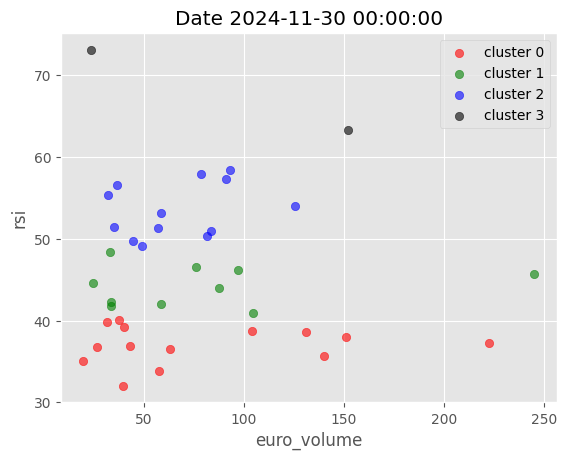

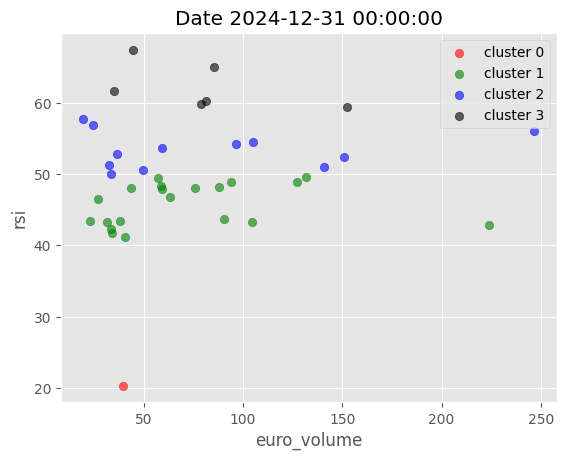

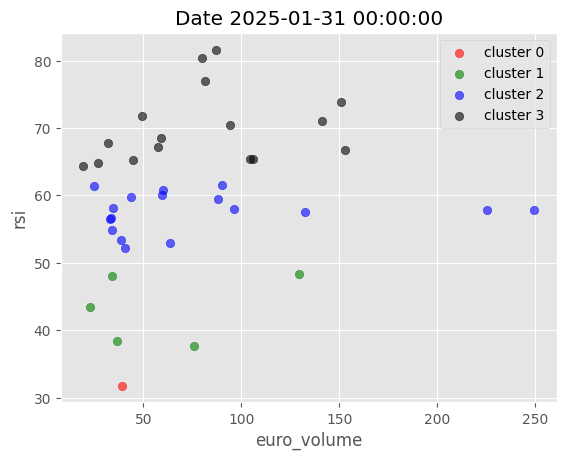

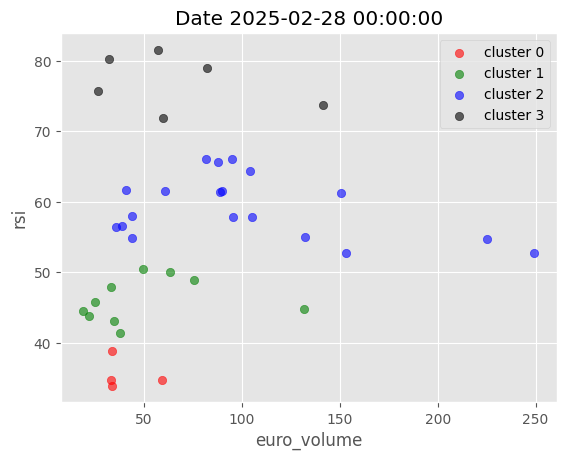

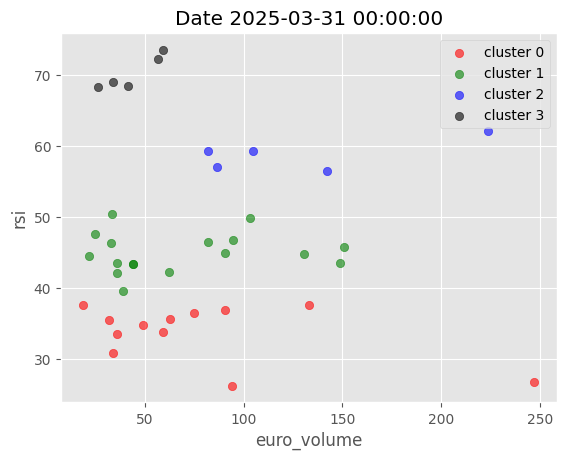

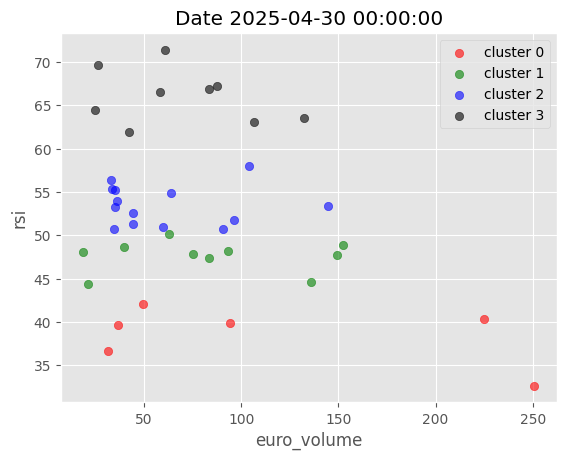

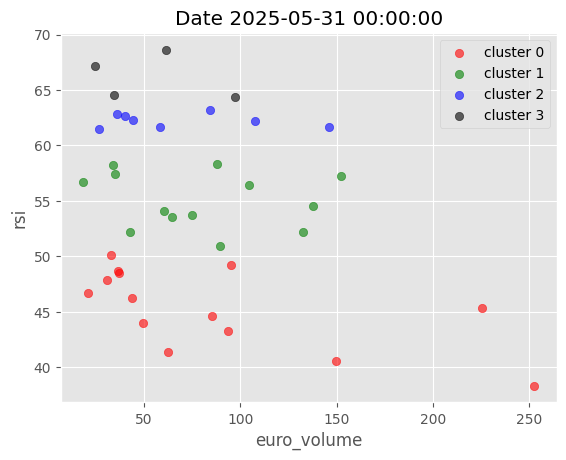

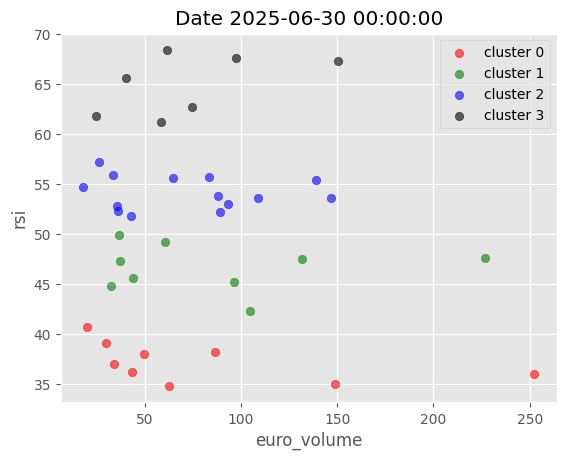

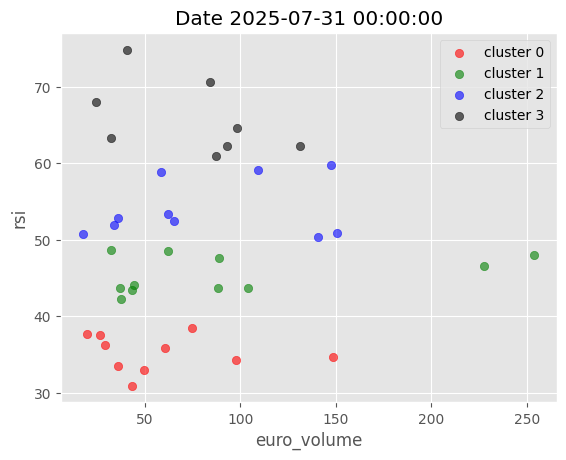

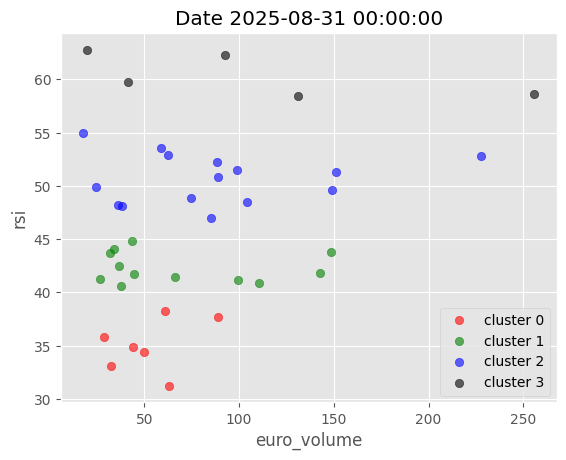

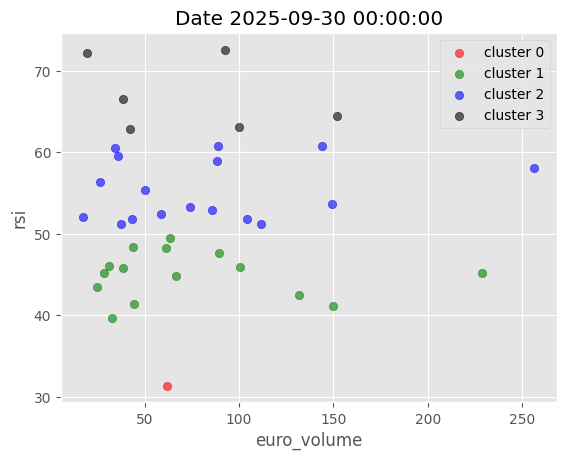

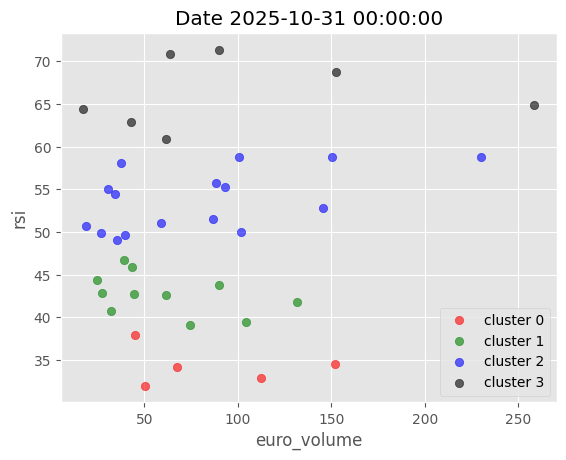

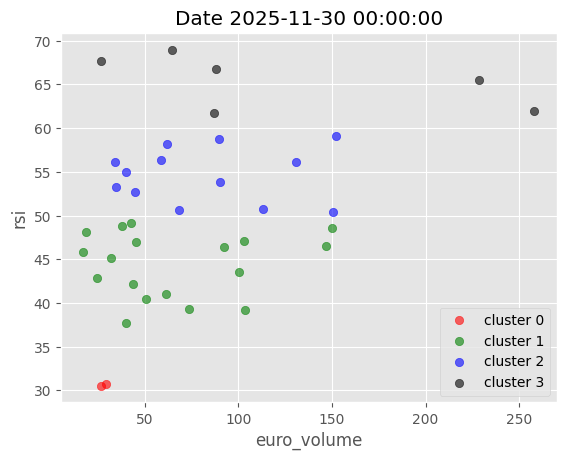

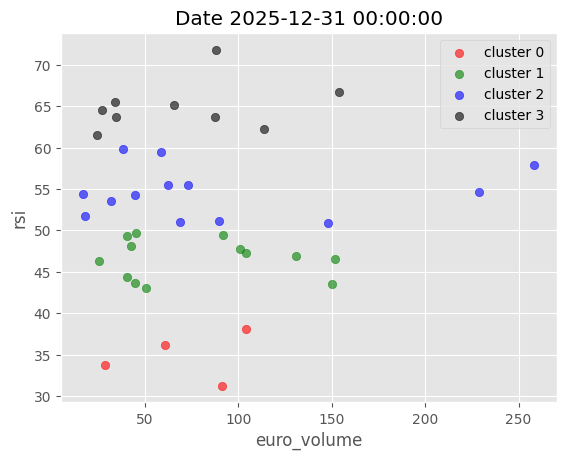

In [13]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]
    
    plt.scatter(cluster_0.iloc[:, 0], cluster_0.iloc[:, 2], color='red', label='cluster 0', alpha=0.6)
    plt.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:, 2], color='green', label='cluster 1', alpha=0.6)
    plt.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:, 2], color='blue', label='cluster 2', alpha=0.6)
    plt.scatter(cluster_3.iloc[:, 0], cluster_3.iloc[:, 2], color='black', label='cluster 3', alpha=0.6)
    
    plt.xlabel(data.columns[0])  # Nom de la colonne X
    plt.ylabel(data.columns[2])  # Nom de la colonne Y (RSI)
    plt.legend()
    plt.show()

# Plot pour chaque date
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)


## Prediction using Supervised ML

## XGBoost 


🎯 XGBOOST CLASSIFICATION - Prédiction Direction (Hausse/Baisse)
🔒 VERSION SANS LOOK-AHEAD BIAS (TARGET FUTURE)

🛠️ Préparation des données (Lag des variables macro)...
✅ Variables macro décalées (t-1).

🎯 Construction de la Target (Vision Future T+1)...
✅ Target 'future_return' créée.
📊 Distribution de la target :
   Baisse (0) : 1,902 (45.6%)
   Hausse (1) : 2,271 (54.4%)
   Ratio déséquilibre : 0.84:1

🔍 Nettoyage final :
   Lignes restantes : 4,171 (sur 4,173)

🔀 Split Train/Test :
   Train : 3,336
   Test  : 835

🔧 Entraînement XGBoost...
✅ Modèle entraîné (Best Iteration: 26)

📈 RÉSULTATS RÉELS (SANS TRICHE)
🎯 AUC Train : 0.7514
🎯 AUC Test  : 0.5859
📊 Accuracy  : 56.77%

✅ VALIDE : Le modèle bat le hasard (Alpha détecté).

📋 Classification Report :

              precision    recall  f1-score   support

           0     0.5409    0.5995    0.5687       397
           1     0.5975    0.5388    0.5666       438

    accuracy                         0.5677       835
   macro avg    

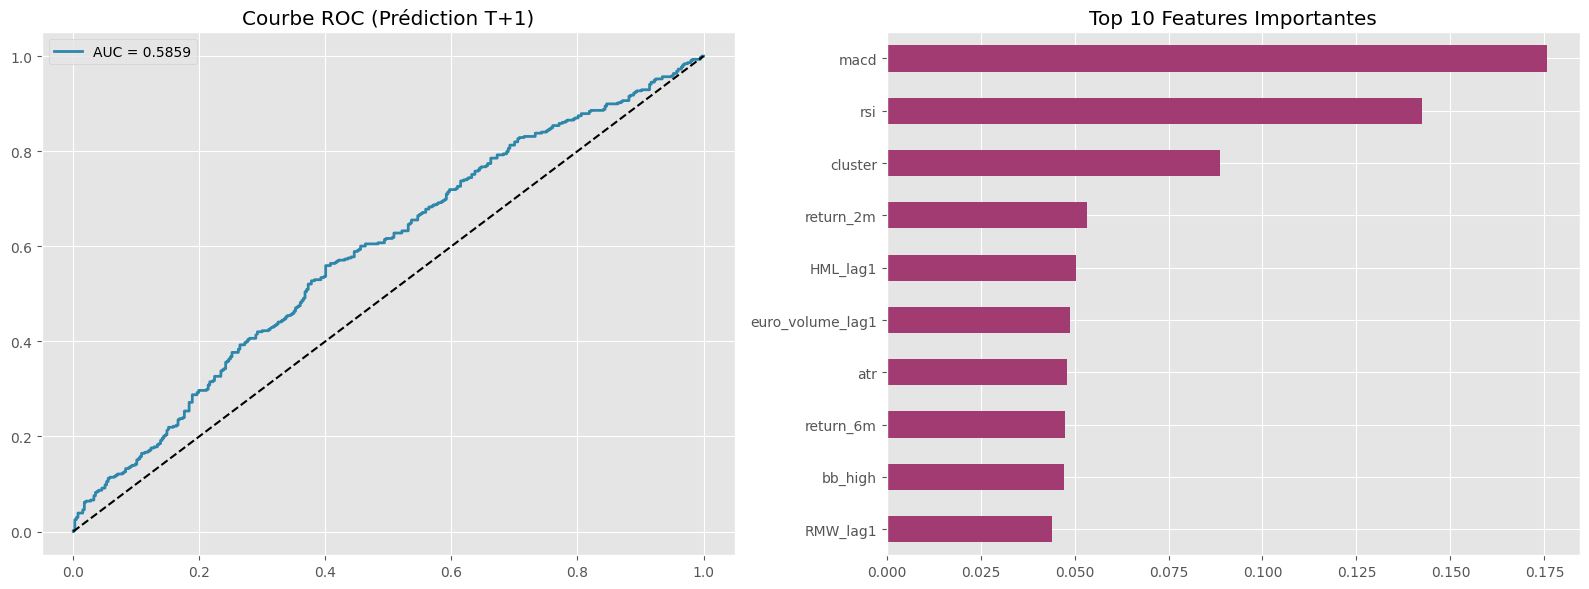

In [14]:
# =============================================================================
# XGBOOST CLASSIFICATION - VERSION FINALE (CORRIGÉE & VALIDÉE)
# =============================================================================

print("\n" + "="*70)
print("🎯 XGBOOST CLASSIFICATION - Prédiction Direction (Hausse/Baisse)")
print("🔒 VERSION SANS LOOK-AHEAD BIAS (TARGET FUTURE)")
print("="*70)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =============================================================================
# 1. INITIALISATION & LAG DES FEATURES
# =============================================================================
print("\n🛠️ Préparation des données (Lag des variables macro)...")

# On travaille sur une copie propre
ml_data = data.copy()

# Variables macro/volume à décaler (car connues seulement à la fin du mois)
vars_to_lag = [
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA',
    'euro_volume', 'garman_klass_vol'
]

# Application du décalage (Lag 1)
# Gestion automatique selon si l'index est MultiIndex ou non
if 'Ticker' in ml_data.index.names:
    group_obj = ml_data.groupby(level='Ticker')
elif 'Ticker' in ml_data.columns:
    group_obj = ml_data.groupby('Ticker')
else:
    group_obj = None

for col in vars_to_lag:
    if col in ml_data.columns:
        if group_obj is not None:
            ml_data[f'{col}_lag1'] = group_obj[col].shift(1)
        else:
            ml_data[f'{col}_lag1'] = ml_data[col].shift(1)

print(f"✅ Variables macro décalées (t-1).")

# =============================================================================
# 2. CRÉATION DE LA TARGET (CORRECTION CRUCIALE ICI)
# =============================================================================
print(f"\n🎯 Construction de la Target (Vision Future T+1)...")

# C'est ICI que tout se joue :
# On veut prédire le rendement du MOIS PROCHAIN.
# On prend le 'return_1m' de la ligne SUIVANTE (shift -1).

if group_obj is not None:
    ml_data['future_return'] = group_obj['return_1m'].shift(-1)
else:
    ml_data['future_return'] = ml_data['return_1m'].shift(-1)

# La target est : Est-ce que le return FUTUR sera positif ?
ml_data['target_direction'] = (ml_data['future_return'] > 0).astype(int)

print(f"✅ Target 'future_return' créée.")
print(f"📊 Distribution de la target :")
counts = ml_data['target_direction'].value_counts()
print(f"   Baisse (0) : {counts[0]:,} ({counts[0]/len(ml_data)*100:.1f}%)")
print(f"   Hausse (1) : {counts[1]:,} ({counts[1]/len(ml_data)*100:.1f}%)")

imbalance_ratio = counts[0] / counts[1]
print(f"   Ratio déséquilibre : {imbalance_ratio:.2f}:1")

# =============================================================================
# 3. PRÉPARATION DES FEATURES
# =============================================================================

# Liste des features (avec les versions _lag1 pour la macro)
feature_cols = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr',          # Tech (T)
    'return_2m', 'return_3m', 'return_6m',              # Momentum Passé (T)
    'euro_volume_lag1', 'garman_klass_vol_lag1',        # Volume (T-1)
    'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1', 'RMW_lag1', 'CMA_lag1', # Macro (T-1)
    'cluster'
]

# Nettoyage : On supprime les lignes où :
# 1. Les Lags ont créé des NaN (début d'historique)
# 2. La Target future est NaN (fin d'historique)
ml_data_clean = ml_data.dropna(subset=feature_cols + ['future_return']).copy()

print(f"\n🔍 Nettoyage final :")
print(f"   Lignes restantes : {len(ml_data_clean):,} (sur {len(ml_data):,})")

# =============================================================================
# 4. SPLIT TEMPOREL (80/20)
# =============================================================================

X = ml_data_clean[feature_cols]
y = ml_data_clean['target_direction']

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\n🔀 Split Train/Test :")
print(f"   Train : {len(X_train):,}")
print(f"   Test  : {len(X_test):,}")

# =============================================================================
# 5. ENTRAÎNEMENT XGBOOST
# =============================================================================

print(f"\n🔧 Entraînement XGBoost...")

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,             # Profondeur limitée pour éviter le par-cœur
    learning_rate=0.03,      # Apprentissage lent
    subsample=0.7,
    colsample_bytree=0.7,
    scale_pos_weight=imbalance_ratio,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=30,
    eval_metric='auc'
)

xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"✅ Modèle entraîné (Best Iteration: {xgb_clf.best_iteration})")

# =============================================================================
# 6. ÉVALUATION
# =============================================================================

y_pred_proba_test = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_class_test = xgb_clf.predict(X_test)

auc_train = roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])
auc_test = roc_auc_score(y_test, y_pred_proba_test)
accuracy_test = (y_pred_class_test == y_test).mean()

print(f"\n" + "="*70)
print("📈 RÉSULTATS RÉELS (SANS TRICHE)")
print("="*70)

print(f"🎯 AUC Train : {auc_train:.4f}")
print(f"🎯 AUC Test  : {auc_test:.4f}")
print(f"📊 Accuracy  : {accuracy_test*100:.2f}%")

if auc_test > 0.53:
    print("\n✅ VALIDE : Le modèle bat le hasard (Alpha détecté).")
elif auc_test > 0.50:
    print("\n⚠️ NEUTRE : Signal faible, difficile à exploiter seul.")
else:
    print("\n❌ INVALIDE : Aucune capacité prédictive avec ces features.")

print(f"\n📋 Classification Report :\n")
print(classification_report(y_test, y_pred_class_test, digits=4))

# =============================================================================
# 7. VISUALISATIONS
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
axes[0].plot(fpr, tpr, lw=2, label=f'AUC = {auc_test:.4f}', color='#2E86AB')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title('Courbe ROC (Prédiction T+1)')
axes[0].legend()

# Features
importances = pd.Series(xgb_clf.feature_importances_, index=feature_cols).sort_values(ascending=False).head(10)
importances.plot(kind='barh', ax=axes[1], color='#A23B72')
axes[1].set_title('Top 10 Features Importantes')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

Cross -validation

In [15]:
# =============================================================================
# OPTIMISATION DES HYPERPARAMÈTRES (POUR BATTRE 55.3%)
# =============================================================================
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

print("\n" + "="*70)
print("⚙️ OPTIMISATION DU MODÈLE (GRID SEARCH)")
print("="*70)

# 1. Définir la grille de paramètres à tester
param_grid = {
    'max_depth': [3, 4, 5],              # Profondeur de l'arbre
    'learning_rate': [0.01, 0.05, 0.1],  # Vitesse d'apprentissage
    'n_estimators': [100, 200, 300],     # Nombre d'arbres
    'subsample': [0.6, 0.8],             # Fraction des données utilisées
    'colsample_bytree': [0.6, 0.8]       # Fraction des features utilisées
}

# 2. Configurer le modèle de base
xgb_base = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=imbalance_ratio,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# 3. Cross-Validation Temporelle (CRUCIAL : Pas de shuffle !)
# On coupe les données en 3 blocs temporels pour valider
tscv = TimeSeriesSplit(n_splits=3)

# 4. Lancer la recherche
print("⏳ Recherche des meilleurs paramètres (peut prendre 1-2 min)...")
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='roc_auc',  # On optimise l'AUC, pas l'accuracy
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 5. Résultats
best_params = grid_search.best_params_
print(f"\n✅ Meilleurs paramètres trouvés :")
print(best_params)

# 6. Test final avec les meilleurs paramètres
best_model = grid_search.best_estimator_

# Prédictions sur le Test Set (qui n'a pas été vu pendant le GridSearch)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_class = best_model.predict(X_test)
final_auc = roc_auc_score(y_test, y_pred_proba)
final_acc = (y_pred_class == y_test).mean()

print(f"\n📈 PERFORMANCE OPTIMISÉE :")
print(f"   AUC Test      : {final_acc:.4f}")
print(f"   Accuracy Test : {final_acc*100:.2f}%")

if final_acc > 0.5531:
    print("🚀 AMÉLIORATION RÉUSSIE !")
else:
    print("😐 Plafond de verre atteint avec ces features.")




⚙️ OPTIMISATION DU MODÈLE (GRID SEARCH)
⏳ Recherche des meilleurs paramètres (peut prendre 1-2 min)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits



✅ Meilleurs paramètres trouvés :
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

📈 PERFORMANCE OPTIMISÉE :
   AUC Test      : 0.5605
   Accuracy Test : 56.05%
🚀 AMÉLIORATION RÉUSSIE !



📊 ANALYSE VISUELLE DU MODÈLE OPTIMISÉ (GRID SEARCH)

📈 MÉTRIQUES DE PERFORMANCE
Accuracy  : 0.5605 (56.05%)
Precision : 0.5978 (59.78%)
Recall    : 0.4954 (49.54%)
F1-Score  : 0.5418
ROC AUC   : 0.5880

📊 MATRICE DE CONFUSION
True Negatives  (TN): 251
False Positives (FP): 146
False Negatives (FN): 221
True Positives  (TP): 217

📋 RAPPORT DE CLASSIFICATION
               precision    recall  f1-score   support

Baisse/Neutre       0.53      0.63      0.58       397
       Hausse       0.60      0.50      0.54       438

     accuracy                           0.56       835
    macro avg       0.56      0.56      0.56       835
 weighted avg       0.57      0.56      0.56       835



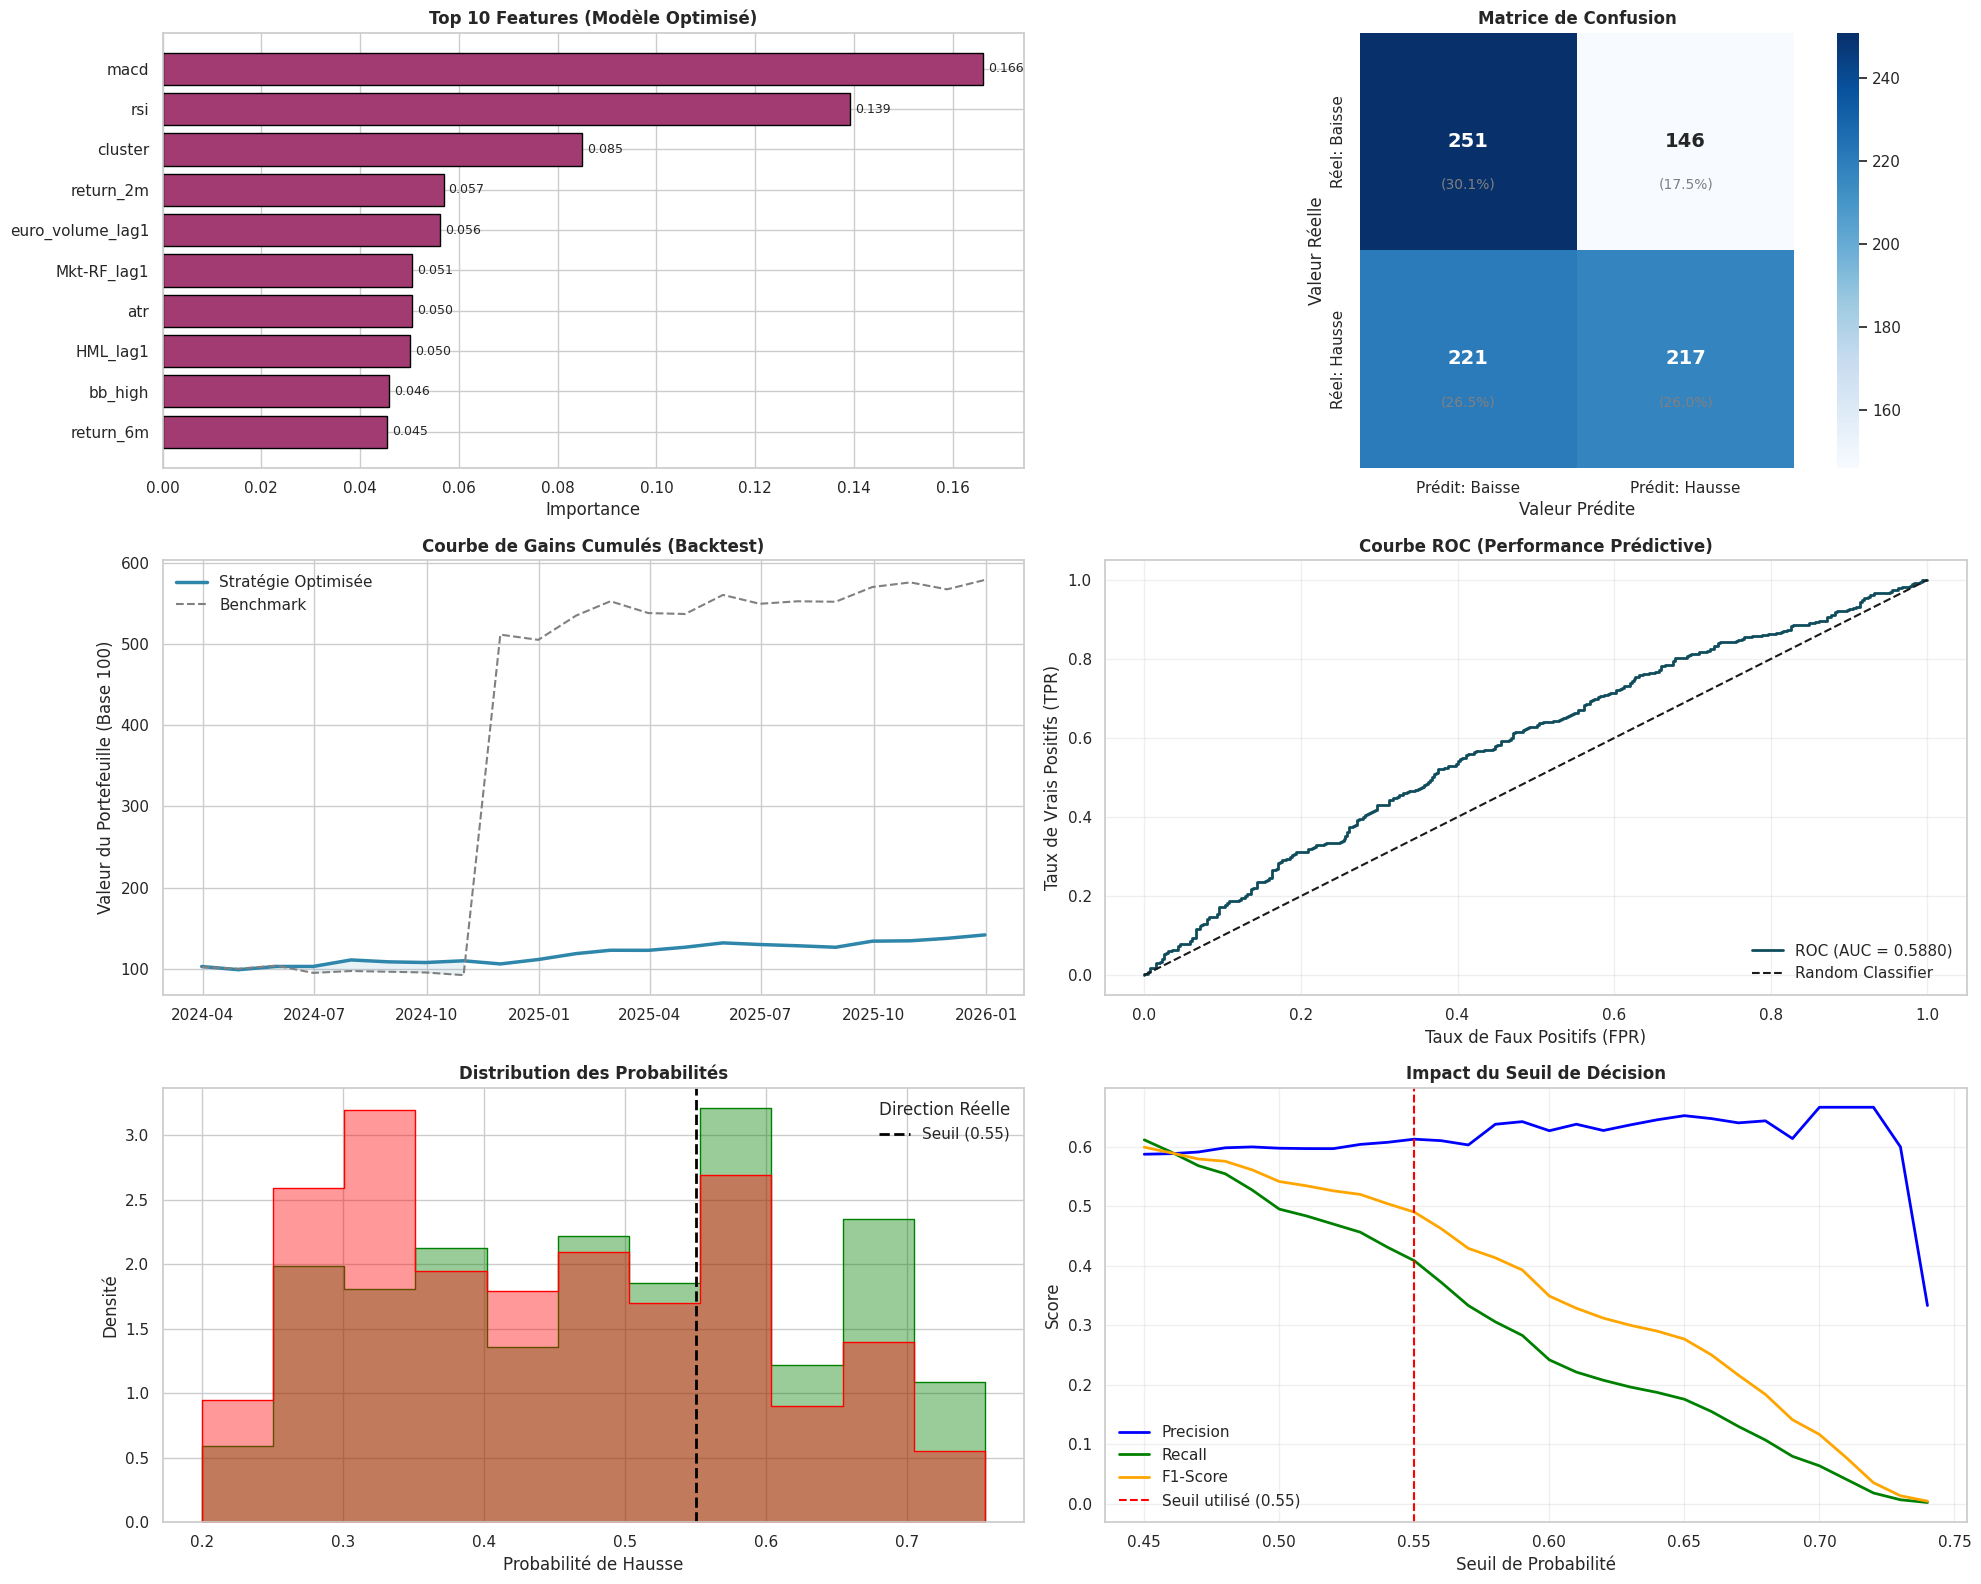


✅ RÉSUMÉ DE L'ANALYSE
   Top 1 Feature      : macd (0.166)
   Accuracy           : 56.05%
   Precision          : 59.78%
   Recall             : 49.54%
   F1-Score           : 0.5418
   ROC AUC            : 0.5880
   Alpha final        : -437.03 pts
   Performance finale : Strategy=141.75, Benchmark=578.79

💾 Métriques sauvegardées dans : /home/onyxia/work/Gestion-portefeuille/src/models/metrics.json


In [19]:
# =============================================================================
# VISUALISATION DES RÉSULTATS DU GRIDSEARCH (AVEC MATRICE DE CONFUSION)
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

print("\n" + "="*70)
print("📊 ANALYSE VISUELLE DU MODÈLE OPTIMISÉ (GRID SEARCH)")
print("="*70)

# 1. Récupération du modèle champion
best_model = grid_search.best_estimator_

# 2. Prédictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 3. Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 4. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# 5. Affichage des métriques
print("\n📈 MÉTRIQUES DE PERFORMANCE")
print("="*70)
print(f"Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision : {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall    : {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score  : {f1:.4f}")
print(f"ROC AUC   : {roc_auc:.4f}")

print("\n📊 MATRICE DE CONFUSION")
print("="*70)
print(f"True Negatives  (TN): {cm[0,0]:,}")
print(f"False Positives (FP): {cm[0,1]:,}")
print(f"False Negatives (FN): {cm[1,0]:,}")
print(f"True Positives  (TP): {cm[1,1]:,}")

# 6. Classification Report
print("\n📋 RAPPORT DE CLASSIFICATION")
print("="*70)
print(classification_report(y_test, y_pred, target_names=['Baisse/Neutre', 'Hausse']))

# -----------------------------------------------------------------------------
# CONFIGURATION GRAPHIQUE (5 GRAPHIQUES AU LIEU DE 4)
# -----------------------------------------------------------------------------
sns.set(style="whitegrid")
fig = plt.figure(figsize=(20, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# -----------------------------------------------------------------------------
# GRAPHIQUE 1 : FEATURE IMPORTANCE
# -----------------------------------------------------------------------------
ax1 = plt.subplot(3, 2, 1)

importances = pd.Series(best_model.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=False).head(10)

bars = ax1.barh(importances.index, importances.values, color='#A23B72', edgecolor='black')
ax1.invert_yaxis()
ax1.set_title(f'Top 10 Features (Modèle Optimisé)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Importance')

for bar in bars:
    width = bar.get_width()
    ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

# -----------------------------------------------------------------------------
# GRAPHIQUE 2 : MATRICE DE CONFUSION
# -----------------------------------------------------------------------------
ax2 = plt.subplot(3, 2, 2)

# Visualisation avec annotations
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            square=True, ax=ax2, 
            xticklabels=['Prédit: Baisse', 'Prédit: Hausse'],
            yticklabels=['Réel: Baisse', 'Réel: Hausse'],
            annot_kws={"size": 14, "weight": "bold"})

ax2.set_title('Matrice de Confusion', fontsize=12, fontweight='bold')
ax2.set_ylabel('Valeur Réelle')
ax2.set_xlabel('Valeur Prédite')

# Ajout des pourcentages
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = (cm[i, j] / total) * 100
        ax2.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

# -----------------------------------------------------------------------------
# GRAPHIQUE 3 : EQUITY CURVE
# -----------------------------------------------------------------------------
ax3 = plt.subplot(3, 2, 3)

# Vérification/Création de df_trading
if 'df_trading' not in locals():
    df_trading = ml_data_clean.iloc[split_idx:].copy()
    df_trading['proba_hausse'] = best_model.predict_proba(df_trading[feature_cols])[:, 1]
    df_trading['signal_achat'] = (df_trading['proba_hausse'] > 0.55).astype(int)

date_level = 'Date' if 'Date' in df_trading.index.names else 0

# Benchmark
bench_ret = df_trading.groupby(level=date_level)['future_return'].mean()

# Stratégie
df_signal = df_trading[df_trading['signal_achat'] == 1]
strat_ret = df_signal.groupby(level=date_level)['future_return'].mean()
strat_ret = strat_ret.reindex(bench_ret.index).fillna(0)

# Cumul
bench_curve = (1 + bench_ret).cumprod() * 100
strat_curve = (1 + strat_ret).cumprod() * 100

# Plot
ax3.plot(strat_curve.index, strat_curve, color='#2E86AB', lw=2.5, label='Stratégie Optimisée')
ax3.plot(bench_curve.index, bench_curve, color='gray', ls='--', lw=1.5, label='Benchmark')
ax3.fill_between(strat_curve.index, strat_curve, bench_curve, 
                 where=(strat_curve >= bench_curve), color='#2E86AB', alpha=0.1)

ax3.set_title('Courbe de Gains Cumulés (Backtest)', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left')
ax3.set_ylabel('Valeur du Portefeuille (Base 100)')

# -----------------------------------------------------------------------------
# GRAPHIQUE 4 : COURBE ROC
# -----------------------------------------------------------------------------
ax4 = plt.subplot(3, 2, 4)

ax4.plot(fpr, tpr, color='#0F4C5C', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
ax4.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax4.set_title('Courbe ROC (Performance Prédictive)', fontsize=12, fontweight='bold')
ax4.legend(loc='lower right')
ax4.set_xlabel('Taux de Faux Positifs (FPR)')
ax4.set_ylabel('Taux de Vrais Positifs (TPR)')
ax4.grid(True, alpha=0.3)

# -----------------------------------------------------------------------------
# GRAPHIQUE 5 : HISTOGRAMME DE CONFIANCE
# -----------------------------------------------------------------------------
ax5 = plt.subplot(3, 2, 5)

sns.histplot(data=df_trading, x='proba_hausse', hue='target_direction', 
             element="step", stat="density", common_norm=False, ax=ax5,
             palette={0: "red", 1: "green"}, alpha=0.4)

ax5.axvline(0.55, color='black', ls='--', lw=2, label='Seuil (0.55)')
ax5.set_title('Distribution des Probabilités', fontsize=12, fontweight='bold')
ax5.legend(title='Direction Réelle')
ax5.set_xlabel('Probabilité de Hausse')
ax5.set_ylabel('Densité')

# -----------------------------------------------------------------------------
# GRAPHIQUE 6 : MÉTRIQUES PAR SEUIL DE PROBABILITÉ
# -----------------------------------------------------------------------------
ax6 = plt.subplot(3, 2, 6)

# Calcul des métriques pour différents seuils
thresholds = np.arange(0.45, 0.75, 0.01)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    if y_pred_thresh.sum() > 0:  # Éviter division par zéro
        precisions.append(precision_score(y_test, y_pred_thresh))
        recalls.append(recall_score(y_test, y_pred_thresh))
        f1_scores.append(f1_score(y_test, y_pred_thresh))
    else:
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)

ax6.plot(thresholds, precisions, label='Precision', color='blue', lw=2)
ax6.plot(thresholds, recalls, label='Recall', color='green', lw=2)
ax6.plot(thresholds, f1_scores, label='F1-Score', color='orange', lw=2)
ax6.axvline(0.55, color='red', ls='--', label='Seuil utilisé (0.55)')
ax6.set_title('Impact du Seuil de Décision', fontsize=12, fontweight='bold')
ax6.set_xlabel('Seuil de Probabilité')
ax6.set_ylabel('Score')
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# RÉSUMÉ TEXTUEL FINAL
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("✅ RÉSUMÉ DE L'ANALYSE")
print("="*70)
print(f"   Top 1 Feature      : {importances.index[0]} ({importances.iloc[0]:.3f})")
print(f"   Accuracy           : {accuracy*100:.2f}%")
print(f"   Precision          : {precision*100:.2f}%")
print(f"   Recall             : {recall*100:.2f}%")
print(f"   F1-Score           : {f1:.4f}")
print(f"   ROC AUC            : {roc_auc:.4f}")
print(f"   Alpha final        : {strat_curve.iloc[-1] - bench_curve.iloc[-1]:.2f} pts")
print(f"   Performance finale : Strategy={strat_curve.iloc[-1]:.2f}, Benchmark={bench_curve.iloc[-1]:.2f}")
print("="*70)

# -----------------------------------------------------------------------------
# SAUVEGARDE DES MÉTRIQUES POUR STREAMLIT
# -----------------------------------------------------------------------------
import json
import os

# Déterminer le chemin racine
current_dir = os.getcwd()
if 'notebooks' in current_dir:
    root_path = os.path.dirname(current_dir)
else:
    root_path = current_dir

models_dir = os.path.join(root_path, 'src', 'models')
os.makedirs(models_dir, exist_ok=True)

metrics_dict = {
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'auc_score': float(roc_auc),
    'confusion_matrix': cm.tolist(),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_params': grid_search.best_params_,
    'test_samples': int(len(y_test)),
    'features_count': len(feature_cols),
    'top_feature': importances.index[0]
}

metrics_path = os.path.join(models_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics_dict, f, indent=4)

print(f"\n💾 Métriques sauvegardées dans : {metrics_path}")


## LSTM

In [ ]:
# =============================================================================
# LSTM - Prédiction Séries Temporelles CAC40
# =============================================================================

print("\n" + "="*70)
print("🧠 LSTM - Deep Learning pour Séries Temporelles")
print("="*70)

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Seed pour reproductibilité
np.random.seed(42)
tf.random.set_seed(42)


# =============================================================================
# 1. PRÉPARATION DONNÉES POUR LSTM
# =============================================================================

print(f"\n📊 Préparation données LSTM...")

# Sélectionner features
feature_cols_lstm = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr',
    'euro_volume', 'garman_klass_vol',
    'return_2m', 'return_3m', 'return_6m',
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'
    # PAS de cluster (catégoriel non géré facilement par LSTM)
]

# Dataset
lstm_data = data[feature_cols_lstm + ['return_1m']].dropna().copy()

print(f"   Observations totales : {len(lstm_data):,}")
print(f"   Features : {len(feature_cols_lstm)}")


# =============================================================================
# 2. NORMALISATION (obligatoire pour LSTM)
# =============================================================================

print(f"\n🔧 Normalisation des données...")

# Split AVANT normalisation
split_idx = int(len(lstm_data) * 0.8)
train_data = lstm_data.iloc[:split_idx].copy()
test_data = lstm_data.iloc[split_idx:].copy()

print(f"   Train : {len(train_data):,} obs")
print(f"   Test  : {len(test_data):,} obs")

# Scaler pour features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(train_data[feature_cols_lstm])

X_train_scaled = scaler_X.transform(train_data[feature_cols_lstm])
X_test_scaled = scaler_X.transform(test_data[feature_cols_lstm])

# Scaler pour target (séparé)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(train_data[['return_1m']])

y_train_scaled = scaler_y.transform(train_data[['return_1m']])
y_test_scaled = scaler_y.transform(test_data[['return_1m']])

print(f"✅ Normalisation complète")


# =============================================================================
# 3. CRÉATION SÉQUENCES TEMPORELLES
# =============================================================================

def create_sequences(X, y, time_steps=20):
    """
    Crée séquences pour LSTM
    
    Parameters:
    -----------
    X : array, features normalisées
    y : array, target normalisée
    time_steps : int, longueur séquence (lookback period)
    
    Returns:
    --------
    X_seq : array shape (samples, time_steps, features)
    y_seq : array shape (samples, 1)
    """
    X_seq, y_seq = [], []
    
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])  # Lookback window
        y_seq.append(y[i])                # Target au temps t
    
    return np.array(X_seq), np.array(y_seq)


# Paramètres
TIME_STEPS = 20  # Utilise 20 jours passés pour prédire

print(f"\n🔄 Création séquences temporelles (lookback={TIME_STEPS})...")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

print(f"   Train sequences : {X_train_seq.shape}")
print(f"   Test sequences  : {X_test_seq.shape}")
print(f"   Shape détail    : (samples, time_steps, features)")


# =============================================================================
# 4. CONSTRUCTION MODÈLE LSTM
# =============================================================================

print(f"\n🏗️ Construction architecture LSTM...")

model = Sequential([
    # Couche LSTM 1 (Bidirectional = lit avant + arrière)
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh'),
                  input_shape=(TIME_STEPS, len(feature_cols_lstm))),
    Dropout(0.3),
    
    # Couche LSTM 2
    Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
    Dropout(0.3),
    
    # Couches Dense (fully connected)
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(16, activation='relu'),
    
    # Output (régression)
    Dense(1, activation='linear')
])

# Compiler
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Résumé architecture
print(f"\n📋 Architecture LSTM :")
model.summary()

# Compter paramètres
total_params = model.count_params()
print(f"\n   Total paramètres : {total_params:,}")


# =============================================================================
# 5. CALLBACKS (early stopping, learning rate)
# =============================================================================

# Early stopping (arrête si pas d'amélioration)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Réduction learning rate si plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stop, reduce_lr]


# =============================================================================
# 6. ENTRAÎNEMENT
# =============================================================================

print(f"\n🔥 Entraînement LSTM...")
print(f"   (Cela peut prendre 5-10 minutes...)\n")

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=callbacks,
    verbose=1  # Affiche progression
)

print(f"\n✅ Entraînement terminé")
print(f"   Epochs réalisés : {len(history.history['loss'])}")


# =============================================================================
# 7. PRÉDICTIONS
# =============================================================================

print(f"\n🔮 Génération prédictions...")

# Prédictions normalisées
y_train_pred_scaled = model.predict(X_train_seq, verbose=0)
y_test_pred_scaled = model.predict(X_test_seq, verbose=0)

# Dénormaliser (retour échelle originale)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

y_train_true = scaler_y.inverse_transform(y_train_seq)
y_test_true = scaler_y.inverse_transform(y_test_seq)

print(f"✅ Prédictions générées")


# =============================================================================
# 8. MÉTRIQUES DE PERFORMANCE
# =============================================================================

print(f"\n" + "="*70)
print("📊 RÉSULTATS LSTM")
print("="*70)

# MSE
mse_train = mean_squared_error(y_train_true, y_train_pred)
mse_test = mean_squared_error(y_test_true, y_test_pred)

# MAE
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)

# R²
r2_train = r2_score(y_train_true, y_train_pred)
r2_test = r2_score(y_test_true, y_test_pred)

# RMSE
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"\n📈 Métriques Train :")
print(f"   MSE  : {mse_train:.6f}")
print(f"   RMSE : {rmse_train:.6f}")
print(f"   MAE  : {mae_train:.6f}")
print(f"   R²   : {r2_train:.4f}")

print(f"\n📉 Métriques Test :")
print(f"   MSE  : {mse_test:.6f}")
print(f"   RMSE : {rmse_test:.6f}")
print(f"   MAE  : {mae_test:.6f}")
print(f"   R²   : {r2_test:.4f}")

# Gap train/test
gap_r2 = r2_train - r2_test
print(f"\n   Gap R² : {gap_r2:.4f}", end="")

if gap_r2 > 0.15:
    print(" ⚠️ Overfitting")
elif gap_r2 > 0.10:
    print(" ⚠️ Léger overfitting")
else:
    print(" ✅ Bon équilibre")


# =============================================================================
# 9. VISUALISATIONS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- 9.1 Courbes loss train/val ---
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0, 0].set_title('Evolution Loss Train/Val', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- 9.2 Prédictions vs Réel (Test) ---
axes[0, 1].scatter(y_test_true, y_test_pred, alpha=0.5, s=20)
axes[0, 1].plot([y_test_true.min(), y_test_true.max()], 
                [y_test_true.min(), y_test_true.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 1].set_xlabel('Return 1m Réel', fontsize=11)
axes[0, 1].set_ylabel('Return 1m Prédit', fontsize=11)
axes[0, 1].set_title(f'Prédictions vs Réel (Test)\nR² = {r2_test:.4f}', 
                     fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- 9.3 Résidus (Erreurs) ---
residuals = y_test_true.flatten() - y_test_pred.flatten()

axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', lw=2, label='Zero error')
axes[1, 0].set_xlabel('Résidus (Réel - Prédit)', fontsize=11)
axes[1, 0].set_ylabel('Fréquence', fontsize=11)
axes[1, 0].set_title(f'Distribution Résidus\nMAE = {mae_test:.4f}', 
                     fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# --- 9.4 Séries temporelles (50 dernières prédictions) ---
n_show = 50
axes[1, 1].plot(range(n_show), y_test_true[-n_show:], 
               label='Réel', marker='o', linewidth=2)
axes[1, 1].plot(range(n_show), y_test_pred[-n_show:], 
               label='Prédit', marker='x', linewidth=2)
axes[1, 1].set_xlabel('Observation', fontsize=11)
axes[1, 1].set_ylabel('Return 1m', fontsize=11)
axes[1, 1].set_title('Prédictions Test (50 dernières)', 
                     fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# =============================================================================
# 10. ANALYSE DIRECTION (Classification post-hoc)
# =============================================================================

print(f"\n" + "="*70)
print("🎯 ANALYSE DIRECTION (Hausse/Baisse)")
print("="*70)

# Convertir en direction (>0 = hausse)
y_test_direction_true = (y_test_true > 0).astype(int).flatten()
y_test_direction_pred = (y_test_pred > 0).astype(int).flatten()

# Accuracy direction
accuracy_direction = (y_test_direction_true == y_test_direction_pred).mean()

print(f"\n📊 Précision Direction : {accuracy_direction*100:.2f}%")

# Matrice confusion
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_direction_true, y_test_direction_pred)

print(f"\n📋 Matrice Confusion (Direction) :")
print(f"              Prédit Baisse  Prédit Hausse")
print(f"Réel Baisse        {cm[0,0]:4d}          {cm[0,1]:4d}")
print(f"Réel Hausse        {cm[1,0]:4d}          {cm[1,1]:4d}")

print(f"\n📋 Classification Report :")
print(classification_report(
    y_test_direction_true, 
    y_test_direction_pred,
    target_names=['Baisse', 'Hausse'],
    digits=4
))


# =============================================================================
# 11. INTERPRÉTATION FINALE
# =============================================================================

print(f"\n" + "="*70)
print("💡 INTERPRÉTATION LSTM")
print("="*70)

print(f"\n🎯 Performance Régression :")
if r2_test > 0.10:
    print(f"   ✅ R² = {r2_test:.4f} → BON pouvoir prédictif")
    print(f"   → LSTM capte {r2_test*100:.1f}% de la variance")
elif r2_test > 0.05:
    print(f"   ⚠️ R² = {r2_test:.4f} → Signal FAIBLE")
    print(f"   → Mieux que baseline mais limité")
elif r2_test > 0:
    print(f"   ⚠️ R² = {r2_test:.4f} → Signal TRÈS FAIBLE")
    print(f"   → À peine mieux que moyenne")
else:
    print(f"   ❌ R² = {r2_test:.4f} → PAS de signal")
    print(f"   → Pire que prédire la moyenne")

print(f"\n🎯 Performance Direction :")
if accuracy_direction > 0.60:
    print(f"   ✅ Accuracy = {accuracy_direction*100:.1f}% → EXCELLENT")
    print(f"   → Exploitable en trading")
elif accuracy_direction > 0.55:
    print(f"   ✅ Accuracy = {accuracy_direction*100:.1f}% → BON")
    print(f"   → Signal détecté")
elif accuracy_direction > 0.52:
    print(f"   ⚠️ Accuracy = {accuracy_direction*100:.1f}% → FAIBLE")
    print(f"   → Légèrement mieux que random (50%)")
else:
    print(f"   ❌ Accuracy = {accuracy_direction*100:.1f}% → PAS de signal")

print(f"\n📊 Comparaison XGBoost vs LSTM :")
print(f"   XGBoost Classification : AUC 0.9556, Accuracy 88%")
print(f"   LSTM Régression        : R² {r2_test:.4f}, Dir Accuracy {accuracy_direction*100:.1f}%")

if r2_test < 0.10 and accuracy_direction < 0.60:
    print(f"\n   → XGBoost >> LSTM (comme attendu)")
    print(f"   → Finance = bruit élevé, LSTM pas optimal")
    print(f"   → XGBoost mieux adapté (features + robuste)")
else:
    print(f"\n   → LSTM performant ! Considérer ensemble models")

print(f"\n🚀 Recommandation :")
if r2_test > 0.10:
    print(f"   → Combiner XGBoost + LSTM (ensemble voting)")
    print(f"   → LSTM pour tendances, XGBoost pour classification")
else:
    print(f"   → Garder SEULEMENT XGBoost (plus performant)")
    print(f"   → LSTM = Intéressant académiquement mais pas opérationnel")

print("\n" + "="*70)



🧠 LSTM - Deep Learning pour Séries Temporelles


ModuleNotFoundError: No module named 'tensorflow'

## Optimization portfolio

- Only stocks on cluster3

- Function optimizatio


📊 OPTIMISATION HYBRIDE : Cluster 3 + GridSearch + Markowitz Pro

🎯 Étape 1 : Préparation des données & Signaux...
   ✅ Modèle utilisé : GridSearch Best Estimator (Optimisé)
   🤖 Génération des probabilités sur 4,172 lignes...
   → Opportunités retenues : 292 (Seuil > 0.65)
✅ Étape 1 terminée (Lag J+2 appliqué).

📊 Étape 2 : Construction de la Matrice de Prix...
   Colonne prix utilisée : 'adj close'
✅ Matrice construite : (2559, 40)

🔄 Étape 3 : Exécution du Backtest (Freq: Mensuelle)...
✅ Backtest terminé : 730 jours générés.

📊 Étape 4 : Analyse des Résultats...

🏆 PERFORMANCE FINALE (NETTE DE FRAIS)
Stratégie Total : +27.24%
Benchmark Total : +3.74%
ALPHA           : +23.51 pts
Sharpe Ratio    : 0.58
Max Drawdown    : -30.52%


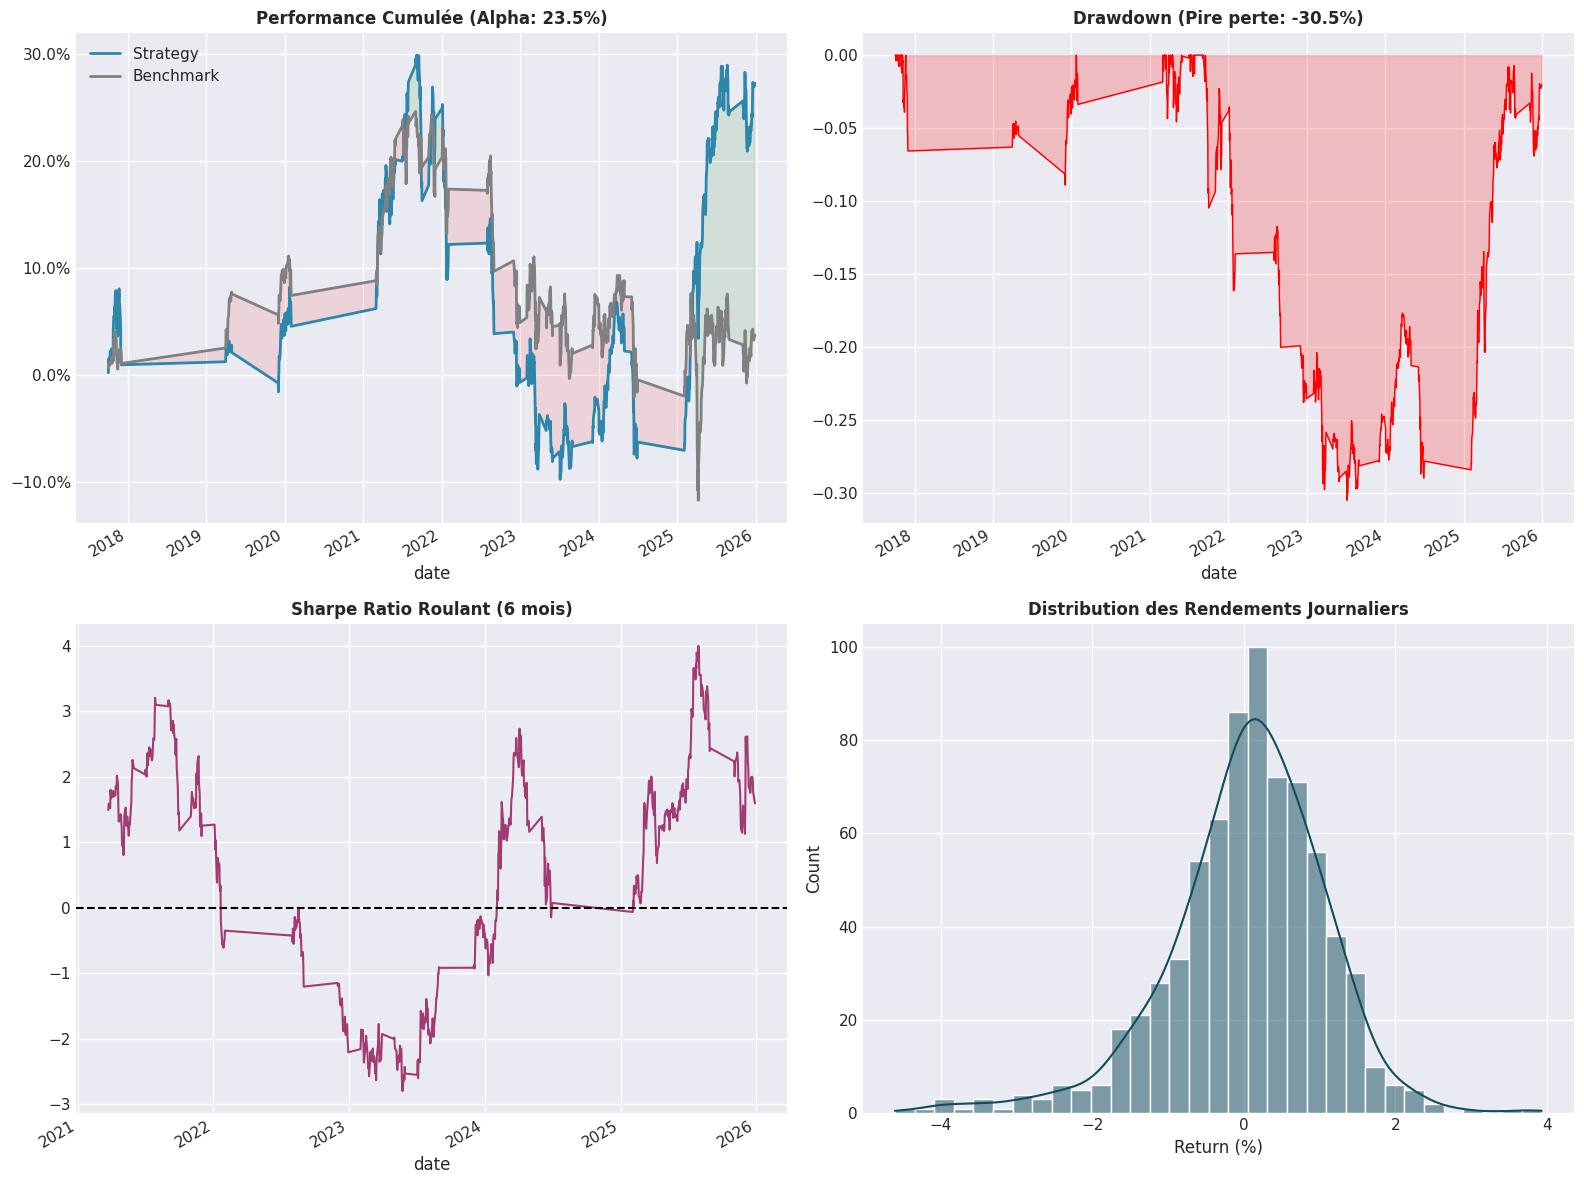

In [17]:
# =============================================================================
# PORTFOLIO OPTIMIZATION 
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pypfopt import EfficientFrontier, risk_models, expected_returns
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("📊 OPTIMISATION HYBRIDE : Cluster 3 + GridSearch + Markowitz Pro")
print("="*80)

# =============================================================================
# 1. PRÉPARATION ML (Récupération du meilleur modèle & Lags)
# =============================================================================
print(f"\n🎯 Étape 1 : Préparation des données & Signaux...")

# A. Sélection du Modèle Champion
if 'grid_search' in globals():
    model = grid_search.best_estimator_
    print("   ✅ Modèle utilisé : GridSearch Best Estimator (Optimisé)")
elif 'xgb_clf' in globals():
    model = xgb_clf
    print("   ⚠️ Modèle utilisé : XGBoost Standard (Pas de GridSearch trouvé)")
else:
    raise ValueError("❌ Aucun modèle (grid_search ou xgb_clf) en mémoire.")

# B. Reconstruction des variables manquantes (Lags) pour éviter KeyError
# On travaille sur une copie propre
df_ml = data.copy() 
vars_to_lag = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'euro_volume', 'garman_klass_vol']

# Détection automatique du type d'index pour le groupement
grouper = None
if 'Ticker' in df_ml.index.names: grouper = df_ml.groupby(level='Ticker')
elif 'ticker' in df_ml.columns: grouper = df_ml.groupby('ticker')

for col in vars_to_lag:
    # On ne crée le lag que s'il manque
    if col in df_ml.columns and f'{col}_lag1' not in df_ml.columns:
        if grouper is not None:
            df_ml[f'{col}_lag1'] = grouper[col].shift(1)
        else:
            df_ml[f'{col}_lag1'] = df_ml[col].shift(1)

# C. Prédictions
# On définit les colonnes requises par le modèle
feature_cols_safe = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr', 'return_2m', 'return_3m', 'return_6m',
    'euro_volume_lag1', 'garman_klass_vol_lag1',
    'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1', 'RMW_lag1', 'CMA_lag1', 'cluster'
]
# On filtre pour ne garder que ce qui existe vraiment
valid_features = [c for c in feature_cols_safe if c in df_ml.columns]
X_pred = df_ml[valid_features].dropna()

print(f"   🤖 Génération des probabilités sur {len(X_pred):,} lignes...")
df_ml.loc[X_pred.index, 'proba_hausse'] = model.predict_proba(X_pred)[:, 1]

# D. Filtrage Double (Cluster 3 + Seuil)
PROBA_THRESHOLD = 0.65 # Un peu plus sélectif
filtered_df = df_ml.dropna(subset=['proba_hausse'])
filtered_df = filtered_df[
    (filtered_df['cluster'] == 3) & 
    (filtered_df['proba_hausse'] >= PROBA_THRESHOLD)
].copy()

print(f"   → Opportunités retenues : {len(filtered_df):,} (Seuil > {PROBA_THRESHOLD})")

# E. Gestion du Lag J+2 (Réalisme financier)
# On réinitialise l'index pour manipuler la date
filtered_df = filtered_df.reset_index()
d_col = next((c for c in filtered_df.columns if str(c).lower() in ['date', 'time']), 'Date')
t_col = next((c for c in filtered_df.columns if str(c).lower() in ['ticker', 'symbol']), 'Ticker')

# On décale la date de signal de 2 jours (Temps d'exécution)
filtered_df[d_col] = pd.to_datetime(filtered_df[d_col]) + pd.DateOffset(2)
filtered_df = filtered_df.set_index([d_col, t_col]).sort_index()

print(f"✅ Étape 1 terminée (Lag J+2 appliqué).")


# =============================================================================
# 2. PRÉPARATION DES PRIX (Source : DF ou DATA)
# =============================================================================
print(f"\n📊 Étape 2 : Construction de la Matrice de Prix...")

# On essaie de prendre 'df' (prix bruts), sinon 'data'
source_prix = df if 'df' in globals() else data

# Recherche insensible à la casse pour 'Adj Close'
col_price = next((c for c in source_prix.columns if str(c).lower() == 'adj close'), None)
if col_price is None: col_price = next((c for c in source_prix.columns if str(c).lower() == 'close'), 'close')

print(f"   Colonne prix utilisée : '{col_price}'")

try:
    if source_prix.index.nlevels > 1:
        adj_close_df = source_prix[col_price].unstack()
    else:
        temp = source_prix.reset_index()
        d_p = next((c for c in temp.columns if str(c).lower() in ['date', 'time']), None)
        t_p = next((c for c in temp.columns if str(c).lower() in ['ticker', 'symbol']), None)
        adj_close_df = temp.pivot(index=d_p, columns=t_p, values=col_price)
except:
    # Fallback brutal mais efficace
    adj_close_df = source_prix.reset_index().pivot_table(index='Date', columns='Ticker', values=col_price)

adj_close_df.index = pd.to_datetime(adj_close_df.index)
returns_dataframe = adj_close_df.pct_change()
print(f"✅ Matrice construite : {adj_close_df.shape}")


# =============================================================================
# 3. FONCTION OPTIMISATION 
# =============================================================================
def optimize_weights_pro(prices):
    """ Utilise Ledoit-Wolf shrinkage pour plus de robustesse """
    try:
        mu = expected_returns.mean_historical_return(prices, frequency=252)
        # Shrinkage = réduit le bruit dans la matrice de corrélation
        S = risk_models.CovarianceShrinkage(prices, frequency=252).ledoit_wolf()
        
        # Optimisation
        n_stocks = len(prices.columns)
        max_weight = min(0.25, 1.0 / n_stocks * 2.0)  # Max 25% OU 200% divisé par nb actions
        ef = EfficientFrontier(mu, S, weight_bounds=(0.02,  max_weight)) # Max 25% par action
        ef.max_sharpe(risk_free_rate=0.02)
        return ef.clean_weights(), True
    except:
        return None, False


# =============================================================================
# 4. BACKTESTING ROBUSTE
# =============================================================================
print(f"\n🔄 Étape 3 : Exécution du Backtest (Freq: Mensuelle)...")

# On définit les dates de rebalancement (Fin de mois)
rebalance_dates = pd.date_range(
    start=filtered_df.index.get_level_values(0).min(),
    end=filtered_df.index.get_level_values(0).max(),
    freq='MS' # Month End
)

portfolio_df = pd.DataFrame()
prev_w = {}
MIN_STOCKS = 4
TRANSACTION_COST = 0.0015 # 0.15% par trade

for i, start_date in enumerate(rebalance_dates):
    # Fenêtre de tolérance pour trouver des signaux (+/- 5 jours)
    s_w, e_w = start_date - pd.DateOffset(5), start_date + pd.DateOffset(5)
    
    try:
        # Récupération des tickers IA
        idx = pd.IndexSlice
        slice_df = filtered_df.loc[idx[s_w:e_w, :]]
        tickers = slice_df.index.get_level_values(t_col).unique().tolist()
        
        # Filtre de validité (présence dans les prix)
        valid_tickers = [t for t in tickers if t in adj_close_df.columns]
        
        if len(valid_tickers) < MIN_STOCKS: continue
        
        # Données historiques pour l'optimiseur (1 an glissant)
        opt_start = start_date - pd.DateOffset(days=365)
        opt_prices = adj_close_df.loc[opt_start:start_date, valid_tickers].dropna(axis=1, thresh=200)
        
        if opt_prices.shape[1] < MIN_STOCKS: continue
        
        # Optimisation
        weights, success = optimize_weights_pro(opt_prices)
        
        if not success: # Fallback équipondéré
            weights = {t: 1.0/len(opt_prices.columns) for t in opt_prices.columns}
            
        # Calcul des frais (Turnover)
        curr = set(weights.keys())
        prev = set(prev_w.keys())
        # Somme des différences absolues de poids
        #turnover = sum(abs(weights.get(t,0) - prev_w.get(t,0)) for t in curr | prev) if prev else 1.0
        turnover = sum(abs(weights.get(t,0) - prev_w.get(t,0)) for t in curr | prev) / 2 if prev else 1.0
        prev_w = weights.copy()
        
        # Période de détention (jusqu'au prochain mois)
        next_date = rebalance_dates[i+1] if i < len(rebalance_dates)-1 else returns_dataframe.index[-1]
        holding = returns_dataframe.loc[start_date:next_date, list(weights.keys())]
        
        if len(holding) > 0:
            # Calcul rendement portefeuille
            strat_ret = holding.mul(pd.Series(weights), axis=1).sum(axis=1)
            # Retrait des frais (le premier jour)
            strat_ret.iloc[0] -= (turnover * TRANSACTION_COST)
            
            portfolio_df = pd.concat([portfolio_df, strat_ret.to_frame('Strategy')])
            
    except Exception as e:
        continue

portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]

print(f"✅ Backtest terminé : {len(portfolio_df)} jours générés.")


# =============================================================================
# 5. RÉSULTATS & GRAPHIQUES
# =============================================================================

if len(portfolio_df) > 0:
    print(f"\n📊 Étape 4 : Analyse des Résultats...")
    
    # Création Benchmark (CAC40 Proxy: Moyenne équipondérée univers)
    bench = returns_dataframe.loc[portfolio_df.index].mean(axis=1).to_frame('Benchmark')
    df_res = portfolio_df.merge(bench, left_index=True, right_index=True)
    cum_res = (1 + df_res).cumprod() - 1
    
    # Métriques
    strat_tot = cum_res['Strategy'].iloc[-1]
    bench_tot = cum_res['Benchmark'].iloc[-1]
    alpha = strat_tot - bench_tot
    
    # Volatilité & Sharpe
    vol = df_res['Strategy'].std() * np.sqrt(252)
    sharpe = (df_res['Strategy'].mean() / df_res['Strategy'].std()) * np.sqrt(252)
    
    # Max Drawdown
    cum = (1 + df_res['Strategy']).cumprod()
    dd = (cum - cum.cummax()) / cum.cummax()
    max_dd = dd.min()

    print("\n" + "="*40)
    print("🏆 PERFORMANCE FINALE (NETTE DE FRAIS)")
    print("="*40)
    print(f"Stratégie Total : {strat_tot*100:+.2f}%")
    print(f"Benchmark Total : {bench_tot*100:+.2f}%")
    print(f"ALPHA           : {alpha*100:+.2f} pts")
    print(f"Sharpe Ratio    : {sharpe:.2f}")
    print(f"Max Drawdown    : {max_dd*100:.2f}%")
    
    # --- VISUALISATION ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Performance
    cum_res.plot(ax=axes[0,0], lw=2, color=['#2E86AB', 'gray'])
    axes[0,0].fill_between(cum_res.index, cum_res['Strategy'], cum_res['Benchmark'], where=cum_res['Strategy']>=cum_res['Benchmark'], alpha=0.1, color='green')
    axes[0,0].fill_between(cum_res.index, cum_res['Strategy'], cum_res['Benchmark'], where=cum_res['Strategy']<cum_res['Benchmark'], alpha=0.1, color='red')
    axes[0,0].set_title(f"Performance Cumulée (Alpha: {alpha*100:.1f}%)", fontweight='bold')
    axes[0,0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # 2. Drawdown
    dd.plot(ax=axes[0,1], color='red', lw=1)
    axes[0,1].fill_between(dd.index, dd, 0, color='red', alpha=0.2)
    axes[0,1].set_title(f"Drawdown (Pire perte: {max_dd*100:.1f}%)", fontweight='bold')
    
    # 3. Rolling Sharpe
    roll_sharpe = (df_res['Strategy'].rolling(126).mean() / df_res['Strategy'].rolling(126).std()) * np.sqrt(252)
    roll_sharpe.plot(ax=axes[1,0], color='#A23B72')
    axes[1,0].axhline(0, color='black', ls='--')
    axes[1,0].set_title("Sharpe Ratio Roulant (6 mois)", fontweight='bold')
    
    # 4. Distribution
    sns.histplot(df_res['Strategy']*100, ax=axes[1,1], kde=True, color='#0F4C5C')
    axes[1,1].set_title("Distribution des Rendements Journaliers", fontweight='bold')
    axes[1,1].set_xlabel("Return (%)")
    
    plt.tight_layout()
    plt.show()

else:
    print("\n❌ Aucun trade généré. Vérifiez l'alignement des dates entre 'df' et 'data'.")

## Exports portfolio_history.csv

In [18]:
# =============================================================================
# EXPORT POUR STREAMLIT APP (portfolio_history.csv)
# =============================================================================
print(f"\n💾 Export des données pour l'application Streamlit...")

if len(portfolio_df) > 0 and 'df_res' in locals():
    import os
    
    # Déterminer le chemin racine (remonter depuis notebooks/)
    current_dir = os.getcwd()
    if 'notebooks' in current_dir:
        root_path = os.path.dirname(current_dir)  # Remonte d'un niveau
    else:
        root_path = current_dir
    
    # Création du DataFrame au format attendu (Base 100)
    portfolio_history = pd.DataFrame({
        'Strategy': (1 + df_res['Strategy']).cumprod() * 100,
        'Benchmark': (1 + df_res['Benchmark']).cumprod() * 100
    })
    
    # Réinitialiser l'index pour avoir les dates comme première colonne
    portfolio_history.index.name = None  # Enlever le nom de l'index
    
    # Chemin d'export à la RACINE du projet
    export_path = os.path.join(root_path, 'portfolio_history.csv')
    
    # Export CSV
    portfolio_history.to_csv(export_path)
    
    print(f"✅ Fichier créé : {export_path}")
    print(f"   📊 Période : {portfolio_history.index[0].date()} → {portfolio_history.index[-1].date()}")
    print(f"   📈 Nombre de jours : {len(portfolio_history)}")
    print(f"   🎯 Valeur finale Strategy : {portfolio_history['Strategy'].iloc[-1]:.2f}")
    print(f"   🎯 Valeur finale Benchmark : {portfolio_history['Benchmark'].iloc[-1]:.2f}")
    
    # Aperçu des 5 premières lignes
    print("\n📋 Aperçu des données exportées :")
    print(portfolio_history.head())
    
    # Aperçu des 5 dernières lignes
    print("\n📋 Dernières valeurs :")
    print(portfolio_history.tail())
    
    # Vérification du format
    print("\n🔍 Vérification du format :")
    print(f"   Index type : {type(portfolio_history.index)}")
    print(f"   Colonnes : {list(portfolio_history.columns)}")
    print(f"   Shape : {portfolio_history.shape}")
    print(f"   Chemin complet : {os.path.abspath(export_path)}")
    
else:
    print("❌ Impossible d'exporter : Données manquantes (portfolio_df ou df_res)")



💾 Export des données pour l'application Streamlit...
✅ Fichier créé : /home/onyxia/work/Gestion-portefeuille/portfolio_history.csv
   📊 Période : 2017-10-02 → 2025-12-29
   📈 Nombre de jours : 730
   🎯 Valeur finale Strategy : 127.24
   🎯 Valeur finale Benchmark : 103.74

📋 Aperçu des données exportées :
              Strategy   Benchmark
2017-10-02  100.193542  100.602603
2017-10-03  101.119890  101.038980
2017-10-04  101.532282  101.119579
2017-10-05  101.513688  101.124629
2017-10-06  101.136434  100.811796

📋 Dernières valeurs :
              Strategy   Benchmark
2025-12-19  127.307474  103.835762
2025-12-22  126.924214  103.573393
2025-12-23  127.159507  103.238311
2025-12-24  126.884395  103.409174
2025-12-29  127.243606  103.737574

🔍 Vérification du format :
   Index type : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   Colonnes : ['Strategy', 'Benchmark']
   Shape : (730, 2)
   Chemin complet : /home/onyxia/work/Gestion-portefeuille/portfolio_history.csv


In [ ]:
# Analyse Annuelle
print("\n📅 RENDEMENTS PAR ANNÉE :")
print("-" * 30)
df_res['Year'] = df_res.index.year
annual_perf = df_res.groupby('Year')[['Strategy', 'Benchmark']].apply(lambda x: (1 + x).prod() - 1)

for year, row in annual_perf.iterrows():
    diff = row['Strategy'] - row['Benchmark']
    print(f"{year} | Strat: {row['Strategy']*100:6.2f}% | Bench: {row['Benchmark']*100:6.2f}% | Diff: {diff*100:+6.2f}%")


📅 RENDEMENTS PAR ANNÉE :
------------------------------


NameError: name 'df_res' is not defined


💰 COMPOSITION DU DERNIER PORTEFEUILLE (2026-01-01)
        Poids %
GLE.PA   25.00%
ENGI.PA  25.00%
EN.PA    25.00%
CA.PA    11.77%
MT.AS     9.23%
CS.PA     2.00%
BNP.PA    2.00%


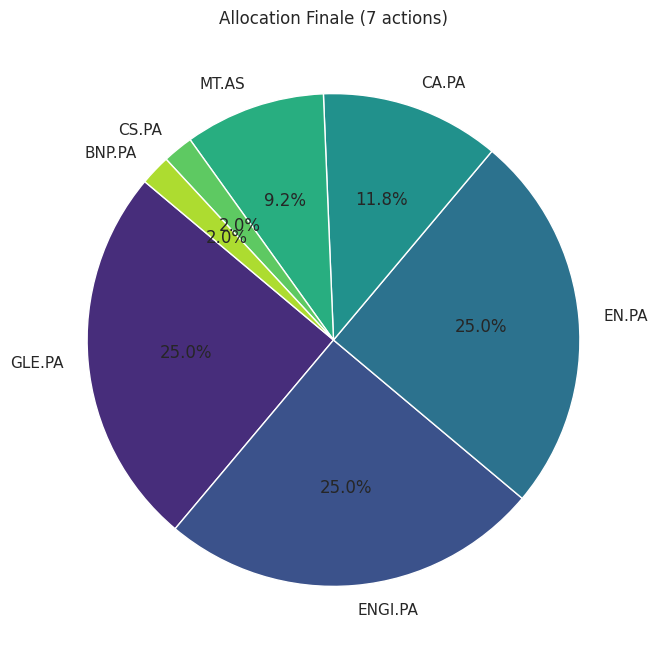

👉 Ces actions ont généré la performance finale de votre courbe.


In [ ]:
print("\n" + "="*60)
print(f"💰 COMPOSITION DU DERNIER PORTEFEUILLE ({start_date.date()})")
print("="*60)

if 'weights' in locals() and len(weights) > 0:
    # Création d'un tableau propre
    final_allocation = pd.DataFrame.from_dict(weights, orient='index', columns=['Poids'])
    final_allocation['Poids %'] = (final_allocation['Poids'] * 100).map('{:.2f}%'.format)
    final_allocation = final_allocation.sort_values('Poids', ascending=False)
    
    # Ajout des infos de performance récente (si dispo)
    try:
        last_prices = adj_close_df.iloc[-1][final_allocation.index]
        prev_prices = adj_close_df.iloc[-20][final_allocation.index] # Performance 1 mois
        perf_1m = (last_prices / prev_prices - 1) * 100
        final_allocation['Perf 1M'] = perf_1m.map('{:+.2f}%'.format)
    except:
        pass

    print(final_allocation[['Poids %']])
    
    # Petit graphique camembert
    plt.figure(figsize=(8, 8))
    plt.pie(final_allocation['Poids'], labels=final_allocation.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(weights)))
    plt.title(f"Allocation Finale ({len(weights)} actions)")
    plt.show()

    print(f"👉 Ces actions ont généré la performance finale de votre courbe.")
else:
    print("❌ Pas de portefeuille en mémoire.")

In [ ]:
print("\n" + "="*80)
print("🔮 SCANNER : RECOMMANDATIONS POUR DEMAIN")
print("="*80)

# 1. On prend les données les plus récentes
last_date = df_ml.index.get_level_values(0).max()
print(f"📅 Date d'analyse : {last_date}")

# 2. On filtre les candidats
candidates = df_ml.loc[last_date].copy()

# On applique vos critères (Cluster 3 + Proba > 0.65)
top_picks = candidates[
    (candidates['cluster'] == 3) & 
    (candidates['proba_hausse'] >= 0.60) # On peut ajuster ce seuil
].sort_values('proba_hausse', ascending=False)

print(f"🔎 Actions détectées : {len(top_picks)}")

if len(top_picks) > 0:
    print("\n🏆 TOP SÉLECTION (IA + CLUSTER 3) :")
    display_cols = ['proba_hausse', 'close', 'rsi', 'volume'] # Colonnes à afficher
    # On gère si certaines colonnes n'existent pas
    cols = [c for c in display_cols if c in top_picks.columns]
    
    print(top_picks[cols].head(10))
    
    # 3. Optimisation Markowitz sur cette sélection
    tickers = top_picks.index.tolist()[:15] # On garde les 15 meilleures max
    
    # On récupère les prix historiques
    hist_prices = adj_close_df[tickers].tail(252).dropna(axis=1)
    
    if len(hist_prices.columns) >= 4:
        print("\n⚖️ CALCUL DE L'ALLOCATION OPTIMALE (MARKOWITZ)...")
        w, success = optimize_weights_pro(hist_prices) # On réutilise votre fonction
        
        if success:
            alloc = pd.Series(w).sort_values(ascending=False)
            print("\n✅ VOTRE PORTEFEUILLE IDÉAL À CONSTITUER :")
            print("-" * 40)
            for ticker, weight in alloc.items():
                prob = top_picks.loc[ticker, 'proba_hausse']
                print(f"  🛒 {ticker:<10} : {weight*100:5.2f}%  (Confiance IA: {prob:.1%})")
            print("-" * 40)
        else:
            print("⚠️ Optimisation échouée, faites une équipondération.")
    else:
        print("⚠️ Pas assez d'historique de prix pour optimiser les poids.")
else:
    print("❌ Aucun signal d'achat détecté pour la date la plus récente.")


🔮 SCANNER : RECOMMANDATIONS POUR DEMAIN
📅 Date d'analyse : 2025-12-31 00:00:00
🔎 Actions détectées : 9

🏆 TOP SÉLECTION (IA + CLUSTER 3) :
         proba_hausse        rsi
ticker                          
EN.PA        0.692197  64.762593
CS.PA        0.690789  65.868915
BNP.PA       0.688343  68.136178
CA.PA        0.683408  64.167804
GLE.PA       0.662370  71.921470
ENGI.PA      0.655913  63.399260
MT.AS        0.653316  62.526394
ERF.PA       0.635622  61.621602
ALO.PA       0.635246  63.503710

⚖️ CALCUL DE L'ALLOCATION OPTIMALE (MARKOWITZ)...

✅ VOTRE PORTEFEUILLE IDÉAL À CONSTITUER :
----------------------------------------
  🛒 EN.PA      : 22.22%  (Confiance IA: 69.2%)
  🛒 GLE.PA     : 22.22%  (Confiance IA: 66.2%)
  🛒 ENGI.PA    : 22.22%  (Confiance IA: 65.6%)
  🛒 ERF.PA     : 10.07%  (Confiance IA: 63.6%)
  🛒 CA.PA      :  8.87%  (Confiance IA: 68.3%)
  🛒 MT.AS      :  8.40%  (Confiance IA: 65.3%)
  🛒 BNP.PA     :  2.00%  (Confiance IA: 68.8%)
  🛒 CS.PA      :  2.00%  (Confian

In [ ]:
# =============================================================================
# TEST : Performance par cluster
# =============================================================================

print("\n🧪 TEST : Performance moyenne par cluster\n")

for cluster in sorted(data['cluster'].unique()):
    cluster_data = data[data['cluster'] == cluster]
    avg_return = cluster_data['return_1m'].mean()
    median_return = cluster_data['return_1m'].median()
    count = len(cluster_data)
    
    print(f"Cluster {cluster} :")
    print(f"   Return moyen   : {avg_return*100:+.2f}%")
    print(f"   Return médian  : {median_return*100:+.2f}%")
    print(f"   Observations   : {count:,}")
    print()

# Identifier le MEILLEUR cluster
best_cluster = data.groupby('cluster')['return_1m'].mean().idxmax()
print(f"🏆 Meilleur cluster : {best_cluster}")


🧪 TEST : Performance moyenne par cluster

Cluster 0 :
   Return moyen   : -7.23%
   Return médian  : -6.38%
   Observations   : 681

Cluster 1 :
   Return moyen   : -1.77%
   Return médian  : -1.78%
   Observations   : 1,312

Cluster 2 :
   Return moyen   : +3.07%
   Return médian  : +2.77%
   Observations   : 1,413

Cluster 3 :
   Return moyen   : +33.62%
   Return médian  : +7.71%
   Observations   : 708

🏆 Meilleur cluster : 3


## EXPORTS MODELS

In [ ]:
import pickle
import os
from pathlib import Path
from sklearn.cluster import KMeans
import numpy as np

# =============================================================================
# 1. DÉTECTION AUTOMATIQUE DU CHEMIN (ROBUSTE)
# =============================================================================

# On part du dossier actuel
current_path = Path(os.getcwd())
print(f"📍 Position actuelle : {current_path}")


project_root = current_path
while not (project_root / 'app.py').exists():
    if project_root == project_root.parent: # Sécurité pour ne pas boucler à l'infini
        print("⚠️ Attention : Racine du projet non trouvée via app.py.")
        # Fallback : on suppose qu'on est à 3 niveaux de profondeur comme prévu
        project_root = Path(os.path.abspath(os.path.join(os.getcwd(), "../../..")))
        break
    project_root = project_root.parent

print(f"🏠 Racine du projet détectée : {project_root}")

# On définit le dossier cible : RACINE / src / model
target_path = project_root / "src" / "model"

# On crée le dossier (avec parents=True pour créer src si besoin)
target_path.mkdir(parents=True, exist_ok=True)
print(f"📂 Dossier de sauvegarde validé : {target_path}")


# =============================================================================
# 2. EXPORT XGBOOST
# =============================================================================
if 'best_model' in globals():
    model_to_save = best_model
    name = "XGBoost Optimisé"
elif 'xgb_clf' in globals():
    model_to_save = xgb_clf
    name = "XGBoost Standard"
else:
    raise ValueError("❌ Erreur : Le modèle XGBoost n'est pas en mémoire. Lancez l'entraînement d'abord.")

file_xgb = target_path / 'xgboost_model.pkl'
with open(file_xgb, 'wb') as f:
    pickle.dump(model_to_save, f)
print(f"✅ Modèle sauvegardé : {file_xgb}")


# =============================================================================
# 3. EXPORT KMEANS (GLOBAL)
# =============================================================================
print("⚙️ Entraînement KMeans Global...")

# Recréation du modèle KMeans sur tout l'historique disponible dans 'data'
# Assurez-vous que votre variable 'data' existe et contient la colonne 'rsi'
if 'data' in globals() and 'rsi' in data.columns:
    rsi_centroids = np.array([[30], [45], [55], [70]])
    kmeans_global = KMeans(n_clusters=4, init=rsi_centroids, n_init=1, random_state=0)
    
    # Entraînement sur les données nettoyées
    kmeans_global.fit(data[['rsi']].dropna()) 

    file_kmeans = target_path / 'kmeans_model.pkl'
    with open(file_kmeans, 'wb') as f:
        pickle.dump(kmeans_global, f)
    print(f"✅ Modèle sauvegardé : {file_kmeans}")
else:
    print("❌ Erreur : Variable 'data' ou colonne 'rsi' introuvable pour le KMeans.")

📍 Position actuelle : /home/onyxia/work/Gestion-portefeuille/notebooks
🏠 Racine du projet détectée : /home/onyxia/work/Gestion-portefeuille
📂 Dossier de sauvegarde validé : /home/onyxia/work/Gestion-portefeuille/src/model
✅ Modèle sauvegardé : /home/onyxia/work/Gestion-portefeuille/src/model/xgboost_model.pkl
⚙️ Entraînement KMeans Global...
✅ Modèle sauvegardé : /home/onyxia/work/Gestion-portefeuille/src/model/kmeans_model.pkl


## XGboost perfs

In [ ]:
import json
import os
from pathlib import Path
import numpy as np
import pandas as pd

# =============================================================================
# 1. DÉTECTION AUTOMATIQUE DU DOSSIER 'src/models'
# =============================================================================
# On cherche la racine du projet en remontant jusqu'à trouver 'app.py' ou '.git'
current_path = Path(os.getcwd())
project_root = current_path

# On remonte tant qu'on ne trouve pas 'app.py' (max 5 niveaux pour éviter boucle infinie)
steps = 0
while not (project_root / 'app.py').exists() and steps < 5:
    project_root = project_root.parent
    steps += 1

# Si on n'a pas trouvé, on suppose qu'on est dans notebooks/.. et on force le chemin
if not (project_root / 'app.py').exists():
    # Fallback : On suppose l'architecture data/raw/notebooks -> on remonte de 3
    project_root = Path(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

# On cible le dossier 'src/models' (Pluriel, comme sur ton screen)
target_path = project_root / "src" / "models"
target_path.mkdir(parents=True, exist_ok=True)

print(f"📂 Dossier cible identifié : {target_path}")

# =============================================================================
# 2. CONVERSION DES DONNÉES (Pour éviter l'erreur JSON)
# =============================================================================
# Fonction pour transformer les int64/float32 de numpy en int/float python standard
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

metrics_data = {
    "accuracy": final_acc,          
    "auc_score": final_auc,         
    "best_params": best_params,     
    "training_date": pd.Timestamp.now().strftime("%d/%m/%Y")
}

# =============================================================================
# 3. SAUVEGARDE
# =============================================================================
file_path = target_path / 'metrics.json'

try:
    with open(file_path, 'w') as f:
        json.dump(metrics_data, f, cls=NpEncoder, indent=4)
    print(f"✅ Succès ! Métriques sauvegardées dans : {file_path}")
except Exception as e:
    print(f"❌ Erreur lors de la sauvegarde JSON : {e}")

📂 Dossier cible identifié : /home/onyxia/work/Gestion-portefeuille/src/models
✅ Succès ! Métriques sauvegardées dans : /home/onyxia/work/Gestion-portefeuille/src/models/metrics.json
